In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import statsmodels.tsa.api as tsa
import matplotlib as mpl
%matplotlib inline
warnings.filterwarnings('ignore')
mpl.rc('font',family='Malgun Gothic')
from tqdm.auto import tqdm
from statsmodels.tools.eval_measures  import rmse
import torch

import time
import ipywidgets as widgets
from IPython.display import display


In [97]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [99]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5079696335583223567
 xla_global_id: -1]

In [100]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [101]:
device = torch.device('cuda')

In [102]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 33.4 gigabytes of available RAM

You are using a high-RAM runtime!


전처리 

In [104]:
train_data = pd.read_csv("C://Users//SHinjaeyoung//Desktop//open//train.csv")

In [105]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
submission_format = pd.read_csv("C://Users//SHinjaeyoung//Desktop//open//sample_submission.csv")

In [107]:
submission_format

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Prophet 학습 형식에 맞춰 전처리 작업

In [109]:
train_data = train_data.drop(columns =['제품','대분류','중분류','소분류','브랜드'])

In [110]:
train_data

,ID,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [112]:
train_data = train_data.set_index(['ID'])
train_data.head()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
train_data.columns.name = 'date'

In [114]:
train_data = train_data.T
train_data.head()

ID,0,1,2,3,4,5,6,7,8,9,...,15880,15881,15882,15883,15884,15885,15886,15887,15888,15889
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-04,0,0,0,0,0,0,7,0,15,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-05,0,0,0,0,0,0,21,0,16,0,...,0,0,0,0,0,0,0,0,0,0


### 주어진 2022-01-01 ~ 2023-04-04 실제 일별 판매량 데이터
#### ID  0 번 째 , 1번째


<Axes: xlabel='date', ylabel='1'>

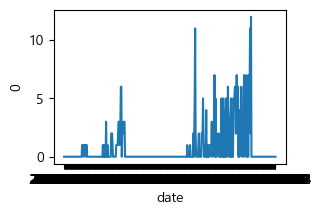

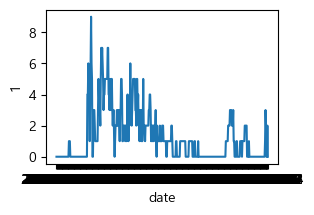

In [116]:
plt.figure(figsize=(3,2))
sns.lineplot(data=train_data, x='date' ,y=0)



plt.figure(figsize=(3,2))
sns.lineplot(data=train_data, x='date' ,y=1)



## 학습

In [118]:
import io, os, sys, setuptools, tokenize
#!pip install prophet plotly -Uqq
import prophet

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
#from pandas_datareader import data

from prophet import Prophet
import numpy as np
import seaborn as sns
from prophet.plot import add_changepoints_to_plot
import random

In [119]:
train_data.shape

(459, 15890)

In [120]:
print(len(train_data))

459


# 학습  /   검증  8 : 2  Split

In [135]:
#Train / Validation Split
data_len = len(train_data)
val_data = train_data[-int(data_len*0.2):]
train_input = train_data[:-int(data_len*0.2)]


In [136]:
val_data.head()

ID,0,1,2,3,4,5,6,7,8,9,...,15880,15881,15882,15883,15884,15885,15886,15887,15888,15889
date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,5,1,3,0,2,0,0,0,0,1,...,0,0,0,0,0,8,7,0,1,0
2023-01-05,5,1,2,0,0,0,0,0,0,8,...,0,0,0,0,0,8,7,0,2,0
2023-01-06,6,1,2,0,12,0,0,0,0,1,...,0,0,0,0,0,7,6,0,2,0
2023-01-07,6,1,1,0,14,0,0,0,0,2,...,0,0,0,0,0,8,6,0,2,0
2023-01-08,2,2,2,0,0,0,0,0,0,10,...,0,0,0,0,0,10,9,0,2,0


In [137]:
train_input.head()

ID,0,1,2,3,4,5,6,7,8,9,...,15880,15881,15882,15883,15884,15885,15886,15887,15888,15889
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-04,0,0,0,0,0,0,7,0,15,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-05,0,0,0,0,0,0,21,0,16,0,...,0,0,0,0,0,0,0,0,0,0


# 결측치 제거

In [139]:
train_input.fillna(0, inplace = True)

In [140]:
val_data.fillna(0, inplace = True)

In [141]:
nan_per_column = train_data.isna().sum() 
nan_per_column

ID
0        0
1        0
2        0
3        0
4        0
        ..
15885    0
15886    0
15887    0
15888    0
15889    0
Length: 15890, dtype: int64

### ID = 0 만 학습 실험

In [147]:
train_input_ID_0 = pd.DataFrame(train_input[0])

Prophet_train_0 = pd.DataFrame()
Prophet_train_0['ds'] = train_input_ID_0.index
Prophet_train_0['y'] = train_input_ID_0.values

#train_input_ID_0.reset_index(inplace=True)

#train_input_ID_0 = pd.DataFrame({'ds':train_input_ID_0['date'], 'y':train_input_ID_0[0]})

In [155]:
Prophet_train_0.head()

,ds,y
0,2022-01-01,0
1,2022-01-02,0
2,2022-01-03,0
3,2022-01-04,0
4,2022-01-05,0


In [157]:
val_data_ID_0  = pd.DataFrame(val_data[0])
val_train_0 =  pd.DataFrame()
val_train_0['ds'] = val_data_ID_0 .index
val_train_0['y'] = val_data_ID_0 .values
val_train_0.head()

,ds,y
0,2023-01-04,5
1,2023-01-05,5
2,2023-01-06,6
3,2023-01-07,6
4,2023-01-08,2


In [159]:
m = Prophet(       interval_width=1, #정확도 향상
                   changepoint_prior_scale=0.5, 
                    changepoint_range = 0.9)
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=15, mode= 'multiplicative' )
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10, mode= 'multiplicative')
m.add_seasonality(name='weekly', period=7, fourier_order=8, prior_scale=3, mode='multiplicative') # 'multiplicative'   'additive')
m.fit(Prophet_train_0)

#changepoint_prior_scale 트렌드 조정 본 데이터가 유연성이 있는가를 조정

#fourier_order 숫자가 커지면 학습 데이터셋에 더 세밀하게 맞게 학습이 되고,
#숫자가 작아지면 조금 더 러프하게 학습이 된다. 적당한 값으로 설정

#prior_scale 기본값 10 작아질수록 적은 영향을 주게 된다 
#각 계절성을 반영하기 위해 연간 , 월간  , 주간 순으로 높게 반영하였음 

#mode='multiplicative' 데이터의 변동성이 계절적 요인이 큰가
#  'additive'          매년 같은 시기에 판매량이 이루어지는가 판단

00:10:33 - cmdstanpy - INFO - Chain [1] start processing
00:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [161]:
future = m.make_future_dataframe(periods=112)
forecast = m.predict(future)
forecast.yhat = np.where(forecast.yhat < 0, 0, forecast.yhat)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] # 신뢰 구간 

forcaset_21_ID_0 = forecast[['ds', 'yhat']].tail(21)

#제출기간 4월 5일 부터 25일까지 

In [163]:
forcaset_21_ID_0

,ds,yhat
459,2023-04-05,32.424818
460,2023-04-06,19.182067
461,2023-04-07,3.630413
462,2023-04-08,14.329314
463,2023-04-09,17.570096
464,2023-04-10,14.935368
465,2023-04-11,18.623667
466,2023-04-12,46.637648
467,2023-04-13,48.774106
468,2023-04-14,20.263821


## 예측 자료 시각화 

In [166]:
Prophet_train_0['ds'] = pd.to_datetime(Prophet_train_0['ds'])
val_data.index = pd.to_datetime(val_data.index)
print(Prophet_train_0['ds'].dtype)
print(forecast['ds'].dtype)
print(val_data.index.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


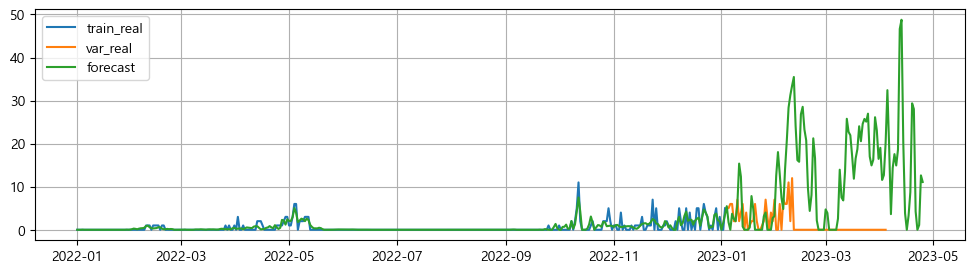

In [169]:
plt.figure(figsize=(12,3))
plt.plot(Prophet_train_0['ds'], Prophet_train_0['y'], label='train_real')## 제공된 data
plt.plot(val_data.index, val_data[0], label='var_real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')  ## Prophet이 예측한 data
plt.grid()
plt.legend()
plt.show()

## 파라미터 조정 설정

In [172]:
# 각 parameter를 바꾸어갈 값
from sklearn.model_selection import ParameterGrid

params_grid = {'changepoint_prior_scale':[0.5,0.05,0.01],  # defalt 값 0.05
               'seasonality_mode':['multiplicative','additive'],             
               }

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 6


In [174]:
from sklearn.metrics import mean_absolute_error

## MAE 하여 모델 평가

실제 정답값 예측값 차이 를 절댓값 변환후 합산하여 평균을 구한다





In [ ]:

for i in tqdm(range(15889)):#총 ID 길이 

    print(i,' 시작합니다')
    
    m_Prophet_train = Prophet()

    train_input_Prophet_sq = pd.DataFrame(train_input[i])

    train_input_Prophet  = pd.DataFrame()
    train_input_Prophet['ds'] = train_input_Prophet_sq.index
    train_input_Prophet['y'] = train_input_Prophet_sq.values
    train_input_Prophet['ds'] = pd.to_datetime(train_input_Prophet['ds'])
    
    val_data_Prophet_sq = pd.DataFrame(val_data[i])
    
    val_data_Prophet =  pd.DataFrame()
    val_data_Prophet['ds'] =val_data_Prophet_sq.index
    val_data_Prophet['y'] = val_data_Prophet_sq.values
    val_data_Prophet['ds'] = pd.to_datetime(val_data_Prophet['ds'])

    model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])

    best_mae = 99999999
    parmeter_num=0
    
    for p in grid:
                test = pd.DataFrame()
                print(p)
                #print(parmeter_num , "번째 진행중")
                random.seed(42)
                m_Prophet_train =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         seasonality_mode = p['seasonality_mode'],
                        interval_width=1)
                m_Prophet_train.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=15)
                m_Prophet_train.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
                m_Prophet_train.add_seasonality(name='weekly', period=7, fourier_order=8, prior_scale=3)
                
                m_Prophet_train.fit(train_input_Prophet)
                
                train_forecast =  m_Prophet_train.make_future_dataframe(periods=91, freq='D',include_history = False)## 4월 4일 까지 예측후 
                train_forecast =  m_Prophet_train.predict(train_forecast)
                test= train_forecast[['ds','yhat']]
                MAE = mean_absolute_error(val_data_Prophet['y'],abs(test['yhat'])) #6개의 Parmeter 중에서 가장 낮은 MAE를 선택
                print('Mean Absolute Error(MAE)------------------------------------',MAE)
                
              
                if(best_mae > MAE):
                    best_num = parmeter_num
                    best_mae = MAE
                    print(best_mae ," " , best_num,"번째가 현재 까지는 가장 좋습니다")
                    future = m_Prophet_train.make_future_dataframe(periods=112)  
                    forecast = m_Prophet_train.predict(future)
                    forecast.yhat = np.where(forecast.yhat < 0, 0, forecast.yhat) 
                parmeter_num = parmeter_num+1

    #가장 낮은 MAE 를 통해 21 예측 후 병합 작업
  
    print(best_num,"이" , best_mae,"로 가장 좋습니다")
    
    forecast_data = forecast[['ds','yhat']].round().tail(21)

    forecast_data.rename(columns={forecast_data.columns[1]: str(i)}, inplace=True)

    if(i  >= 1 ):
        merge_submit_total = pd.merge(merge_submit_total,forecast_data, on = 'ds' ,how = 'left')

    else:
        merge_submit_total = forecast_data
    
    
    
    


  0%|          | 0/15889 [00:00<?, ?it/s]

00:11:39 - cmdstanpy - INFO - Chain [1] start processing


0  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:39 - cmdstanpy - INFO - Chain [1] done processing
00:11:39 - cmdstanpy - INFO - Chain [1] start processing
00:11:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.5510961141703086
3.5510961141703086   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.3814707872633196
2.3814707872633196   1 번째가 현재 까지는 가장 좋습니다


00:11:39 - cmdstanpy - INFO - Chain [1] start processing
00:11:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.9145853085666014
1.9145853085666014   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:39 - cmdstanpy - INFO - Chain [1] start processing
00:11:40 - cmdstanpy - INFO - Chain [1] done processing
00:11:40 - cmdstanpy - INFO - Chain [1] start processing
00:11:40 - cmdstanpy - INFO - Chain [1] done processing
00:11:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.4754658619124745
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.080331578217174
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:11:40 - cmdstanpy - INFO - Chain [1] done processing
00:11:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.46668110455926
2 이 1.9145853085666014 로 가장 좋습니다
1  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:40 - cmdstanpy - INFO - Chain [1] done processing
00:11:40 - cmdstanpy - INFO - Chain [1] start processing
00:11:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.755941489303227
0.755941489303227   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7235481660890373
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:40 - cmdstanpy - INFO - Chain [1] start processing
00:11:40 - cmdstanpy - INFO - Chain [1] done processing
00:11:41 - cmdstanpy - INFO - Chain [1] start processing
00:11:41 - cmdstanpy - INFO - Chain [1] done processing
00:11:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.9867871502466494
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7649736490699375
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:41 - cmdstanpy - INFO - Chain [1] done processing
00:11:41 - cmdstanpy - INFO - Chain [1] start processing
00:11:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8615484487269284
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.728193286513229
0 이 0.755941489303227 로 가장 좋습니다
2  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:41 - cmdstanpy - INFO - Chain [1] start processing
00:11:41 - cmdstanpy - INFO - Chain [1] done processing
00:11:41 - cmdstanpy - INFO - Chain [1] start processing
00:11:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6012834088597252
0.6012834088597252   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.861663558603786
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:41 - cmdstanpy - INFO - Chain [1] start processing
00:11:42 - cmdstanpy - INFO - Chain [1] done processing
00:11:42 - cmdstanpy - INFO - Chain [1] start processing
00:11:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.597648425990884
0.597648425990884   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.7223053643817385
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:42 - cmdstanpy - INFO - Chain [1] start processing
00:11:42 - cmdstanpy - INFO - Chain [1] done processing
00:11:42 - cmdstanpy - INFO - Chain [1] start processing
00:11:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7632162419685542
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5091943542283923
2 이 0.597648425990884 로 가장 좋습니다
3  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:42 - cmdstanpy - INFO - Chain [1] start processing
00:11:42 - cmdstanpy - INFO - Chain [1] done processing
00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4152342080625684
1.4152342080625684   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.89452767200933
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:43 - cmdstanpy - INFO - Chain [1] done processing
00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7056243526881059
0.7056243526881059   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.54253928129438
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:43 - cmdstanpy - INFO - Chain [1] done processing
00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7362565449877927
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.419331083592975
2 이 0.7056243526881059 로 가장 좋습니다
4  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing
00:11:44 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 546.4388983085978
546.4388983085978   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.715079868184339
7.715079868184339   1 번째가 현재 까지는 가장 좋습니다


00:11:44 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 35.79242092440119
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:44 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing
00:11:44 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.806701753343315
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.7358353235742925
6.7358353235742925   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:11:44 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing
00:11:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.841887024660329
4 이 6.7358353235742925 로 가장 좋습니다
5  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:45 - cmdstanpy - INFO - Chain [1] done processing
00:11:45 - cmdstanpy - INFO - Chain [1] start processing
00:11:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.297450542504251
5.297450542504251   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.620174071985177
4.620174071985177   1 번째가 현재 까지는 가장 좋습니다


00:11:45 - cmdstanpy - INFO - Chain [1] start processing
00:11:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7998506451508185
1.7998506451508185   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:45 - cmdstanpy - INFO - Chain [1] start processing
00:11:45 - cmdstanpy - INFO - Chain [1] done processing
00:11:45 - cmdstanpy - INFO - Chain [1] start processing
00:11:45 - cmdstanpy - INFO - Chain [1] done processing
00:11:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.082146291565048
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5320807334754654
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:11:46 - cmdstanpy - INFO - Chain [1] done processing
00:11:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.0450081188896965
2 이 1.7998506451508185 로 가장 좋습니다
6  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:46 - cmdstanpy - INFO - Chain [1] done processing
00:11:46 - cmdstanpy - INFO - Chain [1] start processing
00:11:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011337833999744626
0.011337833999744626   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.830586280676929
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:46 - cmdstanpy - INFO - Chain [1] start processing
00:11:46 - cmdstanpy - INFO - Chain [1] done processing
00:11:46 - cmdstanpy - INFO - Chain [1] start processing
00:11:46 - cmdstanpy - INFO - Chain [1] done processing
00:11:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.04863235957020378
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.6786807723217545
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:46 - cmdstanpy - INFO - Chain [1] done processing
00:11:46 - cmdstanpy - INFO - Chain [1] start processing
00:11:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.571898678721373
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.213078818283207
0 이 0.011337833999744626 로 가장 좋습니다
7  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:47 - cmdstanpy - INFO - Chain [1] start processing
00:11:47 - cmdstanpy - INFO - Chain [1] done processing
00:11:47 - cmdstanpy - INFO - Chain [1] start processing
00:11:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.325553502434126
3.325553502434126   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.61306240211387
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:47 - cmdstanpy - INFO - Chain [1] start processing
00:11:47 - cmdstanpy - INFO - Chain [1] done processing
00:11:47 - cmdstanpy - INFO - Chain [1] start processing
00:11:47 - cmdstanpy - INFO - Chain [1] done processing
00:11:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 27.111414900631697
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 21.562814558976484
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:47 - cmdstanpy - INFO - Chain [1] done processing
00:11:47 - cmdstanpy - INFO - Chain [1] start processing
00:11:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 39.4506976057601
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.798243851283026
0 이 3.325553502434126 로 가장 좋습니다
8  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:48 - cmdstanpy - INFO - Chain [1] start processing
00:11:48 - cmdstanpy - INFO - Chain [1] done processing
00:11:48 - cmdstanpy - INFO - Chain [1] start processing
00:11:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15498635818540937
0.15498635818540937   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.7306267558241695
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:48 - cmdstanpy - INFO - Chain [1] start processing
00:11:48 - cmdstanpy - INFO - Chain [1] done processing
00:11:48 - cmdstanpy - INFO - Chain [1] start processing
00:11:48 - cmdstanpy - INFO - Chain [1] done processing
00:11:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.15510947510889855
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.3671926948819575
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:49 - cmdstanpy - INFO - Chain [1] done processing
00:11:49 - cmdstanpy - INFO - Chain [1] start processing
00:11:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.446789728135918
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.044151251913303
0 이 0.15498635818540937 로 가장 좋습니다
9  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:49 - cmdstanpy - INFO - Chain [1] start processing
00:11:49 - cmdstanpy - INFO - Chain [1] done processing
00:11:49 - cmdstanpy - INFO - Chain [1] start processing
00:11:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 76.4540914397312
76.4540914397312   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.526733329878414
9.526733329878414   1 번째가 현재 까지는 가장 좋습니다


00:11:49 - cmdstanpy - INFO - Chain [1] start processing
00:11:49 - cmdstanpy - INFO - Chain [1] done processing
00:11:49 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 16.467625421127586
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:49 - cmdstanpy - INFO - Chain [1] done processing
00:11:49 - cmdstanpy - INFO - Chain [1] start processing
00:11:49 - cmdstanpy - INFO - Chain [1] done processing
00:11:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.243399712806625
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 10.94399067411819
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:11:50 - cmdstanpy - INFO - Chain [1] done processing
00:11:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 11.42493873443992
1 이 9.526733329878414 로 가장 좋습니다
10  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:50 - cmdstanpy - INFO - Chain [1] done processing
00:11:50 - cmdstanpy - INFO - Chain [1] start processing
00:11:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0027563153916292447
0.0027563153916292447   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2936179313608941
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:50 - cmdstanpy - INFO - Chain [1] start processing
00:11:50 - cmdstanpy - INFO - Chain [1] done processing
00:11:50 - cmdstanpy - INFO - Chain [1] start processing
00:11:50 - cmdstanpy - INFO - Chain [1] done processing
00:11:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.007178720870834869
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2906030589970956
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:51 - cmdstanpy - INFO - Chain [1] done processing
00:11:51 - cmdstanpy - INFO - Chain [1] start processing
00:11:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9703410689116664
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.29796520268061727
0 이 0.0027563153916292447 로 가장 좋습니다
11  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:51 - cmdstanpy - INFO - Chain [1] start processing
00:11:51 - cmdstanpy - INFO - Chain [1] done processing
00:11:51 - cmdstanpy - INFO - Chain [1] start processing
00:11:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.699267247107063
4.699267247107063   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3217596326184775
1.3217596326184775   1 번째가 현재 까지는 가장 좋습니다


00:11:51 - cmdstanpy - INFO - Chain [1] start processing
00:11:51 - cmdstanpy - INFO - Chain [1] done processing
00:11:51 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.085995877503128
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:52 - cmdstanpy - INFO - Chain [1] done processing
00:11:52 - cmdstanpy - INFO - Chain [1] start processing
00:11:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.324600301797737
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.3727469162340256
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:11:52 - cmdstanpy - INFO - Chain [1] start processing
00:11:52 - cmdstanpy - INFO - Chain [1] done processing
00:11:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.5455706888378582
1 이 1.3217596326184775 로 가장 좋습니다
12  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:52 - cmdstanpy - INFO - Chain [1] done processing
00:11:52 - cmdstanpy - INFO - Chain [1] start processing
00:11:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.008931427667185897
0.008931427667185897   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.24766854669141733
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:52 - cmdstanpy - INFO - Chain [1] start processing
00:11:52 - cmdstanpy - INFO - Chain [1] done processing
00:11:52 - cmdstanpy - INFO - Chain [1] start processing
00:11:52 - cmdstanpy - INFO - Chain [1] done processing
00:11:53 - cmdstanpy - INFO - Chain [1] start processing
00:11:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5721728521125412
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2464450685903296
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:53 - cmdstanpy - INFO - Chain [1] start processing
00:11:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.25019763471130474
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.25497944707929526
0 이 0.008931427667185897 로 가장 좋습니다
13  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:53 - cmdstanpy - INFO - Chain [1] start processing
00:11:53 - cmdstanpy - INFO - Chain [1] done processing
00:11:53 - cmdstanpy - INFO - Chain [1] start processing
00:11:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.19822186634202005
0.19822186634202005   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.053101818378141
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:53 - cmdstanpy - INFO - Chain [1] start processing
00:11:54 - cmdstanpy - INFO - Chain [1] done processing
00:11:54 - cmdstanpy - INFO - Chain [1] start processing
00:11:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.057454924986580336
0.057454924986580336   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6799572501115345
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:54 - cmdstanpy - INFO - Chain [1] start processing
00:11:54 - cmdstanpy - INFO - Chain [1] done processing
00:11:54 - cmdstanpy - INFO - Chain [1] start processing
00:11:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.326966570632015
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.752267063152202
2 이 0.057454924986580336 로 가장 좋습니다
14  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.06593406593406594
0.06593406593406594   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06593406593406594
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.06593406593406594
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06593406593406594
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Erro

00:11:55 - cmdstanpy - INFO - Chain [1] start processing
00:11:55 - cmdstanpy - INFO - Chain [1] done processing
00:11:56 - cmdstanpy - INFO - Chain [1] start processing
00:11:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1053140926492553
2.1053140926492553   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.31826717167243035
0.31826717167243035   1 번째가 현재 까지는 가장 좋습니다


00:11:56 - cmdstanpy - INFO - Chain [1] start processing
00:11:56 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6233829100038565
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:56 - cmdstanpy - INFO - Chain [1] start processing
00:11:56 - cmdstanpy - INFO - Chain [1] done processing
00:11:56 - cmdstanpy - INFO - Chain [1] start processing
00:11:56 - cmdstanpy - INFO - Chain [1] done processing
00:11:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3211750585768105
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.45286149549990395
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:11:56 - cmdstanpy - INFO - Chain [1] done processing
00:11:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3259370117020351
1 이 0.31826717167243035 로 가장 좋습니다
17  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:56 - cmdstanpy - INFO - Chain [1] done processing
00:11:57 - cmdstanpy - INFO - Chain [1] start processing
00:11:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 84.68762292490872
84.68762292490872   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 61.891218997407464
61.891218997407464   1 번째가 현재 까지는 가장 좋습니다


00:11:57 - cmdstanpy - INFO - Chain [1] start processing
00:11:57 - cmdstanpy - INFO - Chain [1] done processing
00:11:57 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 102.14325015026226
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:11:57 - cmdstanpy - INFO - Chain [1] done processing
00:11:57 - cmdstanpy - INFO - Chain [1] start processing
00:11:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 57.730187013303215
57.730187013303215   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 33.58375015797086
33.58375015797086   4 번째가 현재 까지는 가장 좋습니다


00:11:57 - cmdstanpy - INFO - Chain [1] start processing
00:11:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.179153638382218
27.179153638382218   5 번째가 현재 까지는 가장 좋습니다
5 이 27.179153638382218 로 가장 좋습니다
18  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:57 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing
00:11:58 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 30.35629778133239
30.35629778133239   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.491347529539716
27.491347529539716   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:58 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing
00:11:58 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing
00:11:58 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 32.43810462018333
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 28.756327538998722
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:58 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 30.670890310774226
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 28.448235845882
1 이 27.491347529539716 로 가장 좋습니다
19  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:58 - cmdstanpy - INFO - Chain [1] start processing
00:11:59 - cmdstanpy - INFO - Chain [1] done processing
00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:11:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.203361141581496
2.203361141581496   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.47744290487785
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:11:59 - cmdstanpy - INFO - Chain [1] done processing
00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:11:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7148822756142654
1.7148822756142654   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.219996706568026
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:11:59 - cmdstanpy - INFO - Chain [1] done processing
00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:11:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.2247407458496262
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.801078847007641
2 이 1.7148822756142654 로 가장 좋습니다
20  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:00 - cmdstanpy - INFO - Chain [1] done processing
00:12:00 - cmdstanpy - INFO - Chain [1] start processing
00:12:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.307878605305391
2.307878605305391   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2685362550890287
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:00 - cmdstanpy - INFO - Chain [1] start processing
00:12:00 - cmdstanpy - INFO - Chain [1] done processing
00:12:00 - cmdstanpy - INFO - Chain [1] start processing
00:12:00 - cmdstanpy - INFO - Chain [1] done processing
00:12:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 5.134033763175284
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.21228090320054
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:00 - cmdstanpy - INFO - Chain [1] done processing
00:12:00 - cmdstanpy - INFO - Chain [1] start processing
00:12:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5251913829663803
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.516025546668882
0 이 2.307878605305391 로 가장 좋습니다
21  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:01 - cmdstanpy - INFO - Chain [1] start processing
00:12:01 - cmdstanpy - INFO - Chain [1] done processing
00:12:01 - cmdstanpy - INFO - Chain [1] start processing
00:12:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4394018950965991
0.4394018950965991   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08310006070134791
0.08310006070134791   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:01 - cmdstanpy - INFO - Chain [1] start processing
00:12:01 - cmdstanpy - INFO - Chain [1] done processing
00:12:01 - cmdstanpy - INFO - Chain [1] start processing
00:12:01 - cmdstanpy - INFO - Chain [1] done processing
00:12:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5076369857443589
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08328922873838304
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:01 - cmdstanpy - INFO - Chain [1] done processing
00:12:01 - cmdstanpy - INFO - Chain [1] start processing
00:12:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15067228165206345
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08428548858621987
1 이 0.08310006070134791 로 가장 좋습니다
22  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:02 - cmdstanpy - INFO - Chain [1] start processing
00:12:02 - cmdstanpy - INFO - Chain [1] done processing
00:12:02 - cmdstanpy - INFO - Chain [1] start processing
00:12:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0002460764497802097
0.0002460764497802097   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6887328915522681
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:02 - cmdstanpy - INFO - Chain [1] start processing
00:12:02 - cmdstanpy - INFO - Chain [1] done processing
00:12:02 - cmdstanpy - INFO - Chain [1] start processing
00:12:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8923216511557918
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.624820632313466
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:02 - cmdstanpy - INFO - Chain [1] start processing
00:12:03 - cmdstanpy - INFO - Chain [1] done processing
00:12:03 - cmdstanpy - INFO - Chain [1] start processing
00:12:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.934933475388962
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5767154626400155
0 이 0.0002460764497802097 로 가장 좋습니다
23  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:03 - cmdstanpy - INFO - Chain [1] start processing
00:12:03 - cmdstanpy - INFO - Chain [1] done processing
00:12:03 - cmdstanpy - INFO - Chain [1] start processing
00:12:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2042234235845244
0.2042234235845244   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.954759802069698
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:03 - cmdstanpy - INFO - Chain [1] start processing
00:12:03 - cmdstanpy - INFO - Chain [1] done processing
00:12:04 - cmdstanpy - INFO - Chain [1] start processing
00:12:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1457233906793913
0.1457233906793913   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.653189544790146
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:04 - cmdstanpy - INFO - Chain [1] start processing
00:12:04 - cmdstanpy - INFO - Chain [1] done processing
00:12:04 - cmdstanpy - INFO - Chain [1] start processing
00:12:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2082592346560297
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.7726696110605284
2 이 0.1457233906793913 로 가장 좋습니다
24  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:04 - cmdstanpy - INFO - Chain [1] start processing
00:12:04 - cmdstanpy - INFO - Chain [1] done processing
00:12:04 - cmdstanpy - INFO - Chain [1] start processing
00:12:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.2048254970193194e-05
4.2048254970193194e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3310673702486165
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:05 - cmdstanpy - INFO - Chain [1] start processing
00:12:05 - cmdstanpy - INFO - Chain [1] done processing
00:12:05 - cmdstanpy - INFO - Chain [1] start processing
00:12:05 - cmdstanpy - INFO - Chain [1] done processing
00:12:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00023466252682331046
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3306184990910457
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:05 - cmdstanpy - INFO - Chain [1] done processing
00:12:05 - cmdstanpy - INFO - Chain [1] start processing
00:12:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.04988437510882273
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.19749143417908338
0 이 4.2048254970193194e-05 로 가장 좋습니다
25  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:05 - cmdstanpy - INFO - Chain [1] start processing
00:12:06 - cmdstanpy - INFO - Chain [1] done processing
00:12:06 - cmdstanpy - INFO - Chain [1] start processing
00:12:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1495348954035729
0.1495348954035729   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3651059750414057
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:06 - cmdstanpy - INFO - Chain [1] start processing
00:12:06 - cmdstanpy - INFO - Chain [1] done processing
00:12:06 - cmdstanpy - INFO - Chain [1] start processing
00:12:06 - cmdstanpy - INFO - Chain [1] done processing
00:12:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.20478125187039842
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3613097195885356
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:06 - cmdstanpy - INFO - Chain [1] done processing
00:12:06 - cmdstanpy - INFO - Chain [1] start processing
00:12:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.14100924528937608
0.14100924528937608   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3706508307273747
4 이 0.14100924528937608 로 가장 좋습니다
26  시작합니다


00:12:06 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:07 - cmdstanpy - INFO - Chain [1] done processing
00:12:07 - cmdstanpy - INFO - Chain [1] start processing
00:12:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.08828561876155819
0.08828561876155819   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9169061982132957
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:07 - cmdstanpy - INFO - Chain [1] start processing
00:12:07 - cmdstanpy - INFO - Chain [1] done processing
00:12:07 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002066951231358643
0.002066951231358643   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6627017836049698
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:08 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing
00:12:08 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.49486079067336053
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.667150834707799
2 이 0.002066951231358643 로 가장 좋습니다
27  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:08 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing
00:12:08 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.000818088077365328
0.000818088077365328   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3162665070102289
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:08 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing
00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:09 - cmdstanpy - INFO - Chain [1] done processing
00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0054575969264103845
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3229145467297158
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.13090086175363963
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3246311994566181
0 이 0.000818088077365328 로 가장 좋습니다
28  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:09 - cmdstanpy - INFO - Chain [1] done processing
00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.24789792292162094
0.24789792292162094   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4230255040943875
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing
00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7509583426125708
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.6599191676453504
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing
00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5098803676800554
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5971284043831884
0 이 0.24789792292162094 로 가장 좋습니다
29  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing
00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.249549724427529
5.249549724427529   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.719600962826375
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing
00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.689810033088914
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.505365729902636
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing
00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.925663503333963
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.413216957954345
0 이 5.249549724427529 로 가장 좋습니다
30  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing
00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8714538510345405
0.8714538510345405   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.453265829311592
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:12 - cmdstanpy - INFO - Chain [1] done processing
00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0995194330751787
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.718968692276322
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:12 - cmdstanpy - INFO - Chain [1] done processing
00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8526082905073545
0.8526082905073545   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.729035459316846
4 이 0.8526082905073545 로 가장 좋습니다
31  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:13 - cmdstanpy - INFO - Chain [1] done processing
00:12:13 - cmdstanpy - INFO - Chain [1] start processing
00:12:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 25.785220174013993
25.785220174013993   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12711302261806914
0.12711302261806914   1 번째가 현재 까지는 가장 좋습니다


00:12:13 - cmdstanpy - INFO - Chain [1] start processing
00:12:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4333600624327465
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:13 - cmdstanpy - INFO - Chain [1] start processing
00:12:13 - cmdstanpy - INFO - Chain [1] done processing
00:12:13 - cmdstanpy - INFO - Chain [1] start processing
00:12:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06854860592006619
0.06854860592006619   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.14236875049807113
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:13 - cmdstanpy - INFO - Chain [1] start processing
00:12:13 - cmdstanpy - INFO - Chain [1] done processing
00:12:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0682269104415395
0.0682269104415395   5 번째가 현재 까지는 가장 좋습니다
5 이 0.0682269104415395 로 가장 좋습니다
32  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:14 - cmdstanpy - INFO - Chain [1] done processing
00:12:14 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 77.74934660145263
77.74934660145263   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.442664077408319
11.442664077408319   1 번째가 현재 까지는 가장 좋습니다


00:12:14 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing
00:12:14 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.718458123736212
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:14 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.835477733911238
10.835477733911238   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 10.382743970789651
10.382743970789651   4 번째가 현재 까지는 가장 좋습니다


00:12:15 - cmdstanpy - INFO - Chain [1] start processing
00:12:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.012119368465822
8.012119368465822   5 번째가 현재 까지는 가장 좋습니다
5 이 8.012119368465822 로 가장 좋습니다
33  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:15 - cmdstanpy - INFO - Chain [1] start processing
00:12:15 - cmdstanpy - INFO - Chain [1] done processing
00:12:15 - cmdstanpy - INFO - Chain [1] start processing
00:12:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0011903587339295435
0.0011903587339295435   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1265550588394353
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:15 - cmdstanpy - INFO - Chain [1] start processing
00:12:15 - cmdstanpy - INFO - Chain [1] done processing
00:12:15 - cmdstanpy - INFO - Chain [1] start processing
00:12:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12423433679692068
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.074056944881007
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:16 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing
00:12:16 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8603692531327454
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1719215710224204
0 이 0.0011903587339295435 로 가장 좋습니다
34  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:16 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing
00:12:16 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.114211111716938
1.114211111716938   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.467395946305701
0.467395946305701   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:16 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing
00:12:16 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7112684695646685
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.45977411779635446
0.45977411779635446   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing
00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2254572859467236
0.2254572859467236   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5663089696744846
4 이 0.2254572859467236 로 가장 좋습니다
35  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing
00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.142112306574915
5.142112306574915   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.732917747174362
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing
00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.803981119853875
4.803981119853875   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.596268068424878
4.596268068424878   3 번째가 현재 까지는 가장 좋습니다


00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:18 - cmdstanpy - INFO - Chain [1] done processing
00:12:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.1608491834883505
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:18 - cmdstanpy - INFO - Chain [1] done processing
00:12:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.561371357316533
4.561371357316533   5 번째가 현재 까지는 가장 좋습니다
5 이 4.561371357316533 로 가장 좋습니다
36  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:18 - cmdstanpy - INFO - Chain [1] done processing
00:12:18 - cmdstanpy - INFO - Chain [1] start processing
00:12:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.66858644639051
9.66858644639051   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.7543411244501
8.7543411244501   1 번째가 현재 까지는 가장 좋습니다


00:12:18 - cmdstanpy - INFO - Chain [1] start processing
00:12:18 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 10.86594042722901
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:18 - cmdstanpy - INFO - Chain [1] start processing
00:12:18 - cmdstanpy - INFO - Chain [1] done processing
00:12:19 - cmdstanpy - INFO - Chain [1] start processing
00:12:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.849750465048844
7.849750465048844   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 10.747349652886275
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:19 - cmdstanpy - INFO - Chain [1] start processing
00:12:19 - cmdstanpy - INFO - Chain [1] done processing
00:12:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.393966010775625
6.393966010775625   5 번째가 현재 까지는 가장 좋습니다
5 이 6.393966010775625 로 가장 좋습니다
37  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:19 - cmdstanpy - INFO - Chain [1] done processing
00:12:19 - cmdstanpy - INFO - Chain [1] start processing
00:12:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06787331614443044
0.06787331614443044   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.38511755863185737
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:19 - cmdstanpy - INFO - Chain [1] start processing
00:12:20 - cmdstanpy - INFO - Chain [1] done processing
00:12:20 - cmdstanpy - INFO - Chain [1] start processing
00:12:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7739241517118465
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3776957925208311
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:20 - cmdstanpy - INFO - Chain [1] start processing
00:12:20 - cmdstanpy - INFO - Chain [1] done processing
00:12:20 - cmdstanpy - INFO - Chain [1] start processing
00:12:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.451777035313
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3936728915446754
0 이 0.06787331614443044 로 가장 좋습니다
38  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0989010989010989
0.0989010989010989   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0989010989010989
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0989010989010989
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0989010989010989
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)--

00:12:21 - cmdstanpy - INFO - Chain [1] start processing
00:12:21 - cmdstanpy - INFO - Chain [1] done processing
00:12:21 - cmdstanpy - INFO - Chain [1] start processing
00:12:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.30264033517387e-05
8.30264033517387e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.26069065233994837
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:21 - cmdstanpy - INFO - Chain [1] start processing
00:12:21 - cmdstanpy - INFO - Chain [1] done processing
00:12:21 - cmdstanpy - INFO - Chain [1] start processing
00:12:21 - cmdstanpy - INFO - Chain [1] done processing
00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0003707933113061009
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2514340929721218
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11473097117784029
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.25586438662587035
0 이 8.30264033517387e-05 로 가장 좋습니다
40  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing
00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 163.5345705801162
163.5345705801162   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 145.8179966543814
145.8179966543814   1 번째가 현재 까지는 가장 좋습니다


00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing
00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 207.28763603883075
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:23 - cmdstanpy - INFO - Chain [1] done processing
00:12:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 183.05899616080862
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 202.76966275965648
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:23 - cmdstanpy - INFO - Chain [1] done processing
00:12:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 190.34850771333416
1 이 145.8179966543814 로 가장 좋습니다
41  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:23 - cmdstanpy - INFO - Chain [1] done processing
00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.658620334463393e-05
1.658620334463393e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09586780358412858
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:23 - cmdstanpy - INFO - Chain [1] done processing
00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing
00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0008975247332809515
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09399561562619173
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.012992794229825678
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04960470146500859
0 이 1.658620334463393e-05 로 가장 좋습니다
42  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing
00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 71.26386631854115
71.26386631854115   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 143.6735768255836
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing
00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 43.10796819186277
43.10796819186277   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 49.1840057908106
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing
00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 34.58971086628006
34.58971086628006   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 49.78525275803905
4 이 34.58971086628006 로 가장 좋습니다
43  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing
00:12:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 30.07626266986533
30.07626266986533   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:12:26 - cmdstanpy - INFO - Chain [1] done processing
00:12:26 - cmdstanpy - INFO - Chain [1] start processing
00:12:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 47.60692271304929
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 20.74155466804015
20.74155466804015   2 번째가 현재 까지는 가장 좋습니다


00:12:26 - cmdstanpy - INFO - Chain [1] start processing
00:12:26 - cmdstanpy - INFO - Chain [1] done processing
00:12:26 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.21710710656644
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:26 - cmdstanpy - INFO - Chain [1] done processing
00:12:26 - cmdstanpy - INFO - Chain [1] start processing
00:12:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.865859702302973
19.865859702302973   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 24.658719984728297
4 이 19.865859702302973 로 가장 좋습니다
44  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 11.10989010989011
11.10989010989011   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.10989010989011
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 11.10989010989011
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.10989010989011
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'mul

00:12:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.3846153846153846
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3846153846153846
0 이 1.3846153846153846 로 가장 좋습니다
46  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:27 - cmdstanpy - INFO - Chain [1] done processing
00:12:28 - cmdstanpy - INFO - Chain [1] start processing
00:12:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.764438275650995
5.764438275650995   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.058223662401614
4.058223662401614   1 번째가 현재 까지는 가장 좋습니다


00:12:28 - cmdstanpy - INFO - Chain [1] start processing
00:12:28 - cmdstanpy - INFO - Chain [1] done processing
00:12:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.928747300432356
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:28 - cmdstanpy - INFO - Chain [1] done processing
00:12:28 - cmdstanpy - INFO - Chain [1] start processing
00:12:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.356443480066914
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.6371328697479113
3.6371328697479113   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:28 - cmdstanpy - INFO - Chain [1] start processing
00:12:28 - cmdstanpy - INFO - Chain [1] done processing
00:12:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.8720017551234145
4 이 3.6371328697479113 로 가장 좋습니다
47  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:29 - cmdstanpy - INFO - Chain [1] done processing
00:12:29 - cmdstanpy - INFO - Chain [1] start processing
00:12:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 503.5261684857708
503.5261684857708   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 241.5346603794337
241.5346603794337   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:29 - cmdstanpy - INFO - Chain [1] start processing
00:12:29 - cmdstanpy - INFO - Chain [1] done processing
00:12:29 - cmdstanpy - INFO - Chain [1] start processing
00:12:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 119.19777202454277
119.19777202454277   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 221.1206781819027
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:29 - cmdstanpy - INFO - Chain [1] start processing
00:12:29 - cmdstanpy - INFO - Chain [1] done processing
00:12:29 - cmdstanpy - INFO - Chain [1] start processing
00:12:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 85.94290668523493
85.94290668523493   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 221.84742723285896
4 이 85.94290668523493 로 가장 좋습니다
48  시작합니다


00:12:30 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:30 - cmdstanpy - INFO - Chain [1] done processing
00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.36313613845385573
0.36313613845385573   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4460013587003437
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:30 - cmdstanpy - INFO - Chain [1] done processing
00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:30 - cmdstanpy - INFO - Chain [1] done processing
00:12:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.36421816536880897
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4344459492898321
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:30 - cmdstanpy - INFO - Chain [1] done processing
00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3906976477642691
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.437216828271723
0 이 0.36313613845385573 로 가장 좋습니다
49  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:31 - cmdstanpy - INFO - Chain [1] done processing
00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.229783427761678
12.229783427761678   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.2898077167948685
4.2898077167948685   1 번째가 현재 까지는 가장 좋습니다


00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.788078209371919
3.788078209371919   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:31 - cmdstanpy - INFO - Chain [1] done processing
00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:31 - cmdstanpy - INFO - Chain [1] done processing
00:12:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.362341633620472
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.448059126180608
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:32 - cmdstanpy - INFO - Chain [1] done processing
00:12:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.360483289282887
2 이 3.788078209371919 로 가장 좋습니다
50  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:32 - cmdstanpy - INFO - Chain [1] done processing
00:12:32 - cmdstanpy - INFO - Chain [1] start processing
00:12:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 104.48223163919059
104.48223163919059   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.857081651854572
6.857081651854572   1 번째가 현재 까지는 가장 좋습니다


00:12:32 - cmdstanpy - INFO - Chain [1] start processing
00:12:32 - cmdstanpy - INFO - Chain [1] done processing
00:12:33 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.837615461932513
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:33 - cmdstanpy - INFO - Chain [1] done processing
00:12:33 - cmdstanpy - INFO - Chain [1] start processing
00:12:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.399110182763255
6.399110182763255   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.0496230928976535
5.0496230928976535   4 번째가 현재 까지는 가장 좋습니다


00:12:33 - cmdstanpy - INFO - Chain [1] start processing
00:12:33 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.283084362540405
4 이 5.0496230928976535 로 가장 좋습니다
51  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:33 - cmdstanpy - INFO - Chain [1] start processing
00:12:33 - cmdstanpy - INFO - Chain [1] done processing
00:12:33 - cmdstanpy - INFO - Chain [1] start processing
00:12:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.0958384789576567
3.0958384789576567   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1165879813769504
2.1165879813769504   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:33 - cmdstanpy - INFO - Chain [1] start processing
00:12:34 - cmdstanpy - INFO - Chain [1] done processing
00:12:34 - cmdstanpy - INFO - Chain [1] start processing
00:12:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.435234217393541
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.111932282293942
2.111932282293942   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:34 - cmdstanpy - INFO - Chain [1] start processing
00:12:34 - cmdstanpy - INFO - Chain [1] done processing
00:12:34 - cmdstanpy - INFO - Chain [1] start processing
00:12:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.12185442963043
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0611556716917394
2.0611556716917394   5 번째가 현재 까지는 가장 좋습니다
5 이 2.0611556716917394 로 가장 좋습니다
52  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:34 - cmdstanpy - INFO - Chain [1] start processing
00:12:34 - cmdstanpy - INFO - Chain [1] done processing
00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0021328701485511573
0.0021328701485511573   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.02672050788733636
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:35 - cmdstanpy - INFO - Chain [1] done processing
00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0003352940747379437
0.0003352940747379437   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.014000633877961978
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:35 - cmdstanpy - INFO - Chain [1] done processing
00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.008614025486189116
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.013817772321367019
2 이 0.0003352940747379437 로 가장 좋습니다
53  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:36 - cmdstanpy - INFO - Chain [1] start processing
00:12:36 - cmdstanpy - INFO - Chain [1] done processing
00:12:36 - cmdstanpy - INFO - Chain [1] start processing
00:12:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.324530712485283
12.324530712485283   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.413137495410729
2.413137495410729   1 번째가 현재 까지는 가장 좋습니다


00:12:36 - cmdstanpy - INFO - Chain [1] start processing
00:12:36 - cmdstanpy - INFO - Chain [1] done processing
00:12:36 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.787480169400763
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:36 - cmdstanpy - INFO - Chain [1] done processing
00:12:36 - cmdstanpy - INFO - Chain [1] start processing
00:12:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0599453186917662
2.0599453186917662   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.0887094461994007
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:37 - cmdstanpy - INFO - Chain [1] done processing
00:12:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.030880176142675
2.030880176142675   5 번째가 현재 까지는 가장 좋습니다
5 이 2.030880176142675 로 가장 좋습니다
54  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:37 - cmdstanpy - INFO - Chain [1] done processing
00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 58.75770042690645
58.75770042690645   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.926718196590198
13.926718196590198   1 번째가 현재 까지는 가장 좋습니다


00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:37 - cmdstanpy - INFO - Chain [1] done processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 32.675376649386166
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:38 - cmdstanpy - INFO - Chain [1] done processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.15236299863267
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.386554781918803
6.386554781918803   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:38 - cmdstanpy - INFO - Chain [1] done processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.33778524261259
4 이 6.386554781918803 로 가장 좋습니다
55  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:38 - cmdstanpy - INFO - Chain [1] done processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06065589587529925
0.06065589587529925   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.777424561956893
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:39 - cmdstanpy - INFO - Chain [1] start processing
00:12:39 - cmdstanpy - INFO - Chain [1] done processing
00:12:39 - cmdstanpy - INFO - Chain [1] start processing
00:12:39 - cmdstanpy - INFO - Chain [1] done processing
00:12:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3793478306807092
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.837616790178147
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:39 - cmdstanpy - INFO - Chain [1] done processing
00:12:39 - cmdstanpy - INFO - Chain [1] start processing
00:12:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.986200567071381
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.216526800256725
0 이 0.06065589587529925 로 가장 좋습니다
56  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:39 - cmdstanpy - INFO - Chain [1] start processing
00:12:40 - cmdstanpy - INFO - Chain [1] done processing
00:12:40 - cmdstanpy - INFO - Chain [1] start processing
00:12:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.691533151343236
16.691533151343236   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3273170114323114
0.3273170114323114   1 번째가 현재 까지는 가장 좋습니다


00:12:40 - cmdstanpy - INFO - Chain [1] start processing
00:12:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.385589533977649
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:40 - cmdstanpy - INFO - Chain [1] start processing
00:12:40 - cmdstanpy - INFO - Chain [1] done processing
00:12:40 - cmdstanpy - INFO - Chain [1] start processing
00:12:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3100067216556954
0.3100067216556954   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.127156241321185
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:40 - cmdstanpy - INFO - Chain [1] start processing
00:12:40 - cmdstanpy - INFO - Chain [1] done processing
00:12:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.31996054154967
3 이 0.3100067216556954 로 가장 좋습니다
57  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:41 - cmdstanpy - INFO - Chain [1] done processing
00:12:41 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8222450958693471
0.8222450958693471   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8472948445517058
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:41 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing
00:12:41 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7055131221378658
0.7055131221378658   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0415494557083715
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:41 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing
00:12:42 - cmdstanpy - INFO - Chain [1] start processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.13893669422520194
0.13893669422520194   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0577076178920954
4 이 0.13893669422520194 로 가장 좋습니다
58  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:42 - cmdstanpy - INFO - Chain [1] start processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing
00:12:42 - cmdstanpy - INFO - Chain [1] start processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8023435665888248
2.8023435665888248   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17913064145602486
0.17913064145602486   1 번째가 현재 까지는 가장 좋습니다


00:12:42 - cmdstanpy - INFO - Chain [1] start processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing
00:12:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.946914670617464
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:42 - cmdstanpy - INFO - Chain [1] done processing
00:12:42 - cmdstanpy - INFO - Chain [1] start processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1781917199005796
0.1781917199005796   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.28586403894849965
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:43 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing
00:12:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.7548672877979503
3 이 0.1781917199005796 로 가장 좋습니다
59  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:43 - cmdstanpy - INFO - Chain [1] done processing
00:12:43 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2355403918834443
0.2355403918834443   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10642195479742068
0.10642195479742068   1 번째가 현재 까지는 가장 좋습니다


00:12:43 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.20708945984245647
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:43 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing
00:12:43 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10493668769868361
0.10493668769868361   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.03294705611541367
0.03294705611541367   4 번째가 현재 까지는 가장 좋습니다


00:12:44 - cmdstanpy - INFO - Chain [1] start processing
00:12:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07150395336656057
4 이 0.03294705611541367 로 가장 좋습니다
60  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:44 - cmdstanpy - INFO - Chain [1] start processing
00:12:44 - cmdstanpy - INFO - Chain [1] done processing
00:12:44 - cmdstanpy - INFO - Chain [1] start processing
00:12:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.355081572838494
5.355081572838494   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0796937952799288
1.0796937952799288   1 번째가 현재 까지는 가장 좋습니다


00:12:44 - cmdstanpy - INFO - Chain [1] start processing
00:12:44 - cmdstanpy - INFO - Chain [1] done processing
00:12:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.204269595278699
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:44 - cmdstanpy - INFO - Chain [1] done processing
00:12:45 - cmdstanpy - INFO - Chain [1] start processing
00:12:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7279325676902325
0.7279325676902325   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.1721172729341154
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:45 - cmdstanpy - INFO - Chain [1] start processing
00:12:45 - cmdstanpy - INFO - Chain [1] done processing
00:12:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.681368564957858
0.681368564957858   5 번째가 현재 까지는 가장 좋습니다
5 이 0.681368564957858 로 가장 좋습니다
61  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:45 - cmdstanpy - INFO - Chain [1] done processing
00:12:45 - cmdstanpy - INFO - Chain [1] start processing
00:12:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5997803381426157
2.5997803381426157   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8657446032661034
0.8657446032661034   1 번째가 현재 까지는 가장 좋습니다


00:12:45 - cmdstanpy - INFO - Chain [1] start processing
00:12:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.073192790453314
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:46 - cmdstanpy - INFO - Chain [1] start processing
00:12:46 - cmdstanpy - INFO - Chain [1] done processing
00:12:46 - cmdstanpy - INFO - Chain [1] start processing
00:12:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8465188644741587
0.8465188644741587   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.71210056472993
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:46 - cmdstanpy - INFO - Chain [1] start processing
00:12:46 - cmdstanpy - INFO - Chain [1] done processing
00:12:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.8797777799315453
3 이 0.8465188644741587 로 가장 좋습니다
62  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:46 - cmdstanpy - INFO - Chain [1] done processing
00:12:46 - cmdstanpy - INFO - Chain [1] start processing
00:12:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2597587345596742
0.2597587345596742   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04822571489204398
0.04822571489204398   1 번째가 현재 까지는 가장 좋습니다


00:12:46 - cmdstanpy - INFO - Chain [1] start processing
00:12:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.21701355023760519
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:47 - cmdstanpy - INFO - Chain [1] start processing
00:12:47 - cmdstanpy - INFO - Chain [1] done processing
00:12:47 - cmdstanpy - INFO - Chain [1] start processing
00:12:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0474878179416348
0.0474878179416348   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.042958585954655994
0.042958585954655994   4 번째가 현재 까지는 가장 좋습니다


00:12:47 - cmdstanpy - INFO - Chain [1] start processing
00:12:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04183101600779544
0.04183101600779544   5 번째가 현재 까지는 가장 좋습니다
5 이 0.04183101600779544 로 가장 좋습니다
63  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:47 - cmdstanpy - INFO - Chain [1] start processing
00:12:47 - cmdstanpy - INFO - Chain [1] done processing
00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00017147818400208345
0.00017147818400208345   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0385549540530583
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:48 - cmdstanpy - INFO - Chain [1] done processing
00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:48 - cmdstanpy - INFO - Chain [1] done processing
00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0012831923914088071
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03621842222583785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006588179770584265
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03846650929193991
0 이 0.00017147818400208345 로 가장 좋습니다
64  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:48 - cmdstanpy - INFO - Chain [1] done processing
00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.82576085167534e-05
9.82576085167534e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.035498115848124935
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing
00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.117585515814226e-06
8.117585515814226e-06   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.023249292542070938
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing
00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.004139755136678546
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.024714893359345538
2 이 8.117585515814226e-06 로 가장 좋습니다
65  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:50 - cmdstanpy - INFO - Chain [1] start processing
00:12:50 - cmdstanpy - INFO - Chain [1] done processing
00:12:50 - cmdstanpy - INFO - Chain [1] start processing
00:12:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0865648941943498
2.0865648941943498   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6787982060607609
0.6787982060607609   1 번째가 현재 까지는 가장 좋습니다


00:12:50 - cmdstanpy - INFO - Chain [1] start processing
00:12:50 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.4014423212321951
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:50 - cmdstanpy - INFO - Chain [1] start processing
00:12:50 - cmdstanpy - INFO - Chain [1] done processing
00:12:50 - cmdstanpy - INFO - Chain [1] start processing
00:12:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5447128245721606
0.5447128245721606   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.453647771069178
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.6513009847414553
3 이 0.5447128245721606 로 가장 좋습니다
66  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0431839901113835
1.0431839901113835   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.7438883519100057
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.214382595194551
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.427820810592999
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3305248447120368
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4522061672892788
0 이 1.0431839901113835 로 가장 좋습니다
67  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing
00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10769678486167952
0.10769678486167952   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.39301498141054536
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing
00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing
00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3634411613055417
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.47919495930429856
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.13960846901300616
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4908404208669226
0 이 0.10769678486167952 로 가장 좋습니다
68  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing
00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2116586848005815
1.2116586848005815   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.700391287638253
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing
00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4473273309382853
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.618706454463503
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing
00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.089769898806653
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.5127483417063905
0 이 1.2116586848005815 로 가장 좋습니다
69  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:54 - cmdstanpy - INFO - Chain [1] start processing
00:12:54 - cmdstanpy - INFO - Chain [1] done processing
00:12:54 - cmdstanpy - INFO - Chain [1] start processing
00:12:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.027779772742738837
0.027779772742738837   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.240315712237452
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:54 - cmdstanpy - INFO - Chain [1] start processing
00:12:54 - cmdstanpy - INFO - Chain [1] done processing
00:12:54 - cmdstanpy - INFO - Chain [1] start processing
00:12:54 - cmdstanpy - INFO - Chain [1] done processing
00:12:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.0508547277695865
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1365200945168503
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:54 - cmdstanpy - INFO - Chain [1] done processing
00:12:55 - cmdstanpy - INFO - Chain [1] start processing
00:12:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8275196106520867
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.09211217160035
0 이 0.027779772742738837 로 가장 좋습니다
70  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:55 - cmdstanpy - INFO - Chain [1] start processing
00:12:55 - cmdstanpy - INFO - Chain [1] done processing
00:12:55 - cmdstanpy - INFO - Chain [1] start processing
00:12:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.414786784902831
0.414786784902831   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.646671770389535
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:55 - cmdstanpy - INFO - Chain [1] start processing
00:12:55 - cmdstanpy - INFO - Chain [1] done processing
00:12:55 - cmdstanpy - INFO - Chain [1] start processing
00:12:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.598163658596613
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6165640519720404
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:56 - cmdstanpy - INFO - Chain [1] start processing
00:12:56 - cmdstanpy - INFO - Chain [1] done processing
00:12:56 - cmdstanpy - INFO - Chain [1] start processing
00:12:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6437601045724907
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3914340995538172
0 이 0.414786784902831 로 가장 좋습니다
71  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:56 - cmdstanpy - INFO - Chain [1] start processing
00:12:56 - cmdstanpy - INFO - Chain [1] done processing
00:12:56 - cmdstanpy - INFO - Chain [1] start processing
00:12:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.14777320274681577
0.14777320274681577   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.42828786310773576
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:57 - cmdstanpy - INFO - Chain [1] start processing
00:12:57 - cmdstanpy - INFO - Chain [1] done processing
00:12:57 - cmdstanpy - INFO - Chain [1] start processing
00:12:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006389816299757042
0.006389816299757042   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.39143718918662296
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:57 - cmdstanpy - INFO - Chain [1] start processing
00:12:57 - cmdstanpy - INFO - Chain [1] done processing
00:12:57 - cmdstanpy - INFO - Chain [1] start processing
00:12:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2736069398088533
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3872438926495494
2 이 0.006389816299757042 로 가장 좋습니다
72  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:57 - cmdstanpy - INFO - Chain [1] start processing
00:12:57 - cmdstanpy - INFO - Chain [1] done processing
00:12:58 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0018792186670676977
0.0018792186670676977   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.054542030901272305
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:12:58 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing
00:12:58 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0010246070862205295
0.0010246070862205295   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.052790665641988845
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:58 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing
00:12:58 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.010961043474855917
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.054302331820659085
2 이 0.0010246070862205295 로 가장 좋습니다
73  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:12:58 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing
00:12:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.630261219870004
5.630261219870004   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13546144734875698
0.13546144734875698   1 번째가 현재 까지는 가장 좋습니다


00:12:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.2182598169218977
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:12:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:59 - cmdstanpy - INFO - Chain [1] done processing
00:12:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06858216624430111
0.06858216624430111   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.2499056218102508
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:12:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:59 - cmdstanpy - INFO - Chain [1] done processing
00:12:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.07057341780536423
3 이 0.06858216624430111 로 가장 좋습니다
74  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:00 - cmdstanpy - INFO - Chain [1] done processing
00:13:00 - cmdstanpy - INFO - Chain [1] start processing
00:13:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.20445660472580948
0.20445660472580948   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03169037503840058
0.03169037503840058   1 번째가 현재 까지는 가장 좋습니다


00:13:00 - cmdstanpy - INFO - Chain [1] start processing
00:13:00 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0125752685903654
0.0125752685903654   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:00 - cmdstanpy - INFO - Chain [1] start processing
00:13:00 - cmdstanpy - INFO - Chain [1] done processing
00:13:00 - cmdstanpy - INFO - Chain [1] start processing
00:13:00 - cmdstanpy - INFO - Chain [1] done processing
00:13:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.03170305415154616
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.013517197329518109
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:00 - cmdstanpy - INFO - Chain [1] done processing
00:13:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0324640880503369
2 이 0.0125752685903654 로 가장 좋습니다
75  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:01 - cmdstanpy - INFO - Chain [1] done processing
00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00014567167914962483
0.00014567167914962483   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04018640611360194
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:01 - cmdstanpy - INFO - Chain [1] done processing
00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1448141391510289e-05
1.1448141391510289e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0390179852307729
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:01 - cmdstanpy - INFO - Chain [1] done processing
00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.008218666519378415
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03629723475188901
2 이 1.1448141391510289e-05 로 가장 좋습니다
76  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:02 - cmdstanpy - INFO - Chain [1] start processing
00:13:02 - cmdstanpy - INFO - Chain [1] done processing
00:13:02 - cmdstanpy - INFO - Chain [1] start processing
00:13:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07354262071304699
0.07354262071304699   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9842088493491707
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:02 - cmdstanpy - INFO - Chain [1] start processing
00:13:02 - cmdstanpy - INFO - Chain [1] done processing
00:13:02 - cmdstanpy - INFO - Chain [1] start processing
00:13:02 - cmdstanpy - INFO - Chain [1] done processing
00:13:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.331127870973007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.040491959163131
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:03 - cmdstanpy - INFO - Chain [1] done processing
00:13:03 - cmdstanpy - INFO - Chain [1] start processing
00:13:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.742218032748496
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.010005038410119
0 이 0.07354262071304699 로 가장 좋습니다
77  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.989010989010989
1.989010989010989   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.989010989010989
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.989010989010989
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.989010989010989
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)-----

00:13:03 - cmdstanpy - INFO - Chain [1] start processing
00:13:04 - cmdstanpy - INFO - Chain [1] done processing
00:13:04 - cmdstanpy - INFO - Chain [1] start processing
00:13:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.78858172344857e-05
9.78858172344857e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1853983403530083
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:04 - cmdstanpy - INFO - Chain [1] start processing
00:13:04 - cmdstanpy - INFO - Chain [1] done processing
00:13:04 - cmdstanpy - INFO - Chain [1] start processing
00:13:04 - cmdstanpy - INFO - Chain [1] done processing
00:13:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0005768018251754497
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1839224983161977
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:04 - cmdstanpy - INFO - Chain [1] done processing
00:13:04 - cmdstanpy - INFO - Chain [1] start processing
00:13:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.044474583889437154
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0682708697760953
0 이 9.78858172344857e-05 로 가장 좋습니다
79  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:05 - cmdstanpy - INFO - Chain [1] start processing
00:13:05 - cmdstanpy - INFO - Chain [1] done processing
00:13:05 - cmdstanpy - INFO - Chain [1] start processing
00:13:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.29789645435602374
0.29789645435602374   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5692460357755462
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:05 - cmdstanpy - INFO - Chain [1] start processing
00:13:05 - cmdstanpy - INFO - Chain [1] done processing
00:13:05 - cmdstanpy - INFO - Chain [1] start processing
00:13:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.21623937703372362
0.21623937703372362   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7691484160111759
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:05 - cmdstanpy - INFO - Chain [1] start processing
00:13:05 - cmdstanpy - INFO - Chain [1] done processing
00:13:06 - cmdstanpy - INFO - Chain [1] start processing
00:13:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.08676578316139671
0.08676578316139671   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8216455644749531
4 이 0.08676578316139671 로 가장 좋습니다
80  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:06 - cmdstanpy - INFO - Chain [1] start processing
00:13:06 - cmdstanpy - INFO - Chain [1] done processing
00:13:06 - cmdstanpy - INFO - Chain [1] start processing
00:13:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.78858172344857e-05
9.78858172344857e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1853983403530083
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:06 - cmdstanpy - INFO - Chain [1] start processing
00:13:06 - cmdstanpy - INFO - Chain [1] done processing
00:13:07 - cmdstanpy - INFO - Chain [1] start processing
00:13:07 - cmdstanpy - INFO - Chain [1] done processing
00:13:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0005768018251754497
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1839224983161977
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:07 - cmdstanpy - INFO - Chain [1] done processing
00:13:07 - cmdstanpy - INFO - Chain [1] start processing
00:13:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.044474583889437154
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0682708697760953
0 이 9.78858172344857e-05 로 가장 좋습니다
81  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:07 - cmdstanpy - INFO - Chain [1] start processing
00:13:07 - cmdstanpy - INFO - Chain [1] done processing
00:13:07 - cmdstanpy - INFO - Chain [1] start processing
00:13:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0013175112021971108
0.0013175112021971108   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.036068112604211056
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:08 - cmdstanpy - INFO - Chain [1] done processing
00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.437333024192266e-05
3.437333024192266e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.035347945986642516
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:08 - cmdstanpy - INFO - Chain [1] done processing
00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0032540554934826064
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03569404656867799
2 이 3.437333024192266e-05 로 가장 좋습니다
82  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:08 - cmdstanpy - INFO - Chain [1] done processing
00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.388764725038907
24.388764725038907   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.880629636542047
9.880629636542047   1 번째가 현재 까지는 가장 좋습니다


00:13:09 - cmdstanpy - INFO - Chain [1] start processing
00:13:09 - cmdstanpy - INFO - Chain [1] done processing
00:13:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 16.993112825615608
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:09 - cmdstanpy - INFO - Chain [1] done processing
00:13:09 - cmdstanpy - INFO - Chain [1] start processing
00:13:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.293529199075598
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.906915368923063
7.906915368923063   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:09 - cmdstanpy - INFO - Chain [1] start processing
00:13:09 - cmdstanpy - INFO - Chain [1] done processing
00:13:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 12.684015471623203
4 이 7.906915368923063 로 가장 좋습니다
83  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:09 - cmdstanpy - INFO - Chain [1] done processing
00:13:10 - cmdstanpy - INFO - Chain [1] start processing
00:13:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.039525990790659465
0.039525990790659465   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.685724870604934
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:10 - cmdstanpy - INFO - Chain [1] start processing
00:13:10 - cmdstanpy - INFO - Chain [1] done processing
00:13:10 - cmdstanpy - INFO - Chain [1] start processing
00:13:10 - cmdstanpy - INFO - Chain [1] done processing
00:13:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.4931083693706021
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.379578917001241
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:10 - cmdstanpy - INFO - Chain [1] done processing
00:13:10 - cmdstanpy - INFO - Chain [1] start processing
00:13:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.95899557490926
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.2586772948926956
0 이 0.039525990790659465 로 가장 좋습니다
84  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:11 - cmdstanpy - INFO - Chain [1] done processing
00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00038487171893766223
0.00038487171893766223   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3006714654332247
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:11 - cmdstanpy - INFO - Chain [1] done processing
00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:11 - cmdstanpy - INFO - Chain [1] done processing
00:13:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.2448835538217091
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3229882367136327
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:11 - cmdstanpy - INFO - Chain [1] done processing
00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.21725713153239953
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3188582107172978
0 이 0.00038487171893766223 로 가장 좋습니다
85  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing
00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.3492218916563843
2.3492218916563843   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4443833009148164
1.4443833009148164   1 번째가 현재 까지는 가장 좋습니다


00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.1709174957922746
1.1709174957922746   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing
00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1187540131323177
1.1187540131323177   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.0243361056814277
1.0243361056814277   4 번째가 현재 까지는 가장 좋습니다


00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0985213789166755
4 이 1.0243361056814277 로 가장 좋습니다
86  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:13 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing
00:13:13 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011363044941137468
0.011363044941137468   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08445637767697266
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:13 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing
00:13:13 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing
00:13:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.1299206250911504
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07964303740138874
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:13 - cmdstanpy - INFO - Chain [1] done processing
00:13:13 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09846782392431491
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08170607177772074
0 이 0.011363044941137468 로 가장 좋습니다
87  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:14 - cmdstanpy - INFO - Chain [1] start processing
00:13:14 - cmdstanpy - INFO - Chain [1] done processing
00:13:14 - cmdstanpy - INFO - Chain [1] start processing
00:13:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8031153207057863
0.8031153207057863   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12651769001937774
0.12651769001937774   1 번째가 현재 까지는 가장 좋습니다


00:13:14 - cmdstanpy - INFO - Chain [1] start processing
00:13:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.05319556483004305
0.05319556483004305   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:14 - cmdstanpy - INFO - Chain [1] start processing
00:13:14 - cmdstanpy - INFO - Chain [1] done processing
00:13:14 - cmdstanpy - INFO - Chain [1] start processing
00:13:14 - cmdstanpy - INFO - Chain [1] done processing
00:13:14 - cmdstanpy - INFO - Chain [1] start processing
00:13:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12432818797506055
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.060261685596465164
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.1306440107965312
2 이 0.05319556483004305 로 가장 좋습니다
88  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:15 - cmdstanpy - INFO - Chain [1] done processing
00:13:15 - cmdstanpy - INFO - Chain [1] start processing
00:13:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9877012984724659
0.9877012984724659   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13110965736923183
0.13110965736923183   1 번째가 현재 까지는 가장 좋습니다


00:13:15 - cmdstanpy - INFO - Chain [1] start processing
00:13:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.48325456901555813
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:15 - cmdstanpy - INFO - Chain [1] start processing
00:13:15 - cmdstanpy - INFO - Chain [1] done processing
00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1166405403957725
0.1166405403957725   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.24064733214484285
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing
00:13:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.12135211766000495
3 이 0.1166405403957725 로 가장 좋습니다
89  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:16 - cmdstanpy - INFO - Chain [1] done processing
00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.052270346559592236
0.052270346559592236   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5000414190851139
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing
00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing
00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.17367507484070346
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4485217056948104
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:17 - cmdstanpy - INFO - Chain [1] start processing
00:13:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.04573788282340104
0.04573788282340104   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4351382245495387
4 이 0.04573788282340104 로 가장 좋습니다
90  시작합니다


00:13:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:17 - cmdstanpy - INFO - Chain [1] done processing
00:13:17 - cmdstanpy - INFO - Chain [1] start processing
00:13:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.75598691605739e-05
9.75598691605739e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0341871059152101
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:17 - cmdstanpy - INFO - Chain [1] start processing
00:13:17 - cmdstanpy - INFO - Chain [1] done processing
00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0207688414278002e-05
1.0207688414278002e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.029143735421059858
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing
00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0002458857110619186
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.01902010075547769
2 이 1.0207688414278002e-05 로 가장 좋습니다
91  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing
00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.325737911392593e-05
3.325737911392593e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.29233218256427457
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:19 - cmdstanpy - INFO - Chain [1] done processing
00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0020799541188203556
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.22988156989458536
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:19 - cmdstanpy - INFO - Chain [1] done processing
00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1488271216661739
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.22328801980490207
0 이 3.325737911392593e-05 로 가장 좋습니다
92  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:19 - cmdstanpy - INFO - Chain [1] done processing
00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.519364615591633e-05
7.519364615591633e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0172741119593926
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing
00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.083645927170063e-05
3.083645927170063e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0174379266689658
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing
00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.01043668278046455
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.017516737642215195
2 이 3.083645927170063e-05 로 가장 좋습니다
93  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing
00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0010035183534635704
0.0010035183534635704   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6107278358137225
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing
00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0004310999085059841
0.0004310999085059841   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5329023946643727
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing
00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06061937759903132
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2948128180875761
2 이 0.0004310999085059841 로 가장 좋습니다
94  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:22 - cmdstanpy - INFO - Chain [1] start processing
00:13:22 - cmdstanpy - INFO - Chain [1] done processing
00:13:22 - cmdstanpy - INFO - Chain [1] start processing
00:13:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.355670962334837e-05
5.355670962334837e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.505208495259273
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:22 - cmdstanpy - INFO - Chain [1] start processing
00:13:22 - cmdstanpy - INFO - Chain [1] done processing
00:13:22 - cmdstanpy - INFO - Chain [1] start processing
00:13:22 - cmdstanpy - INFO - Chain [1] done processing
00:13:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00027372601163655556
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4914453836243925
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:23 - cmdstanpy - INFO - Chain [1] done processing
00:13:23 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09707826060651256
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.499193153993242
0 이 5.355670962334837e-05 로 가장 좋습니다
95  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:23 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing
00:13:23 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.44724095010032516
0.44724095010032516   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.22021066626665065
0.22021066626665065   1 번째가 현재 까지는 가장 좋습니다


00:13:23 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing
00:13:23 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.3579939115221515
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:23 - cmdstanpy - INFO - Chain [1] done processing
00:13:24 - cmdstanpy - INFO - Chain [1] start processing
00:13:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2193399809950858
0.2193399809950858   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.36059714140899796
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:24 - cmdstanpy - INFO - Chain [1] start processing
00:13:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7869563063425912
3 이 0.2193399809950858 로 가장 좋습니다
96  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5274725274725275
0.5274725274725275   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5274725274725275
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5274725274725275
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5274725274725275
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5274725274725275
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5274725274725275
0 이 0.5274725274725275 로 가장 좋습니다
97  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:25 - cmdstanpy - INFO - Chain [1] done processing
00:13:25 - cmdstanpy - INFO - Chain [1] start processing
00:13:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.015134222620533693
0.015134222620533693   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0728358389477868
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:25 - cmdstanpy - INFO - Chain [1] start processing
00:13:25 - cmdstanpy - INFO - Chain [1] done processing
00:13:25 - cmdstanpy - INFO - Chain [1] start processing
00:13:25 - cmdstanpy - INFO - Chain [1] done processing
00:13:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5454398736322225
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9333839415643048
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:25 - cmdstanpy - INFO - Chain [1] done processing
00:13:25 - cmdstanpy - INFO - Chain [1] start processing
00:13:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4725007938202412
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6968007532111588
0 이 0.015134222620533693 로 가장 좋습니다
98  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:25 - cmdstanpy - INFO - Chain [1] start processing
00:13:26 - cmdstanpy - INFO - Chain [1] done processing
00:13:26 - cmdstanpy - INFO - Chain [1] start processing
00:13:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.517503173697914
8.517503173697914   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.9190311056582727
3.9190311056582727   1 번째가 현재 까지는 가장 좋습니다


00:13:26 - cmdstanpy - INFO - Chain [1] start processing
00:13:26 - cmdstanpy - INFO - Chain [1] done processing
00:13:26 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 25.10000514161167
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:26 - cmdstanpy - INFO - Chain [1] done processing
00:13:26 - cmdstanpy - INFO - Chain [1] start processing
00:13:26 - cmdstanpy - INFO - Chain [1] done processing
00:13:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.142476254648079
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 32.64782985953652
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:26 - cmdstanpy - INFO - Chain [1] done processing
00:13:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.433821631690275
1 이 3.9190311056582727 로 가장 좋습니다
99  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:27 - cmdstanpy - INFO - Chain [1] done processing
00:13:27 - cmdstanpy - INFO - Chain [1] start processing
00:13:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4366431731370157
1.4366431731370157   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4831944501677294
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:27 - cmdstanpy - INFO - Chain [1] start processing
00:13:27 - cmdstanpy - INFO - Chain [1] done processing
00:13:27 - cmdstanpy - INFO - Chain [1] start processing
00:13:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4157714949175326
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6828208243479577
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:27 - cmdstanpy - INFO - Chain [1] start processing
00:13:27 - cmdstanpy - INFO - Chain [1] done processing
00:13:27 - cmdstanpy - INFO - Chain [1] start processing
00:13:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.449308084619488
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.437181232612243
0 이 1.4366431731370157 로 가장 좋습니다
100  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:27 - cmdstanpy - INFO - Chain [1] start processing
00:13:28 - cmdstanpy - INFO - Chain [1] done processing
00:13:28 - cmdstanpy - INFO - Chain [1] start processing
00:13:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.2279475027173365
4.2279475027173365   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.217044416436306
0.217044416436306   1 번째가 현재 까지는 가장 좋습니다


00:13:28 - cmdstanpy - INFO - Chain [1] start processing
00:13:28 - cmdstanpy - INFO - Chain [1] done processing
00:13:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5711784031456871
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:28 - cmdstanpy - INFO - Chain [1] done processing
00:13:28 - cmdstanpy - INFO - Chain [1] start processing
00:13:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.21289142587378007
0.21289142587378007   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5376916088824292
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:28 - cmdstanpy - INFO - Chain [1] start processing
00:13:28 - cmdstanpy - INFO - Chain [1] done processing
00:13:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.216458386011344
3 이 0.21289142587378007 로 가장 좋습니다
101  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:29 - cmdstanpy - INFO - Chain [1] done processing
00:13:29 - cmdstanpy - INFO - Chain [1] start processing
00:13:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.606340916300123
2.606340916300123   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 70.50403554027697
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:29 - cmdstanpy - INFO - Chain [1] start processing
00:13:29 - cmdstanpy - INFO - Chain [1] done processing
00:13:29 - cmdstanpy - INFO - Chain [1] start processing
00:13:29 - cmdstanpy - INFO - Chain [1] done processing
00:13:29 - cmdstanpy - INFO - Chain [1] start processing
00:13:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.199497340441363
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 70.57806570592084
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:29 - cmdstanpy - INFO - Chain [1] start processing
00:13:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.7449170262849005
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 68.32281421939147
0 이 2.606340916300123 로 가장 좋습니다
102  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing
00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.560486149959312
8.560486149959312   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.977723566437751
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing
00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.527918800491626
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.495717471799306
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing
00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.367107360524324
8.367107360524324   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.977145198341299
7.977145198341299   5 번째가 현재 까지는 가장 좋습니다


00:13:31 - cmdstanpy - INFO - Chain [1] start processing


5 이 7.977145198341299 로 가장 좋습니다
103  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:31 - cmdstanpy - INFO - Chain [1] done processing
00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9527947557393536
0.9527947557393536   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5078610701932682
0.5078610701932682   1 번째가 현재 까지는 가장 좋습니다


00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.1869714800711824
0.1869714800711824   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:31 - cmdstanpy - INFO - Chain [1] done processing
00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5033866740510035
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.07738002322372971
0.07738002322372971   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:32 - cmdstanpy - INFO - Chain [1] start processing
00:13:32 - cmdstanpy - INFO - Chain [1] done processing
00:13:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.6108808237594539
4 이 0.07738002322372971 로 가장 좋습니다
104  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:32 - cmdstanpy - INFO - Chain [1] done processing
00:13:32 - cmdstanpy - INFO - Chain [1] start processing
00:13:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0005531960423392011
0.0005531960423392011   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.219587373977707
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:32 - cmdstanpy - INFO - Chain [1] start processing
00:13:32 - cmdstanpy - INFO - Chain [1] done processing
00:13:32 - cmdstanpy - INFO - Chain [1] start processing
00:13:32 - cmdstanpy - INFO - Chain [1] done processing
00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4857347882682744
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.0987343370419635
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7330144620586343
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.096239054525336
0 이 0.0005531960423392011 로 가장 좋습니다
105  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing
00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.029269767569001893
0.029269767569001893   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.477198586320574
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing
00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0307996495733704
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.0774898736939944
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:34 - cmdstanpy - INFO - Chain [1] done processing
00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6292358515192273
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.526948595436605
0 이 0.029269767569001893 로 가장 좋습니다
106  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:34 - cmdstanpy - INFO - Chain [1] done processing
00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.010139409389463913
0.010139409389463913   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.318800972057767
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing
00:13:35 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0036492502461530785
0.0036492502461530785   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.258438756589558
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:35 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing
00:13:35 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.966301380578117
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.179187409441081
2 이 0.0036492502461530785 로 가장 좋습니다
107  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:35 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing
00:13:35 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.9626318671171417
3.9626318671171417   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9133141285890427
0.9133141285890427   1 번째가 현재 까지는 가장 좋습니다


00:13:36 - cmdstanpy - INFO - Chain [1] start processing
00:13:36 - cmdstanpy - INFO - Chain [1] done processing
00:13:36 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7302981295278326
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:36 - cmdstanpy - INFO - Chain [1] done processing
00:13:36 - cmdstanpy - INFO - Chain [1] start processing
00:13:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.995914796132901
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.4968488901315995
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:36 - cmdstanpy - INFO - Chain [1] start processing
00:13:36 - cmdstanpy - INFO - Chain [1] done processing
00:13:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.0149306041506212
1 이 0.9133141285890427 로 가장 좋습니다
108  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:36 - cmdstanpy - INFO - Chain [1] done processing
00:13:36 - cmdstanpy - INFO - Chain [1] start processing
00:13:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.943287406794756
1.943287406794756   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4546914261825076
0.4546914261825076   1 번째가 현재 까지는 가장 좋습니다


00:13:37 - cmdstanpy - INFO - Chain [1] start processing
00:13:37 - cmdstanpy - INFO - Chain [1] done processing
00:13:37 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.456976147248672
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:37 - cmdstanpy - INFO - Chain [1] done processing
00:13:37 - cmdstanpy - INFO - Chain [1] start processing
00:13:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.22544835024051568
0.22544835024051568   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.30790989752343767
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:37 - cmdstanpy - INFO - Chain [1] start processing
00:13:37 - cmdstanpy - INFO - Chain [1] done processing
00:13:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.22665499134789793
3 이 0.22544835024051568 로 가장 좋습니다
109  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:37 - cmdstanpy - INFO - Chain [1] done processing
00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.022670607397548205
0.022670607397548205   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2678768226835826
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing
00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing
00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1847011780074113
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.24023243312494275
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4032235263508796
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23168330010831878
0 이 0.022670607397548205 로 가장 좋습니다
110  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing
00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 290.37165184219884
290.37165184219884   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.885373839267036
27.885373839267036   1 번째가 현재 까지는 가장 좋습니다


00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing
00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 29.303518320119284
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 28.10246102968724
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 26.898660748878523
26.898660748878523   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing
00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 30.618277869140964
4 이 26.898660748878523 로 가장 좋습니다
111  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.922252146993815
14.922252146993815   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1833086021448516
2.1833086021448516   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing
00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.467599662126634
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.121663233174052
2.121663233174052   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing
00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.769223476535334
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1405233933916787
3 이 2.121663233174052 로 가장 좋습니다
112  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing
00:13:41 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.531302213133388
0.531302213133388   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4456854734788231
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:41 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing
00:13:41 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing
00:13:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.8394735399639718
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2170575577592575
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:41 - cmdstanpy - INFO - Chain [1] done processing
00:13:41 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4795168034510295
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1808343459395996
0 이 0.531302213133388 로 가장 좋습니다
113  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:41 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing
00:13:42 - cmdstanpy - INFO - Chain [1] start processing
00:13:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6574442623490859
0.6574442623490859   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9485497593084204
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:42 - cmdstanpy - INFO - Chain [1] start processing
00:13:42 - cmdstanpy - INFO - Chain [1] done processing
00:13:42 - cmdstanpy - INFO - Chain [1] start processing
00:13:42 - cmdstanpy - INFO - Chain [1] done processing
00:13:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.4721065996970335
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.467872226724186
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:42 - cmdstanpy - INFO - Chain [1] done processing
00:13:42 - cmdstanpy - INFO - Chain [1] start processing
00:13:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.800862552108971
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.306899003856221
0 이 0.6574442623490859 로 가장 좋습니다
114  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.07692307692307693
0.07692307692307693   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07692307692307693
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.07692307692307693
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07692307692307693
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error

00:13:43 - cmdstanpy - INFO - Chain [1] start processing
00:13:43 - cmdstanpy - INFO - Chain [1] done processing
00:13:43 - cmdstanpy - INFO - Chain [1] start processing
00:13:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1387972043662256
1.1387972043662256   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9732519811000733
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:43 - cmdstanpy - INFO - Chain [1] start processing
00:13:43 - cmdstanpy - INFO - Chain [1] done processing
00:13:43 - cmdstanpy - INFO - Chain [1] start processing
00:13:43 - cmdstanpy - INFO - Chain [1] done processing
00:13:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.1245370813200153
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.10075363996054
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:44 - cmdstanpy - INFO - Chain [1] done processing
00:13:44 - cmdstanpy - INFO - Chain [1] start processing
00:13:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.382508606601598
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.120840284427536
0 이 1.1387972043662256 로 가장 좋습니다
116  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:44 - cmdstanpy - INFO - Chain [1] start processing
00:13:44 - cmdstanpy - INFO - Chain [1] done processing
00:13:44 - cmdstanpy - INFO - Chain [1] start processing
00:13:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.4843170127320775
4.4843170127320775   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8129567242247226
1.8129567242247226   1 번째가 현재 까지는 가장 좋습니다


00:13:44 - cmdstanpy - INFO - Chain [1] start processing
00:13:44 - cmdstanpy - INFO - Chain [1] done processing
00:13:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.529876621915886
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:45 - cmdstanpy - INFO - Chain [1] done processing
00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7222721675167656
1.7222721675167656   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.141878297545173
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing
00:13:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.717671128902066
1.717671128902066   5 번째가 현재 까지는 가장 좋습니다
5 이 1.717671128902066 로 가장 좋습니다
117  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:45 - cmdstanpy - INFO - Chain [1] done processing
00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.84306233778498
19.84306233778498   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.9693850278253455
7.9693850278253455   1 번째가 현재 까지는 가장 좋습니다


00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing
00:13:46 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.773433536751291
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:46 - cmdstanpy - INFO - Chain [1] done processing
00:13:46 - cmdstanpy - INFO - Chain [1] start processing
00:13:46 - cmdstanpy - INFO - Chain [1] done processing
00:13:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.258336549248794
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.659319476605045
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:46 - cmdstanpy - INFO - Chain [1] done processing
00:13:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.36323234809785
1 이 7.9693850278253455 로 가장 좋습니다
118  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:46 - cmdstanpy - INFO - Chain [1] done processing
00:13:46 - cmdstanpy - INFO - Chain [1] start processing
00:13:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8494476228111631
1.8494476228111631   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4154036086789272
1.4154036086789272   1 번째가 현재 까지는 가장 좋습니다


00:13:47 - cmdstanpy - INFO - Chain [1] start processing
00:13:47 - cmdstanpy - INFO - Chain [1] done processing
00:13:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.935104932920205
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:47 - cmdstanpy - INFO - Chain [1] done processing
00:13:47 - cmdstanpy - INFO - Chain [1] start processing
00:13:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1905536599037843
1.1905536599037843   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.199569379207039
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:47 - cmdstanpy - INFO - Chain [1] start processing
00:13:47 - cmdstanpy - INFO - Chain [1] done processing
00:13:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.1896678466850674
1.1896678466850674   5 번째가 현재 까지는 가장 좋습니다
5 이 1.1896678466850674 로 가장 좋습니다
119  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:47 - cmdstanpy - INFO - Chain [1] done processing
00:13:47 - cmdstanpy - INFO - Chain [1] start processing
00:13:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.589147773091397
4.589147773091397   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.338014559213304
4.338014559213304   1 번째가 현재 까지는 가장 좋습니다


00:13:48 - cmdstanpy - INFO - Chain [1] start processing
00:13:48 - cmdstanpy - INFO - Chain [1] done processing
00:13:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.415121393002568
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:48 - cmdstanpy - INFO - Chain [1] done processing
00:13:48 - cmdstanpy - INFO - Chain [1] start processing
00:13:48 - cmdstanpy - INFO - Chain [1] done processing
00:13:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.6279533813296565
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.3400848207132565
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:13:48 - cmdstanpy - INFO - Chain [1] done processing
00:13:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.81066673088854
1 이 4.338014559213304 로 가장 좋습니다
120  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:48 - cmdstanpy - INFO - Chain [1] done processing
00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.490909446644834
5.490909446644834   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.887681360651417
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:49 - cmdstanpy - INFO - Chain [1] done processing
00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:49 - cmdstanpy - INFO - Chain [1] done processing
00:13:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.349079263348619
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.616778530594428
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:49 - cmdstanpy - INFO - Chain [1] done processing
00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.150754049630747
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.653142890638411
0 이 5.490909446644834 로 가장 좋습니다
121  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing
00:13:50 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.739855552085997
6.739855552085997   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.018639227101841
5.018639227101841   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:50 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing
00:13:50 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7011476357774047
3.7011476357774047   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.6775597253849375
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:50 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing
00:13:50 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.372748050748342
3.372748050748342   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.760254863119869
2.760254863119869   5 번째가 현재 까지는 가장 좋습니다


00:13:51 - cmdstanpy - INFO - Chain [1] start processing


5 이 2.760254863119869 로 가장 좋습니다
122  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:51 - cmdstanpy - INFO - Chain [1] done processing
00:13:51 - cmdstanpy - INFO - Chain [1] start processing
00:13:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8470139014518249
0.8470139014518249   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2267053923438294
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:51 - cmdstanpy - INFO - Chain [1] start processing
00:13:51 - cmdstanpy - INFO - Chain [1] done processing
00:13:51 - cmdstanpy - INFO - Chain [1] start processing
00:13:51 - cmdstanpy - INFO - Chain [1] done processing
00:13:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.9000860016477863
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.6264888201158247
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:51 - cmdstanpy - INFO - Chain [1] done processing
00:13:51 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.7494068443169692
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.563215399225914
0 이 0.8470139014518249 로 가장 좋습니다
123  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing
00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.673851499471949
1.673851499471949   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.140992506297812
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing
00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing
00:13:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.6858223456758803
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.906754281922023
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:52 - cmdstanpy - INFO - Chain [1] done processing
00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4508427453480808
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.0861629560054062
0 이 1.673851499471949 로 가장 좋습니다
124  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing
00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.693578473923829
3.693578473923829   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.815601757712632
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing
00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.505121061814598
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.3641378216976037
3.3641378216976037   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing
00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.528034871889119
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2669782761316655
3.2669782761316655   5 번째가 현재 까지는 가장 좋습니다
5 이 3.2669782761316655 로 가장 좋습니다
125  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:54 - cmdstanpy - INFO - Chain [1] start processing
00:13:54 - cmdstanpy - INFO - Chain [1] done processing
00:13:54 - cmdstanpy - INFO - Chain [1] start processing
00:13:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.03121566684668233
0.03121566684668233   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13818291425983562
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:54 - cmdstanpy - INFO - Chain [1] start processing
00:13:54 - cmdstanpy - INFO - Chain [1] done processing
00:13:54 - cmdstanpy - INFO - Chain [1] start processing
00:13:54 - cmdstanpy - INFO - Chain [1] done processing
00:13:54 - cmdstanpy - INFO - Chain [1] start processing
00:13:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.20251968957318264
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14233397607531484
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1333690337715907
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14374293773100583
0 이 0.03121566684668233 로 가장 좋습니다
126  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:55 - cmdstanpy - INFO - Chain [1] done processing
00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.03692184178897435
0.03692184178897435   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0951686104035366
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:55 - cmdstanpy - INFO - Chain [1] done processing
00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02836202272236517
0.02836202272236517   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08927990644501088
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:56 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing
00:13:56 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0362608587902567
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09161858686919472
2 이 0.02836202272236517 로 가장 좋습니다
127  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:56 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing
00:13:56 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011886818705571702
0.011886818705571702   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.28995502629299963
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:56 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing
00:13:56 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing
00:13:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.2562045369353085
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13032126269513786
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:57 - cmdstanpy - INFO - Chain [1] done processing
00:13:57 - cmdstanpy - INFO - Chain [1] start processing
00:13:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.31570928051447245
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13170424955683405
0 이 0.011886818705571702 로 가장 좋습니다
128  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:57 - cmdstanpy - INFO - Chain [1] start processing
00:13:57 - cmdstanpy - INFO - Chain [1] done processing
00:13:57 - cmdstanpy - INFO - Chain [1] start processing
00:13:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6293041114073654
1.6293041114073654   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2708876620940969
0.2708876620940969   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:13:58 - cmdstanpy - INFO - Chain [1] start processing
00:13:58 - cmdstanpy - INFO - Chain [1] done processing
00:13:58 - cmdstanpy - INFO - Chain [1] start processing
00:13:58 - cmdstanpy - INFO - Chain [1] done processing
00:13:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.9773461958304261
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.27917306571811373
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:13:58 - cmdstanpy - INFO - Chain [1] done processing
00:13:58 - cmdstanpy - INFO - Chain [1] start processing
00:13:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5995482365403848
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2885285898910199
1 이 0.2708876620940969 로 가장 좋습니다
129  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:13:58 - cmdstanpy - INFO - Chain [1] start processing
00:13:58 - cmdstanpy - INFO - Chain [1] done processing
00:13:58 - cmdstanpy - INFO - Chain [1] start processing
00:13:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.3812523159040344
3.3812523159040344   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.180790494427303
1.180790494427303   1 번째가 현재 까지는 가장 좋습니다


00:13:59 - cmdstanpy - INFO - Chain [1] start processing
00:13:59 - cmdstanpy - INFO - Chain [1] done processing
00:13:59 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.3932931116197735
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:13:59 - cmdstanpy - INFO - Chain [1] done processing
00:13:59 - cmdstanpy - INFO - Chain [1] start processing
00:13:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1104414709092592
1.1104414709092592   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7682389211869634
0.7682389211869634   4 번째가 현재 까지는 가장 좋습니다


00:13:59 - cmdstanpy - INFO - Chain [1] start processing
00:13:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6821516034121958
0.6821516034121958   5 번째가 현재 까지는 가장 좋습니다
5 이 0.6821516034121958 로 가장 좋습니다
130  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.912087912087912
3.912087912087912   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.912087912087912
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.912087912087912
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.912087912087912
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.91

00:14:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.912087912087912
0 이 3.912087912087912 로 가장 좋습니다
131  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:00 - cmdstanpy - INFO - Chain [1] done processing
00:14:00 - cmdstanpy - INFO - Chain [1] start processing
00:14:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.7082134549419745
5.7082134549419745   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.6458086128618445
5.6458086128618445   1 번째가 현재 까지는 가장 좋습니다


00:14:00 - cmdstanpy - INFO - Chain [1] start processing
00:14:00 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.865631946907982
4.865631946907982   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:00 - cmdstanpy - INFO - Chain [1] start processing
00:14:00 - cmdstanpy - INFO - Chain [1] done processing
00:14:01 - cmdstanpy - INFO - Chain [1] start processing
00:14:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.686323058991774
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.124771808553452
4.124771808553452   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:01 - cmdstanpy - INFO - Chain [1] start processing
00:14:01 - cmdstanpy - INFO - Chain [1] done processing
00:14:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.237206973070685
4 이 4.124771808553452 로 가장 좋습니다
132  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:01 - cmdstanpy - INFO - Chain [1] done processing
00:14:01 - cmdstanpy - INFO - Chain [1] start processing
00:14:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9978635603817997
0.9978635603817997   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.798168324881841
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:01 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing
00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.119395918593768
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.422310002705531
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing
00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2895791862962762
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.162524250447338
0 이 0.9978635603817997 로 가장 좋습니다
133  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing
00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.000976025417401
4.000976025417401   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.104518389471908
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:02 - cmdstanpy - INFO - Chain [1] done processing
00:14:03 - cmdstanpy - INFO - Chain [1] start processing
00:14:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7744848585936115
3.7744848585936115   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.3369024261765605
3.3369024261765605   3 번째가 현재 까지는 가장 좋습니다


00:14:03 - cmdstanpy - INFO - Chain [1] start processing
00:14:03 - cmdstanpy - INFO - Chain [1] done processing
00:14:03 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.6168875062959223
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:03 - cmdstanpy - INFO - Chain [1] done processing
00:14:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.2453987950143173
3.2453987950143173   5 번째가 현재 까지는 가장 좋습니다
5 이 3.2453987950143173 로 가장 좋습니다
134  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:03 - cmdstanpy - INFO - Chain [1] done processing
00:14:03 - cmdstanpy - INFO - Chain [1] start processing
00:14:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00014985165686385695
0.00014985165686385695   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03351967953643188
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:04 - cmdstanpy - INFO - Chain [1] start processing
00:14:04 - cmdstanpy - INFO - Chain [1] done processing
00:14:04 - cmdstanpy - INFO - Chain [1] start processing
00:14:04 - cmdstanpy - INFO - Chain [1] done processing
00:14:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.021067153147489234
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.028296302087896526
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:04 - cmdstanpy - INFO - Chain [1] done processing
00:14:04 - cmdstanpy - INFO - Chain [1] start processing
00:14:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.018912727993803235
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.029160499400033842
0 이 0.00014985165686385695 로 가장 좋습니다
135  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:04 - cmdstanpy - INFO - Chain [1] start processing
00:14:04 - cmdstanpy - INFO - Chain [1] done processing
00:14:04 - cmdstanpy - INFO - Chain [1] start processing
00:14:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.60237396565655
9.60237396565655   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.859938529057265
4.859938529057265   1 번째가 현재 까지는 가장 좋습니다


00:14:05 - cmdstanpy - INFO - Chain [1] start processing
00:14:05 - cmdstanpy - INFO - Chain [1] done processing
00:14:05 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.402392215951523
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:05 - cmdstanpy - INFO - Chain [1] done processing
00:14:05 - cmdstanpy - INFO - Chain [1] start processing
00:14:05 - cmdstanpy - INFO - Chain [1] done processing
00:14:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.917157683196658
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.362760343547929
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:05 - cmdstanpy - INFO - Chain [1] done processing
00:14:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.929989725001179
1 이 4.859938529057265 로 가장 좋습니다
136  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:05 - cmdstanpy - INFO - Chain [1] done processing
00:14:05 - cmdstanpy - INFO - Chain [1] start processing
00:14:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.120567762335302
10.120567762335302   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3473228051051782
0.3473228051051782   1 번째가 현재 까지는 가장 좋습니다


00:14:06 - cmdstanpy - INFO - Chain [1] start processing
00:14:06 - cmdstanpy - INFO - Chain [1] done processing
00:14:06 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.0703110989568967
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:06 - cmdstanpy - INFO - Chain [1] done processing
00:14:06 - cmdstanpy - INFO - Chain [1] start processing
00:14:06 - cmdstanpy - INFO - Chain [1] done processing
00:14:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3568348709219707
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.9370036555534289
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:06 - cmdstanpy - INFO - Chain [1] done processing
00:14:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.17617491913396574
0.17617491913396574   5 번째가 현재 까지는 가장 좋습니다
5 이 0.17617491913396574 로 가장 좋습니다
137  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:06 - cmdstanpy - INFO - Chain [1] done processing
00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:14:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.069200545664583
4.069200545664583   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.29619432505699317
0.29619432505699317   1 번째가 현재 까지는 가장 좋습니다


00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:14:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.408978390512604
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:14:07 - cmdstanpy - INFO - Chain [1] done processing
00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:14:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2672123285468004
0.2672123285468004   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6458626496555994
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:14:07 - cmdstanpy - INFO - Chain [1] done processing
00:14:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5685345239594746
3 이 0.2672123285468004 로 가장 좋습니다
138  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:08 - cmdstanpy - INFO - Chain [1] done processing
00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.9223917988491372
2.9223917988491372   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2846398175470264
1.2846398175470264   1 번째가 현재 까지는 가장 좋습니다


00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4845994639509743
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing
00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing
00:14:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.2851780726470947
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8238122276645063
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:08 - cmdstanpy - INFO - Chain [1] done processing
00:14:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.2817853923787357
1.2817853923787357   5 번째가 현재 까지는 가장 좋습니다
5 이 1.2817853923787357 로 가장 좋습니다
139  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:09 - cmdstanpy - INFO - Chain [1] done processing
00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.080150121251465
15.080150121251465   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9131593449250457
1.9131593449250457   1 번째가 현재 까지는 가장 좋습니다


00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.150071994076425
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing
00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing
00:14:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.9379885411295008
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.773049564089585
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:10 - cmdstanpy - INFO - Chain [1] done processing
00:14:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.726691722587663
1 이 1.9131593449250457 로 가장 좋습니다
140  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:10 - cmdstanpy - INFO - Chain [1] done processing
00:14:10 - cmdstanpy - INFO - Chain [1] start processing
00:14:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 36.99442568326486
36.99442568326486   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.410006073070594
19.410006073070594   1 번째가 현재 까지는 가장 좋습니다


00:14:10 - cmdstanpy - INFO - Chain [1] start processing
00:14:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 18.035949260212448
18.035949260212448   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:10 - cmdstanpy - INFO - Chain [1] start processing
00:14:10 - cmdstanpy - INFO - Chain [1] done processing
00:14:10 - cmdstanpy - INFO - Chain [1] start processing
00:14:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.382588740522845
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 17.56973306883529
17.56973306883529   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:11 - cmdstanpy - INFO - Chain [1] done processing
00:14:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 19.36350951430723
4 이 17.56973306883529 로 가장 좋습니다
141  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:11 - cmdstanpy - INFO - Chain [1] done processing
00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 22.029247725438037
22.029247725438037   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.46422971656942
17.46422971656942   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:11 - cmdstanpy - INFO - Chain [1] done processing
00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.349218813139156
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.543196093622136
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:12 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing
00:14:12 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 20.91224726629203
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.54812776621526
1 이 17.46422971656942 로 가장 좋습니다
142  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.120879120879121
1.120879120879121   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.120879120879121
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.120879120879121
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.120879120879121
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------

00:14:13 - cmdstanpy - INFO - Chain [1] start processing
00:14:13 - cmdstanpy - INFO - Chain [1] done processing
00:14:13 - cmdstanpy - INFO - Chain [1] start processing
00:14:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.169184762580921
1.169184762580921   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.795040748872441
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:13 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.003979386895374
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.899556197769563
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.865930767101288
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.319400249430373
0 이 1.169184762580921 로 가장 좋습니다
145  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 489.9152555598376
489.9152555598376   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 45.38711364521815
45.38711364521815   1 번째가 현재 까지는 가장 좋습니다


00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 109.86005304425515
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 45.485167098461474
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 78.16370179425907
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 48.602687969021666
1 이 45.38711364521815 로 가장 좋습니다
146  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.809094561553227
18.809094561553227   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.9136887517381
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing
00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.976719858898473
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.507910324852947
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing
00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.052428195605536
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.546334746155324
0 이 18.809094561553227 로 가장 좋습니다
147  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing
00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.5260570526422255
4.5260570526422255   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.09775693862866
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing
00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3801042206997691
1.3801042206997691   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.124770503250753
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing
00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6807189853562647
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.050252951279056
2 이 1.3801042206997691 로 가장 좋습니다
148  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing
00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 89.79218169375481
89.79218169375481   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.69189067460359
12.69189067460359   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:18 - cmdstanpy - INFO - Chain [1] start processing
00:14:18 - cmdstanpy - INFO - Chain [1] done processing
00:14:18 - cmdstanpy - INFO - Chain [1] start processing
00:14:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 77.84752860103644
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.508893548746421
11.508893548746421   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:18 - cmdstanpy - INFO - Chain [1] start processing
00:14:18 - cmdstanpy - INFO - Chain [1] done processing
00:14:18 - cmdstanpy - INFO - Chain [1] start processing
00:14:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.060653324206056
10.060653324206056   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.495803626593917
4 이 10.060653324206056 로 가장 좋습니다
149  시작합니다


00:14:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:18 - cmdstanpy - INFO - Chain [1] done processing
00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7073319459515406
3.7073319459515406   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.178333543292474
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing
00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.4408796671710884
3.4408796671710884   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.674416070624859
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing
00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.6747933733186824
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.609226518081425
2 이 3.4408796671710884 로 가장 좋습니다
150  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:20 - cmdstanpy - INFO - Chain [1] done processing
00:14:20 - cmdstanpy - INFO - Chain [1] start processing
00:14:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.36281426532822
11.36281426532822   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.226434479794095
11.226434479794095   1 번째가 현재 까지는 가장 좋습니다


00:14:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:20 - cmdstanpy - INFO - Chain [1] done processing
00:14:20 - cmdstanpy - INFO - Chain [1] start processing
00:14:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.786811680065449
7.786811680065449   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.060878482930704
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:20 - cmdstanpy - INFO - Chain [1] start processing
00:14:20 - cmdstanpy - INFO - Chain [1] done processing
00:14:20 - cmdstanpy - INFO - Chain [1] start processing
00:14:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.074365825197487
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.96037488332522
2 이 7.786811680065449 로 가장 좋습니다
151  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:21 - cmdstanpy - INFO - Chain [1] start processing
00:14:21 - cmdstanpy - INFO - Chain [1] done processing
00:14:21 - cmdstanpy - INFO - Chain [1] start processing
00:14:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.28403872354248
13.28403872354248   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.52291176543151
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:21 - cmdstanpy - INFO - Chain [1] start processing
00:14:21 - cmdstanpy - INFO - Chain [1] done processing
00:14:21 - cmdstanpy - INFO - Chain [1] start processing
00:14:21 - cmdstanpy - INFO - Chain [1] done processing
00:14:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 29.88327806310101
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.732988626988393
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:22 - cmdstanpy - INFO - Chain [1] done processing
00:14:22 - cmdstanpy - INFO - Chain [1] start processing
00:14:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.843273362867663
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.93043151369391
0 이 13.28403872354248 로 가장 좋습니다
152  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:22 - cmdstanpy - INFO - Chain [1] start processing
00:14:22 - cmdstanpy - INFO - Chain [1] done processing
00:14:22 - cmdstanpy - INFO - Chain [1] start processing
00:14:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6027325720656085
0.6027325720656085   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.280944504439926
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:22 - cmdstanpy - INFO - Chain [1] start processing
00:14:22 - cmdstanpy - INFO - Chain [1] done processing
00:14:23 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.29824217627898164
0.29824217627898164   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.36731241113539
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:23 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing
00:14:23 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6808113958045627
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.100665867888429
2 이 0.29824217627898164 로 가장 좋습니다
153  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:23 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing
00:14:23 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02908914725601923
0.02908914725601923   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4164014597488104
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:24 - cmdstanpy - INFO - Chain [1] start processing
00:14:24 - cmdstanpy - INFO - Chain [1] done processing
00:14:24 - cmdstanpy - INFO - Chain [1] start processing
00:14:24 - cmdstanpy - INFO - Chain [1] done processing
00:14:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.1527657833659788
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5093428321394255
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:24 - cmdstanpy - INFO - Chain [1] done processing
00:14:24 - cmdstanpy - INFO - Chain [1] start processing
00:14:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6953904488467721
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.115828513759819
0 이 0.02908914725601923 로 가장 좋습니다
154  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:24 - cmdstanpy - INFO - Chain [1] start processing
00:14:24 - cmdstanpy - INFO - Chain [1] done processing
00:14:24 - cmdstanpy - INFO - Chain [1] start processing
00:14:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.576059679675882
5.576059679675882   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8842004124073866
1.8842004124073866   1 번째가 현재 까지는 가장 좋습니다


00:14:25 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:25 - cmdstanpy - INFO - Chain [1] done processing
00:14:25 - cmdstanpy - INFO - Chain [1] start processing
00:14:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.117718002954108
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1276976462669472
1.1276976462669472   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:25 - cmdstanpy - INFO - Chain [1] start processing
00:14:25 - cmdstanpy - INFO - Chain [1] done processing
00:14:25 - cmdstanpy - INFO - Chain [1] start processing
00:14:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4261184058368777
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.112213798818707
1.112213798818707   5 번째가 현재 까지는 가장 좋습니다
5 이 1.112213798818707 로 가장 좋습니다
155  시작합니다


00:14:25 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:26 - cmdstanpy - INFO - Chain [1] done processing
00:14:26 - cmdstanpy - INFO - Chain [1] start processing
00:14:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.803397782237658
4.803397782237658   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5377270113915
2.5377270113915   1 번째가 현재 까지는 가장 좋습니다


00:14:26 - cmdstanpy - INFO - Chain [1] start processing
00:14:26 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.48616236947535707
0.48616236947535707   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:26 - cmdstanpy - INFO - Chain [1] start processing
00:14:26 - cmdstanpy - INFO - Chain [1] done processing
00:14:26 - cmdstanpy - INFO - Chain [1] start processing
00:14:26 - cmdstanpy - INFO - Chain [1] done processing
00:14:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.5540194036872115
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.815927837903049
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:26 - cmdstanpy - INFO - Chain [1] done processing
00:14:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.722571296331035
2 이 0.48616236947535707 로 가장 좋습니다
156  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:27 - cmdstanpy - INFO - Chain [1] done processing
00:14:27 - cmdstanpy - INFO - Chain [1] start processing
00:14:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.387540385727151
15.387540385727151   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 127.37105509198088
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:27 - cmdstanpy - INFO - Chain [1] start processing
00:14:27 - cmdstanpy - INFO - Chain [1] done processing
00:14:27 - cmdstanpy - INFO - Chain [1] start processing
00:14:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.867268909010518
10.867268909010518   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 120.26047405735255
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:28 - cmdstanpy - INFO - Chain [1] start processing
00:14:28 - cmdstanpy - INFO - Chain [1] done processing
00:14:28 - cmdstanpy - INFO - Chain [1] start processing
00:14:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.434935922638797
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 119.02825607170318
2 이 10.867268909010518 로 가장 좋습니다
157  시작합니다


00:14:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:28 - cmdstanpy - INFO - Chain [1] done processing
00:14:28 - cmdstanpy - INFO - Chain [1] start processing
00:14:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.1250825517866865
4.1250825517866865   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7309239470808254
0.7309239470808254   1 번째가 현재 까지는 가장 좋습니다


00:14:28 - cmdstanpy - INFO - Chain [1] start processing
00:14:28 - cmdstanpy - INFO - Chain [1] done processing
00:14:29 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.741059314375942
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:29 - cmdstanpy - INFO - Chain [1] done processing
00:14:29 - cmdstanpy - INFO - Chain [1] start processing
00:14:29 - cmdstanpy - INFO - Chain [1] done processing
00:14:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.845985327831758
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.344420095127885
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:29 - cmdstanpy - INFO - Chain [1] done processing
00:14:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.910919242771329
1 이 0.7309239470808254 로 가장 좋습니다
158  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:29 - cmdstanpy - INFO - Chain [1] done processing
00:14:29 - cmdstanpy - INFO - Chain [1] start processing
00:14:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4661413221649096
1.4661413221649096   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.3196397077075743
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:29 - cmdstanpy - INFO - Chain [1] start processing
00:14:29 - cmdstanpy - INFO - Chain [1] done processing
00:14:30 - cmdstanpy - INFO - Chain [1] start processing
00:14:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5008315606181046
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5532699379650245
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:30 - cmdstanpy - INFO - Chain [1] start processing
00:14:30 - cmdstanpy - INFO - Chain [1] done processing
00:14:30 - cmdstanpy - INFO - Chain [1] start processing
00:14:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.43816873368158
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.719703955876849
0 이 1.4661413221649096 로 가장 좋습니다
159  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:30 - cmdstanpy - INFO - Chain [1] start processing
00:14:30 - cmdstanpy - INFO - Chain [1] done processing
00:14:30 - cmdstanpy - INFO - Chain [1] start processing
00:14:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 25.334320514717053
25.334320514717053   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.039987849256946
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:31 - cmdstanpy - INFO - Chain [1] start processing
00:14:31 - cmdstanpy - INFO - Chain [1] done processing
00:14:31 - cmdstanpy - INFO - Chain [1] start processing
00:14:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 21.250704727269955
21.250704727269955   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.491030175785752
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:31 - cmdstanpy - INFO - Chain [1] start processing
00:14:31 - cmdstanpy - INFO - Chain [1] done processing
00:14:31 - cmdstanpy - INFO - Chain [1] start processing
00:14:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.51176782540651
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 23.93155464630952
2 이 21.250704727269955 로 가장 좋습니다
160  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:31 - cmdstanpy - INFO - Chain [1] start processing
00:14:31 - cmdstanpy - INFO - Chain [1] done processing
00:14:32 - cmdstanpy - INFO - Chain [1] start processing
00:14:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3241902450380476
1.3241902450380476   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.30144186578933
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:32 - cmdstanpy - INFO - Chain [1] start processing
00:14:32 - cmdstanpy - INFO - Chain [1] done processing
00:14:32 - cmdstanpy - INFO - Chain [1] start processing
00:14:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0678500728070675
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.649658820199926
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:32 - cmdstanpy - INFO - Chain [1] start processing
00:14:32 - cmdstanpy - INFO - Chain [1] done processing
00:14:32 - cmdstanpy - INFO - Chain [1] start processing
00:14:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1306559722346805
1.1306559722346805   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.78366219166288
4 이 1.1306559722346805 로 가장 좋습니다
161  시작합니다


00:14:32 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:33 - cmdstanpy - INFO - Chain [1] done processing
00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.658929692168998
13.658929692168998   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 60.70226768300492
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:33 - cmdstanpy - INFO - Chain [1] done processing
00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.614900496865076
11.614900496865076   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 53.73535465571094
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:33 - cmdstanpy - INFO - Chain [1] done processing
00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.471399344751328
9.471399344751328   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 59.52029747414184
4 이 9.471399344751328 로 가장 좋습니다
162  시작합니다


00:14:34 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0875448911156658
1.0875448911156658   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4689445521798135
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.441280886916499
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4084800030012874
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6216334378808429
0.6216334378808429   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8735531552579341
4 이 0.6216334378808429 로 가장 좋습니다
163  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.571132020032723
2.571132020032723   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3118696021986753
1.3118696021986753   1 번째가 현재 까지는 가장 좋습니다


00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.0256822846362732
1.0256822846362732   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3609441594619656
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7168618953680858
0.7168618953680858   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.3696814566318172
4 이 0.7168618953680858 로 가장 좋습니다
164  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 67.02692249255297
67.02692249255297   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 32.667634584686695
32.667634584686695   1 번째가 현재 까지는 가장 좋습니다


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 87.89261393781364
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 32.806407605141715
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 41.08081336422916
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 31.17592502155773
31.17592502155773   5 번째가 현재 까지는 가장 좋습니다
5 이 31.17592502155773 로 가장 좋습니다
165  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.003319124130545
11.003319124130545   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.276668311480623
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6685767304355497
2.6685767304355497   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 24.966245396694884
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.989309182064411
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.045017371826045
2 이 2.6685767304355497 로 가장 좋습니다
166  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 44.73980226970307
44.73980226970307   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 84.5201201557049
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.326195403761922
19.326195403761922   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.715234484280755
9.715234484280755   3 번째가 현재 까지는 가장 좋습니다


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 25.78352126054244
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.933942509085284
3 이 9.715234484280755 로 가장 좋습니다
167  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 204.11563381846017
204.11563381846017   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.36200555784538
18.36200555784538   1 번째가 현재 까지는 가장 좋습니다


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 158.3127030499511
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.83669549428398
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 138.93037636633073
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 19.189118179091366
1 이 18.36200555784538 로 가장 좋습니다
168  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.413594713837115
12.413594713837115   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.047242231530403
12.047242231530403   1 번째가 현재 까지는 가장 좋습니다


00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.689046444191413
7.689046444191413   2 번째가 현재 까지는 가장 좋습니다


00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.58613924082061
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.736326693237013
3.736326693237013   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.96278045508105
4 이 3.736326693237013 로 가장 좋습니다
169  시작합니다


00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.555922353060843
4.555922353060843   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 5.549755046514705
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.976485311529507
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.400998514066662
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.625088012947688
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.473689143694649
0 이 4.555922353060843 로 가장 좋습니다
170  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.647704815048934
5.647704815048934   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.3017853194974345
4.3017853194974345   1 번째가 현재 까지는 가장 좋습니다


00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.240745255484613
4.240745255484613   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.180505024350217
4.180505024350217   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.882189092137999
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.17210830473711
4.17210830473711   5 번째가 현재 까지는 가장 좋습니다
5 이 4.17210830473711 로 가장 좋습니다
171  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 80.27669778727
80.27669778727   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.238429541125067
3.238429541125067   1 번째가 현재 까지는 가장 좋습니다


00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 26.86192152976939
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.7034996504834257
2.7034996504834257   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.240366679922559
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.699950754274576
2.699950754274576   5 번째가 현재 까지는 가장 좋습니다
5 이 2.699950754274576 로 가장 좋습니다
172  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 55.01079510429428
55.01079510429428   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.264507976807069
14.264507976807069   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 40.56522276908628
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.494992189419628
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:47 - cmdstanpy - INFO - Chain [1] start processing
00:14:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.258065212586422
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.553210917595091
1 이 14.264507976807069 로 가장 좋습니다
173  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:47 - cmdstanpy - INFO - Chain [1] start processing
00:14:47 - cmdstanpy - INFO - Chain [1] done processing
00:14:47 - cmdstanpy - INFO - Chain [1] start processing
00:14:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.47432057857771454
0.47432057857771454   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8446817534521367
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:47 - cmdstanpy - INFO - Chain [1] start processing
00:14:47 - cmdstanpy - INFO - Chain [1] done processing
00:14:47 - cmdstanpy - INFO - Chain [1] start processing
00:14:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4405148974699648
0.4405148974699648   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6762837264135166
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:48 - cmdstanpy - INFO - Chain [1] start processing
00:14:48 - cmdstanpy - INFO - Chain [1] done processing
00:14:48 - cmdstanpy - INFO - Chain [1] start processing
00:14:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2305684152655658
0.2305684152655658   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9538440478500482
4 이 0.2305684152655658 로 가장 좋습니다
174  시작합니다


00:14:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:48 - cmdstanpy - INFO - Chain [1] done processing
00:14:48 - cmdstanpy - INFO - Chain [1] start processing
00:14:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.018854669473644312
0.018854669473644312   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.059635977841672676
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:49 - cmdstanpy - INFO - Chain [1] start processing
00:14:49 - cmdstanpy - INFO - Chain [1] done processing
00:14:49 - cmdstanpy - INFO - Chain [1] start processing
00:14:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.004701526706928503
0.004701526706928503   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.058625254040025485
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:49 - cmdstanpy - INFO - Chain [1] start processing
00:14:49 - cmdstanpy - INFO - Chain [1] done processing
00:14:49 - cmdstanpy - INFO - Chain [1] start processing
00:14:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07774302477284703
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05906231996148579
2 이 0.004701526706928503 로 가장 좋습니다
175  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:49 - cmdstanpy - INFO - Chain [1] start processing
00:14:50 - cmdstanpy - INFO - Chain [1] done processing
00:14:50 - cmdstanpy - INFO - Chain [1] start processing
00:14:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.471545814654796
5.471545814654796   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.439175458022467
4.439175458022467   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:50 - cmdstanpy - INFO - Chain [1] start processing
00:14:50 - cmdstanpy - INFO - Chain [1] done processing
00:14:50 - cmdstanpy - INFO - Chain [1] start processing
00:14:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.507654463398599
1.507654463398599   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.432955529425895
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:50 - cmdstanpy - INFO - Chain [1] start processing
00:14:50 - cmdstanpy - INFO - Chain [1] done processing
00:14:50 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.33319685109547
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6469088957143492
2 이 1.507654463398599 로 가장 좋습니다
176  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:51 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing
00:14:51 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6059070824974874
0.6059070824974874   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6310872655270734
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:51 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing
00:14:51 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5580198328571404
0.5580198328571404   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4807388754282856
0.4807388754282856   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:51 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing
00:14:52 - cmdstanpy - INFO - Chain [1] start processing
00:14:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6962148228245298
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.33714602705497276
0.33714602705497276   5 번째가 현재 까지는 가장 좋습니다
5 이 0.33714602705497276 로 가장 좋습니다
177  시작합니다


00:14:52 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:52 - cmdstanpy - INFO - Chain [1] done processing
00:14:52 - cmdstanpy - INFO - Chain [1] start processing
00:14:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2026821172815305e-05
1.2026821172815305e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06927867334256252
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:52 - cmdstanpy - INFO - Chain [1] start processing
00:14:52 - cmdstanpy - INFO - Chain [1] done processing
00:14:52 - cmdstanpy - INFO - Chain [1] start processing
00:14:52 - cmdstanpy - INFO - Chain [1] done processing
00:14:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00044786263511051826
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06543276616400871
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:53 - cmdstanpy - INFO - Chain [1] done processing
00:14:53 - cmdstanpy - INFO - Chain [1] start processing
00:14:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.007470672974446937
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04454065881329439
0 이 1.2026821172815305e-05 로 가장 좋습니다
178  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:53 - cmdstanpy - INFO - Chain [1] start processing
00:14:53 - cmdstanpy - INFO - Chain [1] done processing
00:14:53 - cmdstanpy - INFO - Chain [1] start processing
00:14:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.021608292116065488
0.021608292116065488   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.567175708212684
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:53 - cmdstanpy - INFO - Chain [1] start processing
00:14:53 - cmdstanpy - INFO - Chain [1] done processing
00:14:53 - cmdstanpy - INFO - Chain [1] start processing
00:14:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.974557239760228
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.679033539746744
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing
00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.816523143778081
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.417570614056489
0 이 0.021608292116065488 로 가장 좋습니다
179  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing
00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.33073564851810616
0.33073564851810616   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7203122618544072
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing
00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing
00:14:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.48400824932948733
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6997633841661792
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:55 - cmdstanpy - INFO - Chain [1] done processing
00:14:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.345133963377972
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8471162036460089
0 이 0.33073564851810616 로 가장 좋습니다
180  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:55 - cmdstanpy - INFO - Chain [1] done processing
00:14:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.001235893952423832
0.001235893952423832   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.602093480012828
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:56 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:14:56 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.014605323849836007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.032885486162831
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:56 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:14:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.39461552416397
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.915320829251401
0 이 0.001235893952423832 로 가장 좋습니다
181  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:14:56 - cmdstanpy - INFO - Chain [1] done processing
00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0008084323707426085
0.0008084323707426085   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06695720632066221
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing
00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.708243791314891e-05
4.708243791314891e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06131902022989858
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing
00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0007317626240615119
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.036671309839722784
2 이 4.708243791314891e-05 로 가장 좋습니다
182  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9734507013129984
0.9734507013129984   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13436111803220274
0.13436111803220274   1 번째가 현재 까지는 가장 좋습니다


00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5931764937076687
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11932623900670114
0.11932623900670114   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.15472499415913213
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
00:14:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.06178377701980194
0.06178377701980194   5 번째가 현재 까지는 가장 좋습니다
5 이 0.06178377701980194 로 가장 좋습니다
183  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:14:59 - cmdstanpy - INFO - Chain [1] done processing
00:14:59 - cmdstanpy - INFO - Chain [1] start processing
00:14:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.117935927460073e-05
7.117935927460073e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07673757481165644
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:14:59 - cmdstanpy - INFO - Chain [1] start processing
00:14:59 - cmdstanpy - INFO - Chain [1] done processing
00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00015709920011603565
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03956275846006743
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:00 - cmdstanpy - INFO - Chain [1] done processing
00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0503485613345201
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04007901941260459
0 이 7.117935927460073e-05 로 가장 좋습니다
184  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:00 - cmdstanpy - INFO - Chain [1] done processing
00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1070357310650127
2.1070357310650127   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.345398138027976
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:01 - cmdstanpy - INFO - Chain [1] start processing
00:15:01 - cmdstanpy - INFO - Chain [1] done processing
00:15:01 - cmdstanpy - INFO - Chain [1] start processing
00:15:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8068798876920398
1.8068798876920398   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.010642066362138
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:01 - cmdstanpy - INFO - Chain [1] start processing
00:15:01 - cmdstanpy - INFO - Chain [1] done processing
00:15:01 - cmdstanpy - INFO - Chain [1] start processing
00:15:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1289100211172514
1.1289100211172514   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.691823502644577
4 이 1.1289100211172514 로 가장 좋습니다
185  시작합니다


00:15:02 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:02 - cmdstanpy - INFO - Chain [1] done processing
00:15:02 - cmdstanpy - INFO - Chain [1] start processing
00:15:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6271222415169497
0.6271222415169497   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7580783224337007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:02 - cmdstanpy - INFO - Chain [1] start processing
00:15:02 - cmdstanpy - INFO - Chain [1] done processing
00:15:02 - cmdstanpy - INFO - Chain [1] start processing
00:15:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.45190310966586494
0.45190310966586494   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7257578028221311
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:02 - cmdstanpy - INFO - Chain [1] start processing
00:15:02 - cmdstanpy - INFO - Chain [1] done processing
00:15:02 - cmdstanpy - INFO - Chain [1] start processing
00:15:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.38750210198370616
0.38750210198370616   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2573192849112187
4 이 0.38750210198370616 로 가장 좋습니다
186  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:03 - cmdstanpy - INFO - Chain [1] start processing
00:15:03 - cmdstanpy - INFO - Chain [1] done processing
00:15:03 - cmdstanpy - INFO - Chain [1] start processing
00:15:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.013592187542562946
0.013592187542562946   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.596305512958968
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:03 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing
00:15:04 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011426151335784843
0.011426151335784843   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.201453538673849
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:04 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing
00:15:04 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5761259367434471
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.671332531382419
2 이 0.011426151335784843 로 가장 좋습니다
187  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:04 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing
00:15:04 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5979702291926261
0.5979702291926261   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9590448406302461
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing
00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.44468634542741836
0.44468634542741836   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.297533540503234
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing
00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5821654913177038
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.347551370005868
2 이 0.44468634542741836 로 가장 좋습니다
188  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing
00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2862610421970797
1.2862610421970797   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6192008985969599
0.6192008985969599   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:06 - cmdstanpy - INFO - Chain [1] done processing
00:15:06 - cmdstanpy - INFO - Chain [1] start processing
00:15:06 - cmdstanpy - INFO - Chain [1] done processing
00:15:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.0317261389325822
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6580114763875888
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:06 - cmdstanpy - INFO - Chain [1] done processing
00:15:06 - cmdstanpy - INFO - Chain [1] start processing
00:15:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9820090570352052
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6562512793064439
1 이 0.6192008985969599 로 가장 좋습니다
189  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:06 - cmdstanpy - INFO - Chain [1] start processing
00:15:06 - cmdstanpy - INFO - Chain [1] done processing
00:15:06 - cmdstanpy - INFO - Chain [1] start processing
00:15:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006451576859337505
0.006451576859337505   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20293498095788637
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:06 - cmdstanpy - INFO - Chain [1] start processing
00:15:07 - cmdstanpy - INFO - Chain [1] done processing
00:15:07 - cmdstanpy - INFO - Chain [1] start processing
00:15:07 - cmdstanpy - INFO - Chain [1] done processing
00:15:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.09404468362247058
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2032721473808978
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:07 - cmdstanpy - INFO - Chain [1] done processing
00:15:07 - cmdstanpy - INFO - Chain [1] start processing
00:15:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30993164813663715
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20640892772478198
0 이 0.006451576859337505 로 가장 좋습니다
190  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:07 - cmdstanpy - INFO - Chain [1] start processing
00:15:07 - cmdstanpy - INFO - Chain [1] done processing
00:15:07 - cmdstanpy - INFO - Chain [1] start processing
00:15:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.22142357574951646
0.22142357574951646   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3678366549041595
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:08 - cmdstanpy - INFO - Chain [1] start processing
00:15:08 - cmdstanpy - INFO - Chain [1] done processing
00:15:08 - cmdstanpy - INFO - Chain [1] start processing
00:15:08 - cmdstanpy - INFO - Chain [1] done processing
00:15:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.24333952630407277
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.38878048326968206
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:08 - cmdstanpy - INFO - Chain [1] done processing
00:15:08 - cmdstanpy - INFO - Chain [1] start processing
00:15:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.26008764816382607
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3882962649086336
0 이 0.22142357574951646 로 가장 좋습니다
191  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:08 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing
00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5248025789210993
0.5248025789210993   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05476900508371531
0.05476900508371531   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing
00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.025287472988291093
0.025287472988291093   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.059308909675344954
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing
00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.052740925393957507
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0615721450730768
2 이 0.025287472988291093 로 가장 좋습니다
192  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:10 - cmdstanpy - INFO - Chain [1] done processing
00:15:10 - cmdstanpy - INFO - Chain [1] start processing
00:15:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.266126549727581
4.266126549727581   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.698943433011113
0.698943433011113   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:10 - cmdstanpy - INFO - Chain [1] start processing
00:15:10 - cmdstanpy - INFO - Chain [1] done processing
00:15:10 - cmdstanpy - INFO - Chain [1] start processing
00:15:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.242015030751675
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6811496191974994
0.6811496191974994   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:10 - cmdstanpy - INFO - Chain [1] start processing
00:15:10 - cmdstanpy - INFO - Chain [1] done processing
00:15:10 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6716621183013465
0.6716621183013465   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4797334515274124
0.4797334515274124   5 번째가 현재 까지는 가장 좋습니다


00:15:11 - cmdstanpy - INFO - Chain [1] start processing


5 이 0.4797334515274124 로 가장 좋습니다
193  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:11 - cmdstanpy - INFO - Chain [1] done processing
00:15:11 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00011603718796274743
0.00011603718796274743   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09555083368632941
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:11 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing
00:15:11 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing
00:15:12 - cmdstanpy - INFO - Chain [1] start processing
00:15:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.13727551900789653
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04926285836735904
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:12 - cmdstanpy - INFO - Chain [1] start processing
00:15:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.03803090148916707
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05247852328807777
0 이 0.00011603718796274743 로 가장 좋습니다
194  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.637362637362638
5.637362637362638   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.637362637362638
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.637362637362638
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.637362637362638
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(M

00:15:12 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing
00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02419348663808179
0.02419348663808179   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.55287347321109
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing
00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0063332573261679305
0.0063332573261679305   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.027291216366134
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing
00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5504984465731475
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.103434788527502
2 이 0.0063332573261679305 로 가장 좋습니다
196  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing
00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00016610842225061112
0.00016610842225061112   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2933348033011366
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing
00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing
00:15:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.002824282372174299
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.19347100121006816
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:15 - cmdstanpy - INFO - Chain [1] done processing
00:15:15 - cmdstanpy - INFO - Chain [1] start processing
00:15:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1195496612861373
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20089061691011542
0 이 0.00016610842225061112 로 가장 좋습니다
197  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:15 - cmdstanpy - INFO - Chain [1] start processing
00:15:15 - cmdstanpy - INFO - Chain [1] done processing
00:15:15 - cmdstanpy - INFO - Chain [1] start processing
00:15:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0145738301658236
1.0145738301658236   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17282963794122114
0.17282963794122114   1 번째가 현재 까지는 가장 좋습니다


00:15:16 - cmdstanpy - INFO - Chain [1] start processing
00:15:16 - cmdstanpy - INFO - Chain [1] done processing
00:15:16 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.26967061660968306
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:16 - cmdstanpy - INFO - Chain [1] done processing
00:15:16 - cmdstanpy - INFO - Chain [1] start processing
00:15:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11427899815608321
0.11427899815608321   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.1859028077315689
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:16 - cmdstanpy - INFO - Chain [1] start processing
00:15:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12110804267959
3 이 0.11427899815608321 로 가장 좋습니다
198  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8461538461538463
3.8461538461538463   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8461538461538463
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8461538461538463
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8461538461538463
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8461538461538463
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE

00:15:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.46153846153846156
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.46153846153846156
0 이 0.46153846153846156 로 가장 좋습니다
202  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:19 - cmdstanpy - INFO - Chain [1] done processing
00:15:19 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0021487050964495357
0.0021487050964495357   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09989358179975785
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:19 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing
00:15:19 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0009436934005840303
0.0009436934005840303   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0876636375331492
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:19 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing
00:15:19 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.045417822719972446
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0649575859888402
2 이 0.0009436934005840303 로 가장 좋습니다
203  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8241758241758244
3.8241758241758244   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8241758241758244
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8241758241758244
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8241758241758244
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Err

00:15:20 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing
00:15:21 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 164.83509473457656
164.83509473457656   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.279007903788585
25.279007903788585   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:21 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing
00:15:21 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 81.91416714328516
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.260675529809934
25.260675529809934   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:21 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing
00:15:21 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 20.635500348136933
20.635500348136933   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.770497648297525
4 이 20.635500348136933 로 가장 좋습니다
206  시작합니다


00:15:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:22 - cmdstanpy - INFO - Chain [1] done processing
00:15:22 - cmdstanpy - INFO - Chain [1] start processing
00:15:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.802403516440675
2.802403516440675   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.7355659282577527
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:22 - cmdstanpy - INFO - Chain [1] start processing
00:15:22 - cmdstanpy - INFO - Chain [1] done processing
00:15:22 - cmdstanpy - INFO - Chain [1] start processing
00:15:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5496714182390389
0.5496714182390389   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7954946906792115
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:22 - cmdstanpy - INFO - Chain [1] start processing
00:15:22 - cmdstanpy - INFO - Chain [1] done processing
00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6117137916079053
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5733260848314947
2 이 0.5496714182390389 로 가장 좋습니다
207  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:23 - cmdstanpy - INFO - Chain [1] done processing
00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.888767862061869
14.888767862061869   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 42.892203956162696
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:23 - cmdstanpy - INFO - Chain [1] done processing
00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.488594849587308
11.488594849587308   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 42.301178344087035
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:24 - cmdstanpy - INFO - Chain [1] done processing
00:15:24 - cmdstanpy - INFO - Chain [1] start processing
00:15:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.313819611747514
11.313819611747514   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 31.946618806637748
4 이 11.313819611747514 로 가장 좋습니다
208  시작합니다


00:15:24 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:24 - cmdstanpy - INFO - Chain [1] done processing
00:15:24 - cmdstanpy - INFO - Chain [1] start processing
00:15:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.689729457300606
10.689729457300606   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 74.56478126373688
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:24 - cmdstanpy - INFO - Chain [1] start processing
00:15:24 - cmdstanpy - INFO - Chain [1] done processing
00:15:24 - cmdstanpy - INFO - Chain [1] start processing
00:15:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.856634544954557
6.856634544954557   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 75.97892767898821
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:25 - cmdstanpy - INFO - Chain [1] start processing
00:15:25 - cmdstanpy - INFO - Chain [1] done processing
00:15:25 - cmdstanpy - INFO - Chain [1] start processing
00:15:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.060243626250421
6.060243626250421   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 50.523339308507744
4 이 6.060243626250421 로 가장 좋습니다
209  시작합니다


00:15:25 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:25 - cmdstanpy - INFO - Chain [1] done processing
00:15:25 - cmdstanpy - INFO - Chain [1] start processing
00:15:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.623963050504529
7.623963050504529   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.500458969440267
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:25 - cmdstanpy - INFO - Chain [1] start processing
00:15:25 - cmdstanpy - INFO - Chain [1] done processing
00:15:26 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.102821212840455
7.102821212840455   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 21.054383581296072
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:26 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing
00:15:26 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.558077041053735
4.558077041053735   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.58590823999745
4 이 4.558077041053735 로 가장 좋습니다
210  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:26 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing
00:15:26 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8992685022844883
0.8992685022844883   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0203400324850875
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:26 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing
00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.49477681467392776
0.49477681467392776   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.134902224030638
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:27 - cmdstanpy - INFO - Chain [1] done processing
00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5292951026805112
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.389017578047084
2 이 0.49477681467392776 로 가장 좋습니다
211  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:27 - cmdstanpy - INFO - Chain [1] done processing
00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.022021983178302
6.022021983178302   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1668206795345615
1.1668206795345615   1 번째가 현재 까지는 가장 좋습니다


00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.3643936989999772
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:28 - cmdstanpy - INFO - Chain [1] start processing
00:15:28 - cmdstanpy - INFO - Chain [1] done processing
00:15:28 - cmdstanpy - INFO - Chain [1] start processing
00:15:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1211411945867404
1.1211411945867404   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.9160648424730032
0.9160648424730032   4 번째가 현재 까지는 가장 좋습니다


00:15:28 - cmdstanpy - INFO - Chain [1] start processing
00:15:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8295797535591132
0.8295797535591132   5 번째가 현재 까지는 가장 좋습니다
5 이 0.8295797535591132 로 가장 좋습니다
212  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:28 - cmdstanpy - INFO - Chain [1] start processing
00:15:28 - cmdstanpy - INFO - Chain [1] done processing
00:15:29 - cmdstanpy - INFO - Chain [1] start processing
00:15:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.701625209404613
2.701625209404613   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.801064014750984
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:29 - cmdstanpy - INFO - Chain [1] start processing
00:15:29 - cmdstanpy - INFO - Chain [1] done processing
00:15:29 - cmdstanpy - INFO - Chain [1] start processing
00:15:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.275881105153829
2.275881105153829   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.8530878506973236
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:29 - cmdstanpy - INFO - Chain [1] start processing
00:15:29 - cmdstanpy - INFO - Chain [1] done processing
00:15:29 - cmdstanpy - INFO - Chain [1] start processing
00:15:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2579860015563904
2.2579860015563904   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.458946551552641
4 이 2.2579860015563904 로 가장 좋습니다
213  시작합니다


00:15:29 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:30 - cmdstanpy - INFO - Chain [1] done processing
00:15:30 - cmdstanpy - INFO - Chain [1] start processing
00:15:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6294810533952497
0.6294810533952497   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1894251247331407
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:30 - cmdstanpy - INFO - Chain [1] start processing
00:15:30 - cmdstanpy - INFO - Chain [1] done processing
00:15:30 - cmdstanpy - INFO - Chain [1] start processing
00:15:30 - cmdstanpy - INFO - Chain [1] done processing
00:15:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.3379080145034354
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4500054828636593
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:30 - cmdstanpy - INFO - Chain [1] done processing
00:15:30 - cmdstanpy - INFO - Chain [1] start processing
00:15:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.36919664398263285
0.36919664398263285   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.146076316004125
4 이 0.36919664398263285 로 가장 좋습니다
214  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:30 - cmdstanpy - INFO - Chain [1] start processing
00:15:31 - cmdstanpy - INFO - Chain [1] done processing
00:15:31 - cmdstanpy - INFO - Chain [1] start processing
00:15:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4724900122858051
1.4724900122858051   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.505179403525843
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:31 - cmdstanpy - INFO - Chain [1] start processing
00:15:31 - cmdstanpy - INFO - Chain [1] done processing
00:15:31 - cmdstanpy - INFO - Chain [1] start processing
00:15:31 - cmdstanpy - INFO - Chain [1] done processing
00:15:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.7604801911824566
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.692830092447032
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:31 - cmdstanpy - INFO - Chain [1] done processing
00:15:31 - cmdstanpy - INFO - Chain [1] start processing
00:15:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.008283747442544
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.643938803672902
0 이 1.4724900122858051 로 가장 좋습니다
215  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:31 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing
00:15:32 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06637340556443519
0.06637340556443519   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0469839779587615
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:32 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing
00:15:32 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.015962879574367216
0.015962879574367216   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.066915948681361
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:32 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing
00:15:32 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.01460492406197
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9281268629596153
2 이 0.015962879574367216 로 가장 좋습니다
216  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing
00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4983255697866649
0.4983255697866649   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3274747965215236
0.3274747965215236   1 번째가 현재 까지는 가장 좋습니다


00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.41627459804352895
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing
00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.32474787877793915
0.32474787877793915   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.20688889303319596
0.20688889303319596   4 번째가 현재 까지는 가장 좋습니다


00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3024178645389741
4 이 0.20688889303319596 로 가장 좋습니다
217  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing
00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30732950816913746
0.30732950816913746   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6364451803081786
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing
00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing
00:15:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.725761028617531
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5678533769227964
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:34 - cmdstanpy - INFO - Chain [1] done processing
00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8590575963954453
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.133915416192971
0 이 0.30732950816913746 로 가장 좋습니다
218  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002142824218969412
0.002142824218969412   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7043920430297518
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.26942203063414794
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6554197616455953
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4066305587471223
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.634855511743073
0 이 0.002142824218969412 로 가장 좋습니다
219  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:36 - cmdstanpy - INFO - Chain [1] done processing
00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006810580338973185
0.006810580338973185   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4264865389984541
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing
00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.007322594361047021
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5677915951161233
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing
00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3028190812951264
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5826471461830234
0 이 0.006810580338973185 로 가장 좋습니다
220  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing
00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 47.354164401396055
47.354164401396055   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.404762601667764
8.404762601667764   1 번째가 현재 까지는 가장 좋습니다


00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.160512927304861
8.160512927304861   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:38 - cmdstanpy - INFO - Chain [1] start processing
00:15:38 - cmdstanpy - INFO - Chain [1] done processing
00:15:38 - cmdstanpy - INFO - Chain [1] start processing
00:15:38 - cmdstanpy - INFO - Chain [1] done processing
00:15:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.308261146387027
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.28975991879381
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:38 - cmdstanpy - INFO - Chain [1] done processing
00:15:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.331690377665565
2 이 8.160512927304861 로 가장 좋습니다
221  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:38 - cmdstanpy - INFO - Chain [1] done processing
00:15:38 - cmdstanpy - INFO - Chain [1] start processing
00:15:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.286006489587514
11.286006489587514   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 15.858694721163262
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:39 - cmdstanpy - INFO - Chain [1] done processing
00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.428497307770018
10.428497307770018   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.574181165092003
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:39 - cmdstanpy - INFO - Chain [1] done processing
00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 30.235580757548004
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.699390483430548
2 이 10.428497307770018 로 가장 좋습니다
222  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:39 - cmdstanpy - INFO - Chain [1] done processing
00:15:40 - cmdstanpy - INFO - Chain [1] start processing
00:15:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.855638130003312
9.855638130003312   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.545337765269556
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:40 - cmdstanpy - INFO - Chain [1] start processing
00:15:40 - cmdstanpy - INFO - Chain [1] done processing
00:15:40 - cmdstanpy - INFO - Chain [1] start processing
00:15:40 - cmdstanpy - INFO - Chain [1] done processing
00:15:40 - cmdstanpy - INFO - Chain [1] start processing
00:15:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.047923570069763
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.99367294345264
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:40 - cmdstanpy - INFO - Chain [1] start processing
00:15:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.829070090192845
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.567059191734915
0 이 9.855638130003312 로 가장 좋습니다
223  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:40 - cmdstanpy - INFO - Chain [1] start processing
00:15:41 - cmdstanpy - INFO - Chain [1] done processing
00:15:41 - cmdstanpy - INFO - Chain [1] start processing
00:15:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 99.19002739534331
99.19002739534331   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.3844174827826725
7.3844174827826725   1 번째가 현재 까지는 가장 좋습니다


00:15:41 - cmdstanpy - INFO - Chain [1] start processing
00:15:41 - cmdstanpy - INFO - Chain [1] done processing
00:15:41 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.999354846878731
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:41 - cmdstanpy - INFO - Chain [1] done processing
00:15:41 - cmdstanpy - INFO - Chain [1] start processing
00:15:41 - cmdstanpy - INFO - Chain [1] done processing
00:15:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.399415505834963
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.458021660092015
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:41 - cmdstanpy - INFO - Chain [1] done processing
00:15:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.13087083484671
1 이 7.3844174827826725 로 가장 좋습니다
224  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:42 - cmdstanpy - INFO - Chain [1] done processing
00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 43.33987702382035
43.33987702382035   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 35.71237774264289
35.71237774264289   1 번째가 현재 까지는 가장 좋습니다


00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:42 - cmdstanpy - INFO - Chain [1] done processing
00:15:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 37.24266345316333
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:42 - cmdstanpy - INFO - Chain [1] done processing
00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 33.23034778851132
33.23034778851132   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 32.15227734925496
32.15227734925496   4 번째가 현재 까지는 가장 좋습니다


00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 32.936557098590136
4 이 32.15227734925496 로 가장 좋습니다
225  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing
00:15:43 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2214.7202066787545
2214.7202066787545   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.711620966084784
11.711620966084784   1 번째가 현재 까지는 가장 좋습니다


00:15:43 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 11.232232904696298
11.232232904696298   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:43 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing
00:15:43 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing
00:15:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 11.659245304565939
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 12.469062960900882
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:44 - cmdstanpy - INFO - Chain [1] done processing
00:15:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 11.496824878244645
2 이 11.232232904696298 로 가장 좋습니다
226  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:44 - cmdstanpy - INFO - Chain [1] done processing
00:15:44 - cmdstanpy - INFO - Chain [1] start processing
00:15:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.6563196423718916
3.6563196423718916   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3906001974129139
1.3906001974129139   1 번째가 현재 까지는 가장 좋습니다


00:15:44 - cmdstanpy - INFO - Chain [1] start processing
00:15:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:44 - cmdstanpy - INFO - Chain [1] start processing
00:15:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.332074348005856
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3840419499844256
1.3840419499844256   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:45 - cmdstanpy - INFO - Chain [1] start processing
00:15:45 - cmdstanpy - INFO - Chain [1] done processing
00:15:45 - cmdstanpy - INFO - Chain [1] start processing
00:15:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9342295701876384
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.400201864955771
3 이 1.3840419499844256 로 가장 좋습니다
227  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:45 - cmdstanpy - INFO - Chain [1] start processing
00:15:45 - cmdstanpy - INFO - Chain [1] done processing
00:15:45 - cmdstanpy - INFO - Chain [1] start processing
00:15:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0044204267940957
1.0044204267940957   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7990016671200644
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:45 - cmdstanpy - INFO - Chain [1] start processing
00:15:45 - cmdstanpy - INFO - Chain [1] done processing
00:15:45 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.327223152943518
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.264844034708559
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:46 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing
00:15:46 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.701727078110775
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1757351906926705
0 이 1.0044204267940957 로 가장 좋습니다
228  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:46 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing
00:15:46 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.827500910300873
6.827500910300873   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.5216461753966195
6.5216461753966195   1 번째가 현재 까지는 가장 좋습니다


00:15:46 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.679406815143156
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:46 - cmdstanpy - INFO - Chain [1] start processing
00:15:47 - cmdstanpy - INFO - Chain [1] done processing
00:15:47 - cmdstanpy - INFO - Chain [1] start processing
00:15:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.494055051199998
6.494055051199998   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.0978685040646505
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:47 - cmdstanpy - INFO - Chain [1] start processing
00:15:47 - cmdstanpy - INFO - Chain [1] done processing
00:15:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.299795644808328
6.299795644808328   5 번째가 현재 까지는 가장 좋습니다
5 이 6.299795644808328 로 가장 좋습니다
229  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:47 - cmdstanpy - INFO - Chain [1] done processing
00:15:47 - cmdstanpy - INFO - Chain [1] start processing
00:15:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.544370129230047
2.544370129230047   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1490693658606514
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:48 - cmdstanpy - INFO - Chain [1] start processing
00:15:48 - cmdstanpy - INFO - Chain [1] done processing
00:15:48 - cmdstanpy - INFO - Chain [1] start processing
00:15:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.418805861521404
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.062332537425328
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:48 - cmdstanpy - INFO - Chain [1] start processing
00:15:48 - cmdstanpy - INFO - Chain [1] done processing
00:15:48 - cmdstanpy - INFO - Chain [1] start processing
00:15:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.351158176768643
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.2622622420654155
0 이 2.544370129230047 로 가장 좋습니다
230  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:48 - cmdstanpy - INFO - Chain [1] start processing
00:15:48 - cmdstanpy - INFO - Chain [1] done processing
00:15:49 - cmdstanpy - INFO - Chain [1] start processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02295743724818176
0.02295743724818176   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2268889951770743
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:49 - cmdstanpy - INFO - Chain [1] start processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing
00:15:49 - cmdstanpy - INFO - Chain [1] start processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9277522645184373
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.294030698921888
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:49 - cmdstanpy - INFO - Chain [1] start processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing
00:15:49 - cmdstanpy - INFO - Chain [1] start processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4218014412639632
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.31537461590377414
0 이 0.02295743724818176 로 가장 좋습니다
231  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:49 - cmdstanpy - INFO - Chain [1] start processing
00:15:50 - cmdstanpy - INFO - Chain [1] done processing
00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8377287695990476
1.8377287695990476   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.478674678061079
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:50 - cmdstanpy - INFO - Chain [1] done processing
00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9106950452121994
0.9106950452121994   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.720068729835553
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:50 - cmdstanpy - INFO - Chain [1] done processing
00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6878372652644742
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.181913469982421
2 이 0.9106950452121994 로 가장 좋습니다
232  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing
00:15:51 - cmdstanpy - INFO - Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.977586640095527
2.977586640095527   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.0812600338264904
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:51 - cmdstanpy - INFO - Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing
00:15:51 - cmdstanpy - INFO - Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.0250270061932665
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.061152904577329
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:51 - cmdstanpy - INFO - Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing
00:15:51 - cmdstanpy - INFO - Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.003802298854148
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.053339902783923
0 이 2.977586640095527 로 가장 좋습니다
233  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:52 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing
00:15:52 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006060975981997511
0.006060975981997511   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5781047156608843
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:52 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing
00:15:52 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.033359131276950074
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.301661516905776
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:52 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing
00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6446601596311158
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2968687209665058
0 이 0.006060975981997511 로 가장 좋습니다
234  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:53 - cmdstanpy - INFO - Chain [1] done processing
00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.5296069580188463
3.5296069580188463   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.561553090936007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:53 - cmdstanpy - INFO - Chain [1] done processing
00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.743217645877599
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.338626708747485
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:54 - cmdstanpy - INFO - Chain [1] done processing
00:15:54 - cmdstanpy - INFO - Chain [1] start processing
00:15:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.2390692349880545
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.2178829730838645
0 이 3.5296069580188463 로 가장 좋습니다
235  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:54 - cmdstanpy - INFO - Chain [1] start processing
00:15:54 - cmdstanpy - INFO - Chain [1] done processing
00:15:54 - cmdstanpy - INFO - Chain [1] start processing
00:15:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6950142441649905
2.6950142441649905   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.942887922582648
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:54 - cmdstanpy - INFO - Chain [1] start processing
00:15:54 - cmdstanpy - INFO - Chain [1] done processing
00:15:55 - cmdstanpy - INFO - Chain [1] start processing
00:15:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.406429385448858
2.406429385448858   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.878031328169166
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:55 - cmdstanpy - INFO - Chain [1] start processing
00:15:55 - cmdstanpy - INFO - Chain [1] done processing
00:15:55 - cmdstanpy - INFO - Chain [1] start processing
00:15:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1125486990975983
2.1125486990975983   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2030894186643306
4 이 2.1125486990975983 로 가장 좋습니다
236  시작합니다


00:15:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:55 - cmdstanpy - INFO - Chain [1] done processing
00:15:55 - cmdstanpy - INFO - Chain [1] start processing
00:15:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.807231996891169
9.807231996891169   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.8408705678458372
2.8408705678458372   1 번째가 현재 까지는 가장 좋습니다


00:15:56 - cmdstanpy - INFO - Chain [1] start processing
00:15:56 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.261287583897263
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:56 - cmdstanpy - INFO - Chain [1] start processing
00:15:56 - cmdstanpy - INFO - Chain [1] done processing
00:15:56 - cmdstanpy - INFO - Chain [1] start processing
00:15:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.905450520142036
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.707310994699602
2.707310994699602   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:56 - cmdstanpy - INFO - Chain [1] start processing
00:15:56 - cmdstanpy - INFO - Chain [1] done processing
00:15:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.9952268829596864
1.9952268829596864   5 번째가 현재 까지는 가장 좋습니다
5 이 1.9952268829596864 로 가장 좋습니다
237  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:57 - cmdstanpy - INFO - Chain [1] done processing
00:15:57 - cmdstanpy - INFO - Chain [1] start processing
00:15:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0119508991758805
2.0119508991758805   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.032910370259994
1.032910370259994   1 번째가 현재 까지는 가장 좋습니다


00:15:57 - cmdstanpy - INFO - Chain [1] start processing
00:15:57 - cmdstanpy - INFO - Chain [1] done processing
00:15:57 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4452430427648006
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:15:57 - cmdstanpy - INFO - Chain [1] done processing
00:15:57 - cmdstanpy - INFO - Chain [1] start processing
00:15:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0333592404214098
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.4749583296241453
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:15:57 - cmdstanpy - INFO - Chain [1] start processing
00:15:57 - cmdstanpy - INFO - Chain [1] done processing
00:15:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.3603675305348717
1 이 1.032910370259994 로 가장 좋습니다
238  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:58 - cmdstanpy - INFO - Chain [1] done processing
00:15:58 - cmdstanpy - INFO - Chain [1] start processing
00:15:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3036471264814051
0.3036471264814051   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1819266340868206
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:58 - cmdstanpy - INFO - Chain [1] start processing
00:15:58 - cmdstanpy - INFO - Chain [1] done processing
00:15:58 - cmdstanpy - INFO - Chain [1] start processing
00:15:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2754158124994292
0.2754158124994292   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1968356473173767
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:15:58 - cmdstanpy - INFO - Chain [1] start processing
00:15:58 - cmdstanpy - INFO - Chain [1] done processing
00:15:58 - cmdstanpy - INFO - Chain [1] start processing
00:15:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8911488276609574
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.233324007939042
2 이 0.2754158124994292 로 가장 좋습니다
239  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:15:59 - cmdstanpy - INFO - Chain [1] start processing
00:15:59 - cmdstanpy - INFO - Chain [1] done processing
00:15:59 - cmdstanpy - INFO - Chain [1] start processing
00:15:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0009976024573118082
0.0009976024573118082   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.08245283448269412
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:15:59 - cmdstanpy - INFO - Chain [1] start processing
00:15:59 - cmdstanpy - INFO - Chain [1] done processing
00:15:59 - cmdstanpy - INFO - Chain [1] start processing
00:15:59 - cmdstanpy - INFO - Chain [1] done processing
00:16:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.011101324165116019
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07493201634014474
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:00 - cmdstanpy - INFO - Chain [1] done processing
00:16:00 - cmdstanpy - INFO - Chain [1] start processing
00:16:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05862491109571208
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07698090704327867
0 이 0.0009976024573118082 로 가장 좋습니다
240  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
0.0   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale':

00:16:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.241758241758242
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.241758241758242
0 이 2.241758241758242 로 가장 좋습니다
243  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:02 - cmdstanpy - INFO - Chain [1] done processing
00:16:02 - cmdstanpy - INFO - Chain [1] start processing
00:16:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.024042776857577
18.024042776857577   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 15.071256235491749
15.071256235491749   1 번째가 현재 까지는 가장 좋습니다


00:16:02 - cmdstanpy - INFO - Chain [1] start processing
00:16:02 - cmdstanpy - INFO - Chain [1] done processing
00:16:02 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 17.42683834825132
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:02 - cmdstanpy - INFO - Chain [1] done processing
00:16:02 - cmdstanpy - INFO - Chain [1] start processing
00:16:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.064888158587049
15.064888158587049   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 18.165278100889378
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:03 - cmdstanpy - INFO - Chain [1] start processing
00:16:03 - cmdstanpy - INFO - Chain [1] done processing
00:16:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.095922633671066
3 이 15.064888158587049 로 가장 좋습니다
244  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:03 - cmdstanpy - INFO - Chain [1] done processing
00:16:03 - cmdstanpy - INFO - Chain [1] start processing
00:16:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.19803039462924704
0.19803039462924704   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.439598293385829
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:03 - cmdstanpy - INFO - Chain [1] start processing
00:16:03 - cmdstanpy - INFO - Chain [1] done processing
00:16:03 - cmdstanpy - INFO - Chain [1] start processing
00:16:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.32451698591784406
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2920279180263285
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:03 - cmdstanpy - INFO - Chain [1] start processing
00:16:03 - cmdstanpy - INFO - Chain [1] done processing
00:16:04 - cmdstanpy - INFO - Chain [1] start processing
00:16:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.45544486407071133
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2976900119363608
0 이 0.19803039462924704 로 가장 좋습니다
245  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:04 - cmdstanpy - INFO - Chain [1] start processing
00:16:04 - cmdstanpy - INFO - Chain [1] done processing
00:16:04 - cmdstanpy - INFO - Chain [1] start processing
00:16:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0019733162933486645
0.0019733162933486645   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5427103377849264
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:04 - cmdstanpy - INFO - Chain [1] start processing
00:16:04 - cmdstanpy - INFO - Chain [1] done processing
00:16:05 - cmdstanpy - INFO - Chain [1] start processing
00:16:05 - cmdstanpy - INFO - Chain [1] done processing
00:16:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.003036410911666513
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5408289917973266
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:05 - cmdstanpy - INFO - Chain [1] done processing
00:16:05 - cmdstanpy - INFO - Chain [1] start processing
00:16:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.08284430866587458
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.777947264324938
0 이 0.0019733162933486645 로 가장 좋습니다
246  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:05 - cmdstanpy - INFO - Chain [1] start processing
00:16:05 - cmdstanpy - INFO - Chain [1] done processing
00:16:05 - cmdstanpy - INFO - Chain [1] start processing
00:16:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.128657764637855
2.128657764637855   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4302210645656506
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:05 - cmdstanpy - INFO - Chain [1] start processing
00:16:05 - cmdstanpy - INFO - Chain [1] done processing
00:16:05 - cmdstanpy - INFO - Chain [1] start processing
00:16:05 - cmdstanpy - INFO - Chain [1] done processing
00:16:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.867497624378745
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.3961185989763507
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:06 - cmdstanpy - INFO - Chain [1] done processing
00:16:06 - cmdstanpy - INFO - Chain [1] start processing
00:16:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.8848720694849845
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.100511147972502
0 이 2.128657764637855 로 가장 좋습니다
247  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:06 - cmdstanpy - INFO - Chain [1] start processing
00:16:06 - cmdstanpy - INFO - Chain [1] done processing
00:16:06 - cmdstanpy - INFO - Chain [1] start processing
00:16:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.92534561137876
8.92534561137876   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.311857398416039
4.311857398416039   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:06 - cmdstanpy - INFO - Chain [1] start processing
00:16:06 - cmdstanpy - INFO - Chain [1] done processing
00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.607851445850558
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.16377426231694
4.16377426231694   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing
00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.830591610468101
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.796310466514307
3 이 4.16377426231694 로 가장 좋습니다
248  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing
00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2799.342118658138
2799.342118658138   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 130.49586942209092
130.49586942209092   1 번째가 현재 까지는 가장 좋습니다


00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing
00:16:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 625.664942040014
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:08 - cmdstanpy - INFO - Chain [1] start processing
00:16:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 131.65675399450623
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 174.99232327149815
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:08 - cmdstanpy - INFO - Chain [1] start processing
00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 148.04060208346678
1 이 130.49586942209092 로 가장 좋습니다
249  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:08 - cmdstanpy - INFO - Chain [1] start processing
00:16:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.963427669859874
5.963427669859874   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 43.453085860295694
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:08 - cmdstanpy - INFO - Chain [1] start processing
00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 20.924328543803757
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 41.77203700116519
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:09 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 22.905507630544594
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 41.25722677420262
0 이 5.963427669859874 로 가장 좋습니다
250  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 94.88559954337154
94.88559954337154   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.806755547462515
17.806755547462515   1 번째가 현재 까지는 가장 좋습니다


00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 26.31671340554386
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:10 - cmdstanpy - INFO - Chain [1] done processing
00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.914094144802277
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.266128393349884
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing
00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 27.2213223836959
1 이 17.806755547462515 로 가장 좋습니다
251  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 53.54002148283982
53.54002148283982   0 번째가 현재 까지는 가장 좋습니다


00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing
00:16:10 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 54.43762034173744
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:10 - cmdstanpy - INFO - Chain [1] done processing
00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 53.67277401854395
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 53.09233272949785
53.09233272949785   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 69.1814198590957
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 82.82939411116706
3 이 53.09233272949785 로 가장 좋습니다
252  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 42.684067383705
42.684067383705   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.407606347986314
4.407606347986314   1 번째가 현재 까지는 가장 좋습니다


00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:11 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.43093152308756
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.086712403372635
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 15.99582082528387
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:12 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.197598050221338
1 이 4.407606347986314 로 가장 좋습니다
253  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.87691032053378
6.87691032053378   0 번째가 현재 까지는 가장 좋습니다


00:16:12 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.976536640591615
3.976536640591615   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:12 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.401585594354112
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.1842284813699315
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:13 - cmdstanpy - INFO - Chain [1] done processing
00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.351529305165238
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.43658785096363
1 이 3.976536640591615 로 가장 좋습니다
254  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:13 - cmdstanpy - INFO - Chain [1] done processing
00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 195.11353727164757
195.11353727164757   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 68.42103079151143
68.42103079151143   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:13 - cmdstanpy - INFO - Chain [1] done processing
00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 389.63149318331415
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 69.68748369012359
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:14 - cmdstanpy - INFO - Chain [1] start processing
00:16:14 - cmdstanpy - INFO - Chain [1] done processing
00:16:14 - cmdstanpy - INFO - Chain [1] start processing
00:16:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 68.17908821460146
68.17908821460146   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 111.59879285240713
4 이 68.17908821460146 로 가장 좋습니다
255  시작합니다


00:16:14 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:14 - cmdstanpy - INFO - Chain [1] done processing
00:16:14 - cmdstanpy - INFO - Chain [1] start processing
00:16:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 61.80106592723586
61.80106592723586   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 43.64417498858636
43.64417498858636   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:15 - cmdstanpy - INFO - Chain [1] done processing
00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 41.026381503277555
41.026381503277555   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 50.539580513798924
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:15 - cmdstanpy - INFO - Chain [1] done processing
00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 31.184644289063133
31.184644289063133   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 49.85753607654368
4 이 31.184644289063133 로 가장 좋습니다
256  시작합니다


00:16:15 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:15 - cmdstanpy - INFO - Chain [1] done processing
00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 33.730835099384564
33.730835099384564   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 51.75505165225088
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing
00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing
00:16:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 160.95709442181507
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 51.971128061176415
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:16 - cmdstanpy - INFO - Chain [1] done processing
00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 118.22448345330427
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 65.58763894238919
0 이 33.730835099384564 로 가장 좋습니다
257  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing
00:16:17 - cmdstanpy - INFO - Chain [1] start processing
00:16:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 30.91931325615366
30.91931325615366   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.396024039629854
29.396024039629854   1 번째가 현재 까지는 가장 좋습니다


00:16:17 - cmdstanpy - INFO - Chain [1] start processing
00:16:17 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 27.889935405043914
27.889935405043914   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:17 - cmdstanpy - INFO - Chain [1] start processing
00:16:17 - cmdstanpy - INFO - Chain [1] done processing
00:16:17 - cmdstanpy - INFO - Chain [1] start processing
00:16:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 31.006212721686047
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 27.00116129731945
27.00116129731945   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:17 - cmdstanpy - INFO - Chain [1] start processing
00:16:17 - cmdstanpy - INFO - Chain [1] done processing
00:16:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 34.46973517836351
4 이 27.00116129731945 로 가장 좋습니다
258  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:18 - cmdstanpy - INFO - Chain [1] done processing
00:16:18 - cmdstanpy - INFO - Chain [1] start processing
00:16:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11042190840060558
0.11042190840060558   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.567495200516186
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:18 - cmdstanpy - INFO - Chain [1] start processing
00:16:18 - cmdstanpy - INFO - Chain [1] done processing
00:16:18 - cmdstanpy - INFO - Chain [1] start processing
00:16:18 - cmdstanpy - INFO - Chain [1] done processing
00:16:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.1549627197237245
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.738560915872246
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:18 - cmdstanpy - INFO - Chain [1] done processing
00:16:18 - cmdstanpy - INFO - Chain [1] start processing
00:16:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3391414272684936
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.775074028497976
0 이 0.11042190840060558 로 가장 좋습니다
259  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:19 - cmdstanpy - INFO - Chain [1] start processing
00:16:19 - cmdstanpy - INFO - Chain [1] done processing
00:16:19 - cmdstanpy - INFO - Chain [1] start processing
00:16:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9123272090834635
1.9123272090834635   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.421717212613782
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:19 - cmdstanpy - INFO - Chain [1] start processing
00:16:19 - cmdstanpy - INFO - Chain [1] done processing
00:16:19 - cmdstanpy - INFO - Chain [1] start processing
00:16:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5875536154734493
0.5875536154734493   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.708761925814172
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:19 - cmdstanpy - INFO - Chain [1] start processing
00:16:19 - cmdstanpy - INFO - Chain [1] done processing
00:16:20 - cmdstanpy - INFO - Chain [1] start processing
00:16:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.29636251483149995
0.29636251483149995   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.62202405103869
4 이 0.29636251483149995 로 가장 좋습니다
260  시작합니다


00:16:20 - cmdstanpy - INFO - Chain [1] start processing
00:16:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 17.97868267894224
17.97868267894224   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:16:20 - cmdstanpy - INFO - Chain [1] start processing
00:16:20 - cmdstanpy - INFO - Chain [1] done processing
00:16:20 - cmdstanpy - INFO - Chain [1] start processing
00:16:20 - cmdstanpy - INFO - Chain [1] done processing
00:16:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 24.21145677557816
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 27.759574175835986
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:20 - cmdstanpy - INFO - Chain [1] done processing
00:16:20 - cmdstanpy - INFO - Chain [1] start processing
00:16:20 - cmdstanpy - INFO - Chain [1] done processing
00:16:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 29.96660671519984
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 26.557892060030184
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:20 - cmdstanpy - INFO - Chain [1] done processing
00:16:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 30.554077875061896
0 이 17.97868267894224 로 가장 좋습니다
261  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:21 - cmdstanpy - INFO - Chain [1] done processing
00:16:21 - cmdstanpy - INFO - Chain [1] start processing
00:16:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2721552462246542
0.2721552462246542   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.720515541837238
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:21 - cmdstanpy - INFO - Chain [1] start processing
00:16:21 - cmdstanpy - INFO - Chain [1] done processing
00:16:21 - cmdstanpy - INFO - Chain [1] start processing
00:16:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6967503749805007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7621682289530981
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:21 - cmdstanpy - INFO - Chain [1] start processing
00:16:21 - cmdstanpy - INFO - Chain [1] done processing
00:16:21 - cmdstanpy - INFO - Chain [1] start processing
00:16:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7003531885316977
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7727041923981425
0 이 0.2721552462246542 로 가장 좋습니다
262  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:22 - cmdstanpy - INFO - Chain [1] start processing
00:16:22 - cmdstanpy - INFO - Chain [1] done processing
00:16:22 - cmdstanpy - INFO - Chain [1] start processing
00:16:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 33.464000538388774
33.464000538388774   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.081081873220155
4.081081873220155   1 번째가 현재 까지는 가장 좋습니다


00:16:22 - cmdstanpy - INFO - Chain [1] start processing
00:16:22 - cmdstanpy - INFO - Chain [1] done processing
00:16:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.933985102796215
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:22 - cmdstanpy - INFO - Chain [1] done processing
00:16:22 - cmdstanpy - INFO - Chain [1] start processing
00:16:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7409169280614982
3.7409169280614982   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 15.617728310989763
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:23 - cmdstanpy - INFO - Chain [1] start processing
00:16:23 - cmdstanpy - INFO - Chain [1] done processing
00:16:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.6216160946400975
3.6216160946400975   5 번째가 현재 까지는 가장 좋습니다
5 이 3.6216160946400975 로 가장 좋습니다
263  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:23 - cmdstanpy - INFO - Chain [1] done processing
00:16:23 - cmdstanpy - INFO - Chain [1] start processing
00:16:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0009063166965189493
0.0009063166965189493   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.4322478246112755
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:23 - cmdstanpy - INFO - Chain [1] start processing
00:16:23 - cmdstanpy - INFO - Chain [1] done processing
00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:24 - cmdstanpy - INFO - Chain [1] done processing
00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.009011236872216317
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.213106506528439
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.47861631531528304
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.0321448037490635
0 이 0.0009063166965189493 로 가장 좋습니다
264  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:24 - cmdstanpy - INFO - Chain [1] done processing
00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 212.2934218394388
212.2934218394388   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.544489742957204
1.544489742957204   1 번째가 현재 까지는 가장 좋습니다


00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 12.95167331980562
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:25 - cmdstanpy - INFO - Chain [1] start processing
00:16:25 - cmdstanpy - INFO - Chain [1] done processing
00:16:25 - cmdstanpy - INFO - Chain [1] start processing
00:16:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.245222873057982
1.245222873057982   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.620848381197141
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:25 - cmdstanpy - INFO - Chain [1] start processing
00:16:25 - cmdstanpy - INFO - Chain [1] done processing
00:16:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.2385603842951154
1.2385603842951154   5 번째가 현재 까지는 가장 좋습니다
5 이 1.2385603842951154 로 가장 좋습니다
265  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:25 - cmdstanpy - INFO - Chain [1] done processing
00:16:25 - cmdstanpy - INFO - Chain [1] start processing
00:16:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.02219879919242
4.02219879919242   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8288677686011563
3.8288677686011563   1 번째가 현재 까지는 가장 좋습니다


00:16:26 - cmdstanpy - INFO - Chain [1] start processing
00:16:26 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.8166687558925605
2.8166687558925605   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:26 - cmdstanpy - INFO - Chain [1] start processing
00:16:26 - cmdstanpy - INFO - Chain [1] done processing
00:16:26 - cmdstanpy - INFO - Chain [1] start processing
00:16:26 - cmdstanpy - INFO - Chain [1] done processing
00:16:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.843018750722563
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.3739932017445535
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:26 - cmdstanpy - INFO - Chain [1] done processing
00:16:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.9472919264588002
2 이 2.8166687558925605 로 가장 좋습니다
266  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:26 - cmdstanpy - INFO - Chain [1] done processing
00:16:27 - cmdstanpy - INFO - Chain [1] start processing
00:16:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.4223438704898886e-05
4.4223438704898886e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.043610972340442804
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:27 - cmdstanpy - INFO - Chain [1] start processing
00:16:27 - cmdstanpy - INFO - Chain [1] done processing
00:16:27 - cmdstanpy - INFO - Chain [1] start processing
00:16:27 - cmdstanpy - INFO - Chain [1] done processing
00:16:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 5.890207579450608e-05
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04089444480120374
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:27 - cmdstanpy - INFO - Chain [1] done processing
00:16:27 - cmdstanpy - INFO - Chain [1] start processing
00:16:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011893162799827836
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04336633150815734
0 이 4.4223438704898886e-05 로 가장 좋습니다
267  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:27 - cmdstanpy - INFO - Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing
00:16:28 - cmdstanpy - INFO - Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 34.21054361254675
34.21054361254675   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.361638972629179
6.361638972629179   1 번째가 현재 까지는 가장 좋습니다


00:16:28 - cmdstanpy - INFO - Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 23.245789168380835
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:28 - cmdstanpy - INFO - Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing
00:16:28 - cmdstanpy - INFO - Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.498013169074677
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.4601686401332774
3.4601686401332774   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:28 - cmdstanpy - INFO - Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing
00:16:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.041751871116369
4 이 3.4601686401332774 로 가장 좋습니다
268  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:29 - cmdstanpy - INFO - Chain [1] done processing
00:16:29 - cmdstanpy - INFO - Chain [1] start processing
00:16:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.443887903771795e-06
8.443887903771795e-06   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17798147414121882
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:29 - cmdstanpy - INFO - Chain [1] start processing
00:16:29 - cmdstanpy - INFO - Chain [1] done processing
00:16:29 - cmdstanpy - INFO - Chain [1] start processing
00:16:29 - cmdstanpy - INFO - Chain [1] done processing
00:16:29 - cmdstanpy - INFO - Chain [1] start processing
00:16:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00020276532569954146
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17826917088650324
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:30 - cmdstanpy - INFO - Chain [1] start processing
00:16:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.04679957540007184
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1655427770706262
0 이 8.443887903771795e-06 로 가장 좋습니다
269  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
0.7472527472527473   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Erro

00:16:30 - cmdstanpy - INFO - Chain [1] start processing
00:16:31 - cmdstanpy - INFO - Chain [1] done processing
00:16:31 - cmdstanpy - INFO - Chain [1] start processing
00:16:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6186714362214998e-05
2.6186714362214998e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06847574909433894
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:31 - cmdstanpy - INFO - Chain [1] start processing
00:16:31 - cmdstanpy - INFO - Chain [1] done processing
00:16:31 - cmdstanpy - INFO - Chain [1] start processing
00:16:31 - cmdstanpy - INFO - Chain [1] done processing
00:16:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00035355245243772637
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0328809147738198
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:31 - cmdstanpy - INFO - Chain [1] done processing
00:16:31 - cmdstanpy - INFO - Chain [1] start processing
00:16:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0209661949331525
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03361985726564155
0 이 2.6186714362214998e-05 로 가장 좋습니다
271  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:31 - cmdstanpy - INFO - Chain [1] start processing
00:16:32 - cmdstanpy - INFO - Chain [1] done processing
00:16:32 - cmdstanpy - INFO - Chain [1] start processing
00:16:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.106268947486264
8.106268947486264   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.85782609399116
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:32 - cmdstanpy - INFO - Chain [1] start processing
00:16:32 - cmdstanpy - INFO - Chain [1] done processing
00:16:32 - cmdstanpy - INFO - Chain [1] start processing
00:16:32 - cmdstanpy - INFO - Chain [1] done processing
00:16:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 30.903102255605273
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 23.745469609800764
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:32 - cmdstanpy - INFO - Chain [1] done processing
00:16:32 - cmdstanpy - INFO - Chain [1] start processing
00:16:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 28.29760725206474
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 23.946023889560205
0 이 8.106268947486264 로 가장 좋습니다
272  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:33 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing
00:16:33 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 112.15572806779655
112.15572806779655   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 54.9667694932226
54.9667694932226   1 번째가 현재 까지는 가장 좋습니다


00:16:33 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing
00:16:33 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 95.31839252740069
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:33 - cmdstanpy - INFO - Chain [1] done processing
00:16:33 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 54.16473951314925
54.16473951314925   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 59.23388873284146
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:33 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing
00:16:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 54.10718636326653
54.10718636326653   5 번째가 현재 까지는 가장 좋습니다
5 이 54.10718636326653 로 가장 좋습니다
273  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:34 - cmdstanpy - INFO - Chain [1] done processing
00:16:34 - cmdstanpy - INFO - Chain [1] start processing
00:16:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.48526493517663
7.48526493517663   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.034614827875878
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:34 - cmdstanpy - INFO - Chain [1] start processing
00:16:34 - cmdstanpy - INFO - Chain [1] done processing
00:16:34 - cmdstanpy - INFO - Chain [1] start processing
00:16:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 40.65281186716686
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.315149711922613
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:34 - cmdstanpy - INFO - Chain [1] start processing
00:16:34 - cmdstanpy - INFO - Chain [1] done processing
00:16:34 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 27.250597021407785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.377056566440879
7.377056566440879   5 번째가 현재 까지는 가장 좋습니다
5 이 7.377056566440879 로 가장 좋습니다
274  시작합니다


00:16:35 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 159.61814579417347
159.61814579417347   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:16:35 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing
00:16:35 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 139.65921945596276
139.65921945596276   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 97.56315294922659
97.56315294922659   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:35 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing
00:16:35 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing
00:16:35 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 140.84039999193072
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 128.32737301403486
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 135.7145614965981
2 이 97.56315294922659 로 가장 좋습니다
275  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:36 - cmdstanpy - INFO - Chain [1] done processing
00:16:36 - cmdstanpy - INFO - Chain [1] start processing
00:16:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 23.307472988594448
23.307472988594448   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.747210841971572
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:36 - cmdstanpy - INFO - Chain [1] start processing
00:16:36 - cmdstanpy - INFO - Chain [1] done processing
00:16:36 - cmdstanpy - INFO - Chain [1] start processing
00:16:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.1520735719814
14.1520735719814   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.751120697170432
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:36 - cmdstanpy - INFO - Chain [1] start processing
00:16:36 - cmdstanpy - INFO - Chain [1] done processing
00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.798938719904125
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.966202309492623
2 이 14.1520735719814 로 가장 좋습니다
276  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing
00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.778950160832227
3.778950160832227   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.783182942686688
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing
00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing
00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.246924784371224
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.277515222329176
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:37 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.34578899974369
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.149621804488721
0 이 3.778950160832227 로 가장 좋습니다
277  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:38 - cmdstanpy - INFO - Chain [1] start processing
00:16:38 - cmdstanpy - INFO - Chain [1] done processing
00:16:38 - cmdstanpy - INFO - Chain [1] start processing
00:16:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.460659834242846
5.460659834242846   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1589982640150243
0.1589982640150243   1 번째가 현재 까지는 가장 좋습니다


00:16:38 - cmdstanpy - INFO - Chain [1] start processing
00:16:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.5880626031692033
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:38 - cmdstanpy - INFO - Chain [1] start processing
00:16:38 - cmdstanpy - INFO - Chain [1] done processing
00:16:38 - cmdstanpy - INFO - Chain [1] start processing
00:16:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.14364940328796147
0.14364940328796147   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.159738223192384
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:39 - cmdstanpy - INFO - Chain [1] start processing
00:16:39 - cmdstanpy - INFO - Chain [1] done processing
00:16:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.057240122000060976
0.057240122000060976   5 번째가 현재 까지는 가장 좋습니다
5 이 0.057240122000060976 로 가장 좋습니다
278  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:39 - cmdstanpy - INFO - Chain [1] done processing
00:16:39 - cmdstanpy - INFO - Chain [1] start processing
00:16:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 55.144783771718444
55.144783771718444   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.00945963555491
22.00945963555491   1 번째가 현재 까지는 가장 좋습니다


00:16:39 - cmdstanpy - INFO - Chain [1] start processing
00:16:39 - cmdstanpy - INFO - Chain [1] done processing
00:16:39 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 28.07942475394332
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:39 - cmdstanpy - INFO - Chain [1] done processing
00:16:40 - cmdstanpy - INFO - Chain [1] start processing
00:16:40 - cmdstanpy - INFO - Chain [1] done processing
00:16:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 22.25624451396827
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 29.324359405641275
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:40 - cmdstanpy - INFO - Chain [1] done processing
00:16:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 25.26341077509057
1 이 22.00945963555491 로 가장 좋습니다
279  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:40 - cmdstanpy - INFO - Chain [1] done processing
00:16:40 - cmdstanpy - INFO - Chain [1] start processing
00:16:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.060429638355595
13.060429638355595   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.049896424446314
3.049896424446314   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:40 - cmdstanpy - INFO - Chain [1] start processing
00:16:40 - cmdstanpy - INFO - Chain [1] done processing
00:16:40 - cmdstanpy - INFO - Chain [1] start processing
00:16:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.542361949352733
2.542361949352733   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.178979599423434
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:40 - cmdstanpy - INFO - Chain [1] start processing
00:16:41 - cmdstanpy - INFO - Chain [1] done processing
00:16:41 - cmdstanpy - INFO - Chain [1] start processing
00:16:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4966178939046566
2.4966178939046566   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.233729305093181
4 이 2.4966178939046566 로 가장 좋습니다
280  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:41 - cmdstanpy - INFO - Chain [1] start processing
00:16:41 - cmdstanpy - INFO - Chain [1] done processing
00:16:41 - cmdstanpy - INFO - Chain [1] start processing
00:16:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1148.7663044757048
1148.7663044757048   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.005068472169492
9.005068472169492   1 번째가 현재 까지는 가장 좋습니다


00:16:41 - cmdstanpy - INFO - Chain [1] start processing
00:16:41 - cmdstanpy - INFO - Chain [1] done processing
00:16:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 20.137367934429875
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:42 - cmdstanpy - INFO - Chain [1] done processing
00:16:42 - cmdstanpy - INFO - Chain [1] start processing
00:16:42 - cmdstanpy - INFO - Chain [1] done processing
00:16:42 - cmdstanpy - INFO - Chain [1] start processing
00:16:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.503577638924256
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 12.8881916149339
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.838353430750278
1 이 9.005068472169492 로 가장 좋습니다
281  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:42 - cmdstanpy - INFO - Chain [1] done processing
00:16:42 - cmdstanpy - INFO - Chain [1] start processing
00:16:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 34.405815272105215
34.405815272105215   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 24.085367516982103
24.085367516982103   1 번째가 현재 까지는 가장 좋습니다


00:16:43 - cmdstanpy - INFO - Chain [1] start processing
00:16:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 25.140901136834227
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:43 - cmdstanpy - INFO - Chain [1] start processing
00:16:43 - cmdstanpy - INFO - Chain [1] done processing
00:16:43 - cmdstanpy - INFO - Chain [1] start processing
00:16:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.162787276638113
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 25.292082623885
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:43 - cmdstanpy - INFO - Chain [1] start processing
00:16:43 - cmdstanpy - INFO - Chain [1] done processing
00:16:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 24.217250665301094
1 이 24.085367516982103 로 가장 좋습니다
282  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:43 - cmdstanpy - INFO - Chain [1] done processing
00:16:44 - cmdstanpy - INFO - Chain [1] start processing
00:16:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 22.330142335707947
22.330142335707947   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:16:44 - cmdstanpy - INFO - Chain [1] start processing
00:16:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.6182222397111445
6.6182222397111445   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 17.089415080235224
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:44 - cmdstanpy - INFO - Chain [1] start processing
00:16:44 - cmdstanpy - INFO - Chain [1] done processing
00:16:44 - cmdstanpy - INFO - Chain [1] start processing
00:16:44 - cmdstanpy - INFO - Chain [1] done processing
00:16:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.239004254353681
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.2486762566282
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:44 - cmdstanpy - INFO - Chain [1] done processing
00:16:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 12.76983333964306
1 이 6.6182222397111445 로 가장 좋습니다
283  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:45 - cmdstanpy - INFO - Chain [1] done processing
00:16:45 - cmdstanpy - INFO - Chain [1] start processing
00:16:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 25.205390567182118
25.205390567182118   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.766537522728733
9.766537522728733   1 번째가 현재 까지는 가장 좋습니다


00:16:45 - cmdstanpy - INFO - Chain [1] start processing
00:16:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.499959648968881
7.499959648968881   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:45 - cmdstanpy - INFO - Chain [1] start processing
00:16:45 - cmdstanpy - INFO - Chain [1] done processing
00:16:45 - cmdstanpy - INFO - Chain [1] start processing
00:16:45 - cmdstanpy - INFO - Chain [1] done processing
00:16:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.44794199579185
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.774510652363699
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:46 - cmdstanpy - INFO - Chain [1] done processing
00:16:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.532433590917059
2 이 7.499959648968881 로 가장 좋습니다
284  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:46 - cmdstanpy - INFO - Chain [1] done processing
00:16:46 - cmdstanpy - INFO - Chain [1] start processing
00:16:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.516124070408493
11.516124070408493   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9468511280190406
0.9468511280190406   1 번째가 현재 까지는 가장 좋습니다


00:16:46 - cmdstanpy - INFO - Chain [1] start processing
00:16:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.0810373552607855
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:46 - cmdstanpy - INFO - Chain [1] start processing
00:16:46 - cmdstanpy - INFO - Chain [1] done processing
00:16:47 - cmdstanpy - INFO - Chain [1] start processing
00:16:47 - cmdstanpy - INFO - Chain [1] done processing
00:16:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.5660687357140592
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.509962649043294
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:47 - cmdstanpy - INFO - Chain [1] done processing
00:16:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.5007408644568025
1 이 0.9468511280190406 로 가장 좋습니다
285  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:47 - cmdstanpy - INFO - Chain [1] done processing
00:16:47 - cmdstanpy - INFO - Chain [1] start processing
00:16:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.235404555668643
12.235404555668643   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.509339226899186
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:47 - cmdstanpy - INFO - Chain [1] start processing
00:16:47 - cmdstanpy - INFO - Chain [1] done processing
00:16:47 - cmdstanpy - INFO - Chain [1] start processing
00:16:48 - cmdstanpy - INFO - Chain [1] done processing
00:16:48 - cmdstanpy - INFO - Chain [1] start processing
00:16:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.959401203559
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.70438812188842
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:48 - cmdstanpy - INFO - Chain [1] start processing
00:16:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.42201234473369
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 15.407202203796253
0 이 12.235404555668643 로 가장 좋습니다
286  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:48 - cmdstanpy - INFO - Chain [1] start processing
00:16:48 - cmdstanpy - INFO - Chain [1] done processing
00:16:48 - cmdstanpy - INFO - Chain [1] start processing
00:16:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 74.13571129109516
74.13571129109516   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 51.42682814594733
51.42682814594733   1 번째가 현재 까지는 가장 좋습니다


00:16:49 - cmdstanpy - INFO - Chain [1] start processing
00:16:49 - cmdstanpy - INFO - Chain [1] done processing
00:16:49 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 59.8918415199462
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:49 - cmdstanpy - INFO - Chain [1] done processing
00:16:49 - cmdstanpy - INFO - Chain [1] start processing
00:16:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 51.864772975178774
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 70.2203091788026
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:49 - cmdstanpy - INFO - Chain [1] start processing
00:16:49 - cmdstanpy - INFO - Chain [1] done processing
00:16:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 57.27049802896304
1 이 51.42682814594733 로 가장 좋습니다
287  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:49 - cmdstanpy - INFO - Chain [1] done processing
00:16:49 - cmdstanpy - INFO - Chain [1] start processing
00:16:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.880742447651354
6.880742447651354   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.267751869506162
4.267751869506162   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:50 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing
00:16:50 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.46874675650757
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.28019528744616
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:50 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing
00:16:50 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.5499707514954078
3.5499707514954078   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.241675140933792
4 이 3.5499707514954078 로 가장 좋습니다
288  시작합니다


00:16:50 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:50 - cmdstanpy - INFO - Chain [1] done processing
00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.018321275131312518
0.018321275131312518   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1109553336451377
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:51 - cmdstanpy - INFO - Chain [1] done processing
00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.599275426103048
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2899593836762102
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:51 - cmdstanpy - INFO - Chain [1] done processing
00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.6950518967403525
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4430264360295169
0 이 0.018321275131312518 로 가장 좋습니다
289  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing
00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07451322139720913
0.07451322139720913   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5014017534593331
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing
00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1778642897343725
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7170420762190396
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing
00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.321237397517371
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7313164751948176
0 이 0.07451322139720913 로 가장 좋습니다
290  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:53 - cmdstanpy - INFO - Chain [1] done processing
00:16:53 - cmdstanpy - INFO - Chain [1] start processing
00:16:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7976377990705549
0.7976377990705549   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6600350265130427
0.6600350265130427   1 번째가 현재 까지는 가장 좋습니다


00:16:53 - cmdstanpy - INFO - Chain [1] start processing
00:16:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.0247545435007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:53 - cmdstanpy - INFO - Chain [1] start processing
00:16:53 - cmdstanpy - INFO - Chain [1] done processing
00:16:53 - cmdstanpy - INFO - Chain [1] start processing
00:16:53 - cmdstanpy - INFO - Chain [1] done processing
00:16:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.6820658452598282
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.7069335933410055
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:53 - cmdstanpy - INFO - Chain [1] done processing
00:16:54 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7101039348767458
1 이 0.6600350265130427 로 가장 좋습니다
291  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.715998929322445
2.715998929322445   0 번째가 현재 까지는 가장 좋습니다


00:16:54 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6102470172017862
1.6102470172017862   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:54 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing
00:16:54 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4625089737662897
1.4625089737662897   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7762852885036626
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:54 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing
00:16:54 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8210488284467755
0.8210488284467755   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5934370876671893
4 이 0.8210488284467755 로 가장 좋습니다
292  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:55 - cmdstanpy - INFO - Chain [1] done processing
00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.023003246239847504
0.023003246239847504   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.3917460154839265
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:55 - cmdstanpy - INFO - Chain [1] done processing
00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:55 - cmdstanpy - INFO - Chain [1] done processing
00:16:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.993086487328014
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.182485564556416
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:55 - cmdstanpy - INFO - Chain [1] done processing
00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.90977568570622
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.248830502109225
0 이 0.023003246239847504 로 가장 좋습니다
293  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:56 - cmdstanpy - INFO - Chain [1] start processing
00:16:56 - cmdstanpy - INFO - Chain [1] done processing
00:16:56 - cmdstanpy - INFO - Chain [1] start processing
00:16:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.053854253834758885
0.053854253834758885   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.914266689778007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:56 - cmdstanpy - INFO - Chain [1] start processing
00:16:56 - cmdstanpy - INFO - Chain [1] done processing
00:16:56 - cmdstanpy - INFO - Chain [1] start processing
00:16:56 - cmdstanpy - INFO - Chain [1] done processing
00:16:56 - cmdstanpy - INFO - Chain [1] start processing
00:16:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.154934354225642
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.938648205587478
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:57 - cmdstanpy - INFO - Chain [1] start processing
00:16:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9199497331055538
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.3405281803672
0 이 0.053854253834758885 로 가장 좋습니다
294  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.857142857142857
3.857142857142857   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.857142857142857
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.857142857142857
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.857142857142857
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)----

00:16:57 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing
00:16:58 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.711381647462729
3.711381647462729   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.6435107541100114
3.6435107541100114   1 번째가 현재 까지는 가장 좋습니다


00:16:58 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.7947877112495356
2.7947877112495356   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:16:58 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing
00:16:58 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.176067047019473
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.244347494151594
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:16:58 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing
00:16:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.182985250924266
2 이 2.7947877112495356 로 가장 좋습니다
296  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:59 - cmdstanpy - INFO - Chain [1] done processing
00:16:59 - cmdstanpy - INFO - Chain [1] start processing
00:16:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8412824541044341
1.8412824541044341   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8614835332958455
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:16:59 - cmdstanpy - INFO - Chain [1] start processing
00:16:59 - cmdstanpy - INFO - Chain [1] done processing
00:16:59 - cmdstanpy - INFO - Chain [1] start processing
00:16:59 - cmdstanpy - INFO - Chain [1] done processing
00:16:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.422634388697431
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.844159642713578
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:16:59 - cmdstanpy - INFO - Chain [1] done processing
00:16:59 - cmdstanpy - INFO - Chain [1] start processing
00:16:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.4773384679076775
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.825785535244387
0 이 1.8412824541044341 로 가장 좋습니다
297  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:16:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing
00:17:00 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.948719676124574
3.948719676124574   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8398068057841774
0.8398068057841774   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:00 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing
00:17:00 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing
00:17:00 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.5608172564723772
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9857288857525941
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:00 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.896015887085906
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0742001569271504
1 이 0.8398068057841774 로 가장 좋습니다
298  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:01 - cmdstanpy - INFO - Chain [1] start processing
00:17:01 - cmdstanpy - INFO - Chain [1] done processing
00:17:01 - cmdstanpy - INFO - Chain [1] start processing
00:17:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 101.9671278287025
101.9671278287025   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.59695570418028
25.59695570418028   1 번째가 현재 까지는 가장 좋습니다


00:17:01 - cmdstanpy - INFO - Chain [1] start processing
00:17:01 - cmdstanpy - INFO - Chain [1] done processing
00:17:01 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 48.61261487756235
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:01 - cmdstanpy - INFO - Chain [1] done processing
00:17:01 - cmdstanpy - INFO - Chain [1] start processing
00:17:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.829221467762203
24.829221467762203   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.733084322826553
22.733084322826553   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:01 - cmdstanpy - INFO - Chain [1] start processing
00:17:01 - cmdstanpy - INFO - Chain [1] done processing
00:17:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.868856531706005
10.868856531706005   5 번째가 현재 까지는 가장 좋습니다
5 이 10.868856531706005 로 가장 좋습니다
299  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:02 - cmdstanpy - INFO - Chain [1] done processing
00:17:02 - cmdstanpy - INFO - Chain [1] start processing
00:17:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.289328595005786
9.289328595005786   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.596504568647109
6.596504568647109   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:02 - cmdstanpy - INFO - Chain [1] start processing
00:17:02 - cmdstanpy - INFO - Chain [1] done processing
00:17:02 - cmdstanpy - INFO - Chain [1] start processing
00:17:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.685522596799919
5.685522596799919   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.582364042338266
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:02 - cmdstanpy - INFO - Chain [1] start processing
00:17:02 - cmdstanpy - INFO - Chain [1] done processing
00:17:03 - cmdstanpy - INFO - Chain [1] start processing
00:17:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8620362577088447
2.8620362577088447   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.6494790212269566
4 이 2.8620362577088447 로 가장 좋습니다
300  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:03 - cmdstanpy - INFO - Chain [1] start processing
00:17:03 - cmdstanpy - INFO - Chain [1] done processing
00:17:03 - cmdstanpy - INFO - Chain [1] start processing
00:17:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.16519238568733
7.16519238568733   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.839030612276715
6.839030612276715   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:03 - cmdstanpy - INFO - Chain [1] start processing
00:17:04 - cmdstanpy - INFO - Chain [1] done processing
00:17:04 - cmdstanpy - INFO - Chain [1] start processing
00:17:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.822393709895671
6.822393709895671   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.7806037074552945
6.7806037074552945   3 번째가 현재 까지는 가장 좋습니다


00:17:04 - cmdstanpy - INFO - Chain [1] start processing
00:17:04 - cmdstanpy - INFO - Chain [1] done processing
00:17:04 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 15.812421747056492
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:04 - cmdstanpy - INFO - Chain [1] done processing
00:17:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.764129696281046
6.764129696281046   5 번째가 현재 까지는 가장 좋습니다
5 이 6.764129696281046 로 가장 좋습니다
301  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:04 - cmdstanpy - INFO - Chain [1] done processing
00:17:05 - cmdstanpy - INFO - Chain [1] start processing
00:17:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 54.56697796899214
54.56697796899214   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.26289175694432
27.26289175694432   1 번째가 현재 까지는 가장 좋습니다


00:17:05 - cmdstanpy - INFO - Chain [1] start processing
00:17:05 - cmdstanpy - INFO - Chain [1] done processing
00:17:05 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 37.17744663256374
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:05 - cmdstanpy - INFO - Chain [1] done processing
00:17:05 - cmdstanpy - INFO - Chain [1] start processing
00:17:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 26.819705111908252
26.819705111908252   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 44.67982358748131
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:05 - cmdstanpy - INFO - Chain [1] start processing
00:17:05 - cmdstanpy - INFO - Chain [1] done processing
00:17:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 27.406379696222448
3 이 26.819705111908252 로 가장 좋습니다
302  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:06 - cmdstanpy - INFO - Chain [1] done processing
00:17:06 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.995392875218071
14.995392875218071   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 43.33610933833435
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:06 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing
00:17:06 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.894859569583147
11.894859569583147   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 37.00086635364293
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:06 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing
00:17:06 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.896391391314286
3.896391391314286   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 37.367838269156394
4 이 3.896391391314286 로 가장 좋습니다
303  시작합니다


00:17:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:07 - cmdstanpy - INFO - Chain [1] done processing
00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.014740291916214556
0.014740291916214556   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9758329270617956
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:07 - cmdstanpy - INFO - Chain [1] done processing
00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:07 - cmdstanpy - INFO - Chain [1] done processing
00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1839783076359412
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9018978345152997
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:08 - cmdstanpy - INFO - Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5319269176373183
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8691723659600323
0 이 0.014740291916214556 로 가장 좋습니다
304  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:08 - cmdstanpy - INFO - Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing
00:17:08 - cmdstanpy - INFO - Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0011813241607075494
0.0011813241607075494   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.949287347888882
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:08 - cmdstanpy - INFO - Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing
00:17:08 - cmdstanpy - INFO - Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing
00:17:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.010782633909481037
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9096886702197181
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:09 - cmdstanpy - INFO - Chain [1] done processing
00:17:09 - cmdstanpy - INFO - Chain [1] start processing
00:17:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12394630426188644
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5831595611920294
0 이 0.0011813241607075494 로 가장 좋습니다
305  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:09 - cmdstanpy - INFO - Chain [1] start processing
00:17:09 - cmdstanpy - INFO - Chain [1] done processing
00:17:09 - cmdstanpy - INFO - Chain [1] start processing
00:17:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3290757318591786e-05
1.3290757318591786e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07742973413086307
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:09 - cmdstanpy - INFO - Chain [1] start processing
00:17:10 - cmdstanpy - INFO - Chain [1] done processing
00:17:10 - cmdstanpy - INFO - Chain [1] start processing
00:17:10 - cmdstanpy - INFO - Chain [1] done processing
00:17:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.744484324400759e-05
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.056536408764349365
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:10 - cmdstanpy - INFO - Chain [1] done processing
00:17:10 - cmdstanpy - INFO - Chain [1] start processing
00:17:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.008167638465485995
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.059858702193928866
0 이 1.3290757318591786e-05 로 가장 좋습니다
306  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:10 - cmdstanpy - INFO - Chain [1] start processing
00:17:10 - cmdstanpy - INFO - Chain [1] done processing
00:17:10 - cmdstanpy - INFO - Chain [1] start processing
00:17:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00021925076370595212
0.00021925076370595212   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.058129564354218136
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:10 - cmdstanpy - INFO - Chain [1] start processing
00:17:11 - cmdstanpy - INFO - Chain [1] done processing
00:17:11 - cmdstanpy - INFO - Chain [1] start processing
00:17:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.924922260678876e-05
1.924922260678876e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0551557804869747
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:11 - cmdstanpy - INFO - Chain [1] start processing
00:17:11 - cmdstanpy - INFO - Chain [1] done processing
00:17:11 - cmdstanpy - INFO - Chain [1] start processing
00:17:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.017350989389536234
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.052573293834865246
2 이 1.924922260678876e-05 로 가장 좋습니다
307  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:11 - cmdstanpy - INFO - Chain [1] start processing
00:17:11 - cmdstanpy - INFO - Chain [1] done processing
00:17:11 - cmdstanpy - INFO - Chain [1] start processing
00:17:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0057665112508545075
0.0057665112508545075   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.603489557097075
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:12 - cmdstanpy - INFO - Chain [1] start processing
00:17:12 - cmdstanpy - INFO - Chain [1] done processing
00:17:12 - cmdstanpy - INFO - Chain [1] start processing
00:17:12 - cmdstanpy - INFO - Chain [1] done processing
00:17:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3164775634724711
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5453823215254425
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:12 - cmdstanpy - INFO - Chain [1] done processing
00:17:12 - cmdstanpy - INFO - Chain [1] start processing
00:17:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5772548142181361
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5290775632245468
0 이 0.0057665112508545075 로 가장 좋습니다
308  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:12 - cmdstanpy - INFO - Chain [1] start processing
00:17:12 - cmdstanpy - INFO - Chain [1] done processing
00:17:13 - cmdstanpy - INFO - Chain [1] start processing
00:17:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.005989972158108138
0.005989972158108138   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09790392964031949
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:13 - cmdstanpy - INFO - Chain [1] start processing
00:17:13 - cmdstanpy - INFO - Chain [1] done processing
00:17:13 - cmdstanpy - INFO - Chain [1] start processing
00:17:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.08884538860958645
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03107271875586429
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:13 - cmdstanpy - INFO - Chain [1] start processing
00:17:13 - cmdstanpy - INFO - Chain [1] done processing
00:17:13 - cmdstanpy - INFO - Chain [1] start processing
00:17:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.030310598897052895
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03154355913575965
0 이 0.005989972158108138 로 가장 좋습니다
309  시작합니다


00:17:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:14 - cmdstanpy - INFO - Chain [1] done processing
00:17:14 - cmdstanpy - INFO - Chain [1] start processing
00:17:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.13560993959058068
0.13560993959058068   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.45053925691308827
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:14 - cmdstanpy - INFO - Chain [1] start processing
00:17:14 - cmdstanpy - INFO - Chain [1] done processing
00:17:14 - cmdstanpy - INFO - Chain [1] start processing
00:17:14 - cmdstanpy - INFO - Chain [1] done processing
00:17:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.4665349109892565
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.40257454165727596
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:14 - cmdstanpy - INFO - Chain [1] done processing
00:17:14 - cmdstanpy - INFO - Chain [1] start processing
00:17:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4949608534877363
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.42419073820534325
0 이 0.13560993959058068 로 가장 좋습니다
310  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:14 - cmdstanpy - INFO - Chain [1] start processing
00:17:15 - cmdstanpy - INFO - Chain [1] done processing
00:17:15 - cmdstanpy - INFO - Chain [1] start processing
00:17:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002092627643306981
0.002092627643306981   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0818460901156409
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:15 - cmdstanpy - INFO - Chain [1] start processing
00:17:15 - cmdstanpy - INFO - Chain [1] done processing
00:17:15 - cmdstanpy - INFO - Chain [1] start processing
00:17:15 - cmdstanpy - INFO - Chain [1] done processing
00:17:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.12539312325899984
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07323328044243052
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:15 - cmdstanpy - INFO - Chain [1] done processing
00:17:15 - cmdstanpy - INFO - Chain [1] start processing
00:17:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.039029758851569576
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07422239846102313
0 이 0.002092627643306981 로 가장 좋습니다
311  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:16 - cmdstanpy - INFO - Chain [1] start processing
00:17:16 - cmdstanpy - INFO - Chain [1] done processing
00:17:16 - cmdstanpy - INFO - Chain [1] start processing
00:17:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0010533637885032727
0.0010533637885032727   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14788161477558534
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:16 - cmdstanpy - INFO - Chain [1] start processing
00:17:17 - cmdstanpy - INFO - Chain [1] done processing
00:17:17 - cmdstanpy - INFO - Chain [1] start processing
00:17:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00021951081499494598
0.00021951081499494598   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10580677192222623
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:17 - cmdstanpy - INFO - Chain [1] start processing
00:17:17 - cmdstanpy - INFO - Chain [1] done processing
00:17:17 - cmdstanpy - INFO - Chain [1] start processing
00:17:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06566946935603678
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1081290294661078
2 이 0.00021951081499494598 로 가장 좋습니다
312  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:17 - cmdstanpy - INFO - Chain [1] start processing
00:17:17 - cmdstanpy - INFO - Chain [1] done processing
00:17:17 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.008982327286666026
0.008982327286666026   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.414845176861874
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:18 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing
00:17:18 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.004846766914668237
0.004846766914668237   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2834314861916191
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:18 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing
00:17:18 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2592518841411337
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.27975218953202313
2 이 0.004846766914668237 로 가장 좋습니다
313  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:18 - cmdstanpy - INFO - Chain [1] start processing
00:17:19 - cmdstanpy - INFO - Chain [1] done processing
00:17:19 - cmdstanpy - INFO - Chain [1] start processing
00:17:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.073154895356113
5.073154895356113   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.393479778427079
4.393479778427079   1 번째가 현재 까지는 가장 좋습니다


00:17:19 - cmdstanpy - INFO - Chain [1] start processing
00:17:19 - cmdstanpy - INFO - Chain [1] done processing
00:17:19 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.911589125507472
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:19 - cmdstanpy - INFO - Chain [1] done processing
00:17:19 - cmdstanpy - INFO - Chain [1] start processing
00:17:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.366721354879582
4.366721354879582   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.767383376818157
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:19 - cmdstanpy - INFO - Chain [1] start processing
00:17:19 - cmdstanpy - INFO - Chain [1] done processing
00:17:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.490412800240576
3 이 4.366721354879582 로 가장 좋습니다
314  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:20 - cmdstanpy - INFO - Chain [1] done processing
00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.756385381886806
10.756385381886806   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8581088506017822
0.8581088506017822   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:20 - cmdstanpy - INFO - Chain [1] done processing
00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8357360065863461
0.8357360065863461   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8114790555955773
0.8114790555955773   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:20 - cmdstanpy - INFO - Chain [1] done processing
00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6756676313896075
0.6756676313896075   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.49464935119064823
0.49464935119064823   5 번째가 현재 까지는 가장 좋습니다


00:17:21 - cmdstanpy - INFO - Chain [1] start processing


5 이 0.49464935119064823 로 가장 좋습니다
315  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:21 - cmdstanpy - INFO - Chain [1] done processing
00:17:21 - cmdstanpy - INFO - Chain [1] start processing
00:17:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.554916575716668e-05
9.554916575716668e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2865186930395789
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:21 - cmdstanpy - INFO - Chain [1] start processing
00:17:21 - cmdstanpy - INFO - Chain [1] done processing
00:17:21 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0004025087549699464
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.285585039206572
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:22 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing
00:17:22 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1475457694774394
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.28436878702097235
0 이 9.554916575716668e-05 로 가장 좋습니다
316  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:22 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing
00:17:22 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.348433266653953
6.348433266653953   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.017273833088108
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:22 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing
00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.843022791621183
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.36685418237971
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:23 - cmdstanpy - INFO - Chain [1] done processing
00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.311305207166075
4.311305207166075   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.896004475615403
4 이 4.311305207166075 로 가장 좋습니다
317  시작합니다


00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.8051100220202345
5.8051100220202345   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.6390852116006753
2.6390852116006753   1 번째가 현재 까지는 가장 좋습니다


00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.652903736929908
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:24 - cmdstanpy - INFO - Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing
00:17:24 - cmdstanpy - INFO - Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing
00:17:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.646585454184993
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.0079379101436206
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:24 - cmdstanpy - INFO - Chain [1] done processing
00:17:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.6485799111981816
1 이 2.6390852116006753 로 가장 좋습니다
318  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:24 - cmdstanpy - INFO - Chain [1] done processing
00:17:25 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.389901973633316
8.389901973633316   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.238833187889503
7.238833187889503   1 번째가 현재 까지는 가장 좋습니다


00:17:25 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.1551697796236375
7.1551697796236375   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:25 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing
00:17:25 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.48519465520347
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.104458439731266
7.104458439731266   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:25 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing
00:17:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.829999001032034
4 이 7.104458439731266 로 가장 좋습니다
319  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:26 - cmdstanpy - INFO - Chain [1] done processing
00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 23.59528789878533
23.59528789878533   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 51.178302397890086
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:26 - cmdstanpy - INFO - Chain [1] done processing
00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 21.902756005168854
21.902756005168854   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 49.336796900370395
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:26 - cmdstanpy - INFO - Chain [1] done processing
00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 22.642825744648384
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 43.61735455503029
2 이 21.902756005168854 로 가장 좋습니다
320  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:27 - cmdstanpy - INFO - Chain [1] done processing
00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2900505513679055
1.2900505513679055   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 21.631491667587007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:27 - cmdstanpy - INFO - Chain [1] done processing
00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:27 - cmdstanpy - INFO - Chain [1] done processing
00:17:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.4112923477914536
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 23.903444779442303
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:27 - cmdstanpy - INFO - Chain [1] done processing
00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.105842445336345
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 28.073206695208352
0 이 1.2900505513679055 로 가장 좋습니다
321  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:28 - cmdstanpy - INFO - Chain [1] start processing
00:17:28 - cmdstanpy - INFO - Chain [1] done processing
00:17:28 - cmdstanpy - INFO - Chain [1] start processing
00:17:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.44661130254215875
0.44661130254215875   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7629498340587472
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:28 - cmdstanpy - INFO - Chain [1] start processing
00:17:28 - cmdstanpy - INFO - Chain [1] done processing
00:17:28 - cmdstanpy - INFO - Chain [1] start processing
00:17:28 - cmdstanpy - INFO - Chain [1] done processing
00:17:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.163147710052538
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.254950396024162
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:28 - cmdstanpy - INFO - Chain [1] done processing
00:17:28 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2008983739930508
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.313429585737547
0 이 0.44661130254215875 로 가장 좋습니다
322  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:29 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing
00:17:29 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.010867496763125
2.010867496763125   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1545693360198859
0.1545693360198859   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:29 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing
00:17:29 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.37279516980064253
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11217821358151636
0.11217821358151636   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:30 - cmdstanpy - INFO - Chain [1] start processing
00:17:30 - cmdstanpy - INFO - Chain [1] done processing
00:17:30 - cmdstanpy - INFO - Chain [1] start processing
00:17:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3623914497374992
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11479600262339765
3 이 0.11217821358151636 로 가장 좋습니다
323  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:30 - cmdstanpy - INFO - Chain [1] start processing
00:17:30 - cmdstanpy - INFO - Chain [1] done processing
00:17:30 - cmdstanpy - INFO - Chain [1] start processing
00:17:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.366900442376538
2.366900442376538   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.164995972165247
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:30 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing
00:17:31 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4656218762216957
1.4656218762216957   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 23.975435364235548
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:31 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing
00:17:31 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.4339839261282856
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.272394183676354
2 이 1.4656218762216957 로 가장 좋습니다
324  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:31 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing
00:17:32 - cmdstanpy - INFO - Chain [1] start processing
00:17:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.113786374905858
5.113786374905858   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5504357374831743
2.5504357374831743   1 번째가 현재 까지는 가장 좋습니다


00:17:32 - cmdstanpy - INFO - Chain [1] start processing
00:17:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8927054028373833
1.8927054028373833   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:32 - cmdstanpy - INFO - Chain [1] start processing
00:17:32 - cmdstanpy - INFO - Chain [1] done processing
00:17:32 - cmdstanpy - INFO - Chain [1] start processing
00:17:32 - cmdstanpy - INFO - Chain [1] done processing
00:17:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.375570145292038
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4040259873778123
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:32 - cmdstanpy - INFO - Chain [1] done processing
00:17:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.897248650291381
2 이 1.8927054028373833 로 가장 좋습니다
325  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:33 - cmdstanpy - INFO - Chain [1] done processing
00:17:33 - cmdstanpy - INFO - Chain [1] start processing
00:17:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.859570059728041
0.859570059728041   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.594157139540137
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:33 - cmdstanpy - INFO - Chain [1] start processing
00:17:33 - cmdstanpy - INFO - Chain [1] done processing
00:17:33 - cmdstanpy - INFO - Chain [1] start processing
00:17:33 - cmdstanpy - INFO - Chain [1] done processing
00:17:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.056329949805349
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.9802820549405156
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:33 - cmdstanpy - INFO - Chain [1] done processing
00:17:33 - cmdstanpy - INFO - Chain [1] start processing
00:17:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.029869771717616
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1458549031938805
0 이 0.859570059728041 로 가장 좋습니다
326  시작합니다


00:17:34 - cmdstanpy - INFO - Chain [1] start processing
00:17:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.9969430989061766
0.9969430989061766   0 번째가 현재 까지는 가장 좋습니다


00:17:34 - cmdstanpy - INFO - Chain [1] start processing
00:17:34 - cmdstanpy - INFO - Chain [1] done processing
00:17:34 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.347387136812881
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:34 - cmdstanpy - INFO - Chain [1] done processing
00:17:34 - cmdstanpy - INFO - Chain [1] start processing
00:17:34 - cmdstanpy - INFO - Chain [1] done processing
00:17:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.681876017947642
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.51966603758794
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:34 - cmdstanpy - INFO - Chain [1] done processing
00:17:34 - cmdstanpy - INFO - Chain [1] start processing
00:17:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.859073335831397
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5519584062594727
0 이 0.9969430989061766 로 가장 좋습니다
327  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:35 - cmdstanpy - INFO - Chain [1] start processing
00:17:35 - cmdstanpy - INFO - Chain [1] done processing
00:17:35 - cmdstanpy - INFO - Chain [1] start processing
00:17:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.172161664983703
6.172161664983703   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.3333185923545665
4.3333185923545665   1 번째가 현재 까지는 가장 좋습니다


00:17:35 - cmdstanpy - INFO - Chain [1] start processing
00:17:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.469073327618207
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:35 - cmdstanpy - INFO - Chain [1] start processing
00:17:35 - cmdstanpy - INFO - Chain [1] done processing
00:17:35 - cmdstanpy - INFO - Chain [1] start processing
00:17:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.297005105515258
4.297005105515258   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.4416238548311853
3.4416238548311853   4 번째가 현재 까지는 가장 좋습니다


00:17:36 - cmdstanpy - INFO - Chain [1] start processing
00:17:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.841518405654691
4 이 3.4416238548311853 로 가장 좋습니다
328  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:36 - cmdstanpy - INFO - Chain [1] start processing
00:17:36 - cmdstanpy - INFO - Chain [1] done processing
00:17:36 - cmdstanpy - INFO - Chain [1] start processing
00:17:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.023390300976692025
0.023390300976692025   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.273800030574769
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:36 - cmdstanpy - INFO - Chain [1] start processing
00:17:37 - cmdstanpy - INFO - Chain [1] done processing
00:17:37 - cmdstanpy - INFO - Chain [1] start processing
00:17:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.009507381331937837
0.009507381331937837   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2790273287159217
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:37 - cmdstanpy - INFO - Chain [1] start processing
00:17:37 - cmdstanpy - INFO - Chain [1] done processing
00:17:37 - cmdstanpy - INFO - Chain [1] start processing
00:17:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.17425540873887996
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.28434848461203066
2 이 0.009507381331937837 로 가장 좋습니다
329  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:37 - cmdstanpy - INFO - Chain [1] start processing
00:17:37 - cmdstanpy - INFO - Chain [1] done processing
00:17:38 - cmdstanpy - INFO - Chain [1] start processing
00:17:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5629191510970004
1.5629191510970004   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.141348190967502
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:38 - cmdstanpy - INFO - Chain [1] start processing
00:17:38 - cmdstanpy - INFO - Chain [1] done processing
00:17:38 - cmdstanpy - INFO - Chain [1] start processing
00:17:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.594405814153373
0.594405814153373   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.428685082653481
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:38 - cmdstanpy - INFO - Chain [1] start processing
00:17:38 - cmdstanpy - INFO - Chain [1] done processing
00:17:38 - cmdstanpy - INFO - Chain [1] start processing
00:17:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.32536681551624014
0.32536681551624014   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.040843916276241
4 이 0.32536681551624014 로 가장 좋습니다
330  시작합니다


00:17:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:39 - cmdstanpy - INFO - Chain [1] done processing
00:17:39 - cmdstanpy - INFO - Chain [1] start processing
00:17:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1162.9560396187824
1162.9560396187824   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.3146461249213006
3.3146461249213006   1 번째가 현재 까지는 가장 좋습니다


00:17:39 - cmdstanpy - INFO - Chain [1] start processing
00:17:39 - cmdstanpy - INFO - Chain [1] done processing
00:17:39 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.83269385925977
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:39 - cmdstanpy - INFO - Chain [1] done processing
00:17:39 - cmdstanpy - INFO - Chain [1] start processing
00:17:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.290223422762004
2.290223422762004   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.847908692610701
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:39 - cmdstanpy - INFO - Chain [1] start processing
00:17:39 - cmdstanpy - INFO - Chain [1] done processing
00:17:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.134120622250909
2.134120622250909   5 번째가 현재 까지는 가장 좋습니다
5 이 2.134120622250909 로 가장 좋습니다
331  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:40 - cmdstanpy - INFO - Chain [1] done processing
00:17:40 - cmdstanpy - INFO - Chain [1] start processing
00:17:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.768138838198404
17.768138838198404   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.377742661103081
8.377742661103081   1 번째가 현재 까지는 가장 좋습니다


00:17:40 - cmdstanpy - INFO - Chain [1] start processing
00:17:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.4412712515798856
0.4412712515798856   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:40 - cmdstanpy - INFO - Chain [1] start processing
00:17:40 - cmdstanpy - INFO - Chain [1] done processing
00:17:40 - cmdstanpy - INFO - Chain [1] start processing
00:17:40 - cmdstanpy - INFO - Chain [1] done processing
00:17:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.709191493283025
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6689419528811775
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:41 - cmdstanpy - INFO - Chain [1] done processing
00:17:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.396386848583241
2 이 0.4412712515798856 로 가장 좋습니다
332  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:41 - cmdstanpy - INFO - Chain [1] done processing
00:17:41 - cmdstanpy - INFO - Chain [1] start processing
00:17:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 650.1813937279287
650.1813937279287   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 42.83667069923471
42.83667069923471   1 번째가 현재 까지는 가장 좋습니다


00:17:41 - cmdstanpy - INFO - Chain [1] start processing
00:17:41 - cmdstanpy - INFO - Chain [1] done processing
00:17:41 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 176.74989285532632
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:41 - cmdstanpy - INFO - Chain [1] done processing
00:17:41 - cmdstanpy - INFO - Chain [1] start processing
00:17:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 39.11442496752478
39.11442496752478   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 34.14101247739788
34.14101247739788   4 번째가 현재 까지는 가장 좋습니다


00:17:42 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 38.25292619271506
4 이 34.14101247739788 로 가장 좋습니다
333  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:42 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing
00:17:42 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.121888307906904
6.121888307906904   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.403344145331541
4.403344145331541   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:42 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing
00:17:42 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.244855251441911
4.244855251441911   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.3872539189353335
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:42 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing
00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.358822042544122
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.174490699066683
4.174490699066683   5 번째가 현재 까지는 가장 좋습니다
5 이 4.174490699066683 로 가장 좋습니다
334  시작합니다


00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.137276073720841
11.137276073720841   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.102488345177218
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:43 - cmdstanpy - INFO - Chain [1] done processing
00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.800626335885005
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 21.5280331282751
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:43 - cmdstanpy - INFO - Chain [1] done processing
00:17:44 - cmdstanpy - INFO - Chain [1] start processing
00:17:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.12465754669559
10.12465754669559   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.909561614021786
4 이 10.12465754669559 로 가장 좋습니다
335  시작합니다


00:17:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:44 - cmdstanpy - INFO - Chain [1] done processing
00:17:44 - cmdstanpy - INFO - Chain [1] start processing
00:17:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.985508474937371e-05
4.985508474937371e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03733063363041411
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:44 - cmdstanpy - INFO - Chain [1] start processing
00:17:44 - cmdstanpy - INFO - Chain [1] done processing
00:17:45 - cmdstanpy - INFO - Chain [1] start processing
00:17:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3043465338600952e-05
1.3043465338600952e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03286707051507529
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:45 - cmdstanpy - INFO - Chain [1] start processing
00:17:45 - cmdstanpy - INFO - Chain [1] done processing
00:17:45 - cmdstanpy - INFO - Chain [1] start processing
00:17:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00989536618999193
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03322419774112645
2 이 1.3043465338600952e-05 로 가장 좋습니다
336  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:45 - cmdstanpy - INFO - Chain [1] start processing
00:17:45 - cmdstanpy - INFO - Chain [1] done processing
00:17:45 - cmdstanpy - INFO - Chain [1] start processing
00:17:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.722485477786602
10.722485477786602   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7954441646014112
0.7954441646014112   1 번째가 현재 까지는 가장 좋습니다


00:17:45 - cmdstanpy - INFO - Chain [1] start processing
00:17:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.845928927530422
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:46 - cmdstanpy - INFO - Chain [1] start processing
00:17:46 - cmdstanpy - INFO - Chain [1] done processing
00:17:46 - cmdstanpy - INFO - Chain [1] start processing
00:17:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7454034932751248
0.7454034932751248   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.8495606344696647
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:46 - cmdstanpy - INFO - Chain [1] start processing
00:17:46 - cmdstanpy - INFO - Chain [1] done processing
00:17:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.31443757886369406
0.31443757886369406   5 번째가 현재 까지는 가장 좋습니다
5 이 0.31443757886369406 로 가장 좋습니다
337  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:46 - cmdstanpy - INFO - Chain [1] done processing
00:17:47 - cmdstanpy - INFO - Chain [1] start processing
00:17:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.971420698793896
8.971420698793896   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.497563568456596
5.497563568456596   1 번째가 현재 까지는 가장 좋습니다


00:17:47 - cmdstanpy - INFO - Chain [1] start processing
00:17:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.676986152959066
4.676986152959066   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:47 - cmdstanpy - INFO - Chain [1] start processing
00:17:47 - cmdstanpy - INFO - Chain [1] done processing
00:17:47 - cmdstanpy - INFO - Chain [1] start processing
00:17:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.430513742429617
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.166815103239739
4.166815103239739   4 번째가 현재 까지는 가장 좋습니다


00:17:47 - cmdstanpy - INFO - Chain [1] start processing
00:17:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.480638214112736
4 이 4.166815103239739 로 가장 좋습니다
338  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:47 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing
00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 41.278858156857254
41.278858156857254   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 26.766300888344116
26.766300888344116   1 번째가 현재 까지는 가장 좋습니다


00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 30.891587855806666
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing
00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 26.981176837401744
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 24.381076090280853
24.381076090280853   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing
00:17:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 27.449602456933587
4 이 24.381076090280853 로 가장 좋습니다
339  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:49 - cmdstanpy - INFO - Chain [1] done processing
00:17:49 - cmdstanpy - INFO - Chain [1] start processing
00:17:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.01420982924106461
0.01420982924106461   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.44380728097228
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:49 - cmdstanpy - INFO - Chain [1] start processing
00:17:49 - cmdstanpy - INFO - Chain [1] done processing
00:17:49 - cmdstanpy - INFO - Chain [1] start processing
00:17:49 - cmdstanpy - INFO - Chain [1] done processing
00:17:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.26831515711454634
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0571920219212112
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:49 - cmdstanpy - INFO - Chain [1] done processing
00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4127002112542642
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.047870552065415
0 이 0.01420982924106461 로 가장 좋습니다
340  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:50 - cmdstanpy - INFO - Chain [1] done processing
00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4074381278719956
2.4074381278719956   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.584434065804038
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:50 - cmdstanpy - INFO - Chain [1] done processing
00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:50 - cmdstanpy - INFO - Chain [1] done processing
00:17:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.7055821989546964
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.613117101273212
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:50 - cmdstanpy - INFO - Chain [1] done processing
00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.744382206948463
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.407438481607914
0 이 2.4074381278719956 로 가장 좋습니다
341  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.857142857142858
8.857142857142858   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.857142857142858
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.857142857142858
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.857142857142858
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)-----

00:17:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5934065934065934
0 이 0.5934065934065934 로 가장 좋습니다
345  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:53 - cmdstanpy - INFO - Chain [1] done processing
00:17:53 - cmdstanpy - INFO - Chain [1] start processing
00:17:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3155062961469607
0.3155062961469607   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1388341071992967
0.1388341071992967   1 번째가 현재 까지는 가장 좋습니다


00:17:53 - cmdstanpy - INFO - Chain [1] start processing
00:17:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5023019561752837
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:53 - cmdstanpy - INFO - Chain [1] start processing
00:17:54 - cmdstanpy - INFO - Chain [1] done processing
00:17:54 - cmdstanpy - INFO - Chain [1] start processing
00:17:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09600613039398265
0.09600613039398265   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.4871862321562997
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:54 - cmdstanpy - INFO - Chain [1] start processing
00:17:54 - cmdstanpy - INFO - Chain [1] done processing
00:17:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.10333307716137333
3 이 0.09600613039398265 로 가장 좋습니다
346  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:54 - cmdstanpy - INFO - Chain [1] done processing
00:17:54 - cmdstanpy - INFO - Chain [1] start processing
00:17:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 41.555963266019546
41.555963266019546   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 28.411325570729648
28.411325570729648   1 번째가 현재 까지는 가장 좋습니다


00:17:54 - cmdstanpy - INFO - Chain [1] start processing
00:17:54 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 20.61493559984853
20.61493559984853   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:54 - cmdstanpy - INFO - Chain [1] start processing
00:17:54 - cmdstanpy - INFO - Chain [1] done processing
00:17:55 - cmdstanpy - INFO - Chain [1] start processing
00:17:55 - cmdstanpy - INFO - Chain [1] done processing
00:17:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 27.83536504110493
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 57.118816149442964
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:55 - cmdstanpy - INFO - Chain [1] done processing
00:17:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 28.801345027962636
2 이 20.61493559984853 로 가장 좋습니다
347  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:55 - cmdstanpy - INFO - Chain [1] done processing
00:17:55 - cmdstanpy - INFO - Chain [1] start processing
00:17:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 56.217026153880454
56.217026153880454   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.408600551754274
11.408600551754274   1 번째가 현재 까지는 가장 좋습니다


00:17:55 - cmdstanpy - INFO - Chain [1] start processing
00:17:55 - cmdstanpy - INFO - Chain [1] done processing
00:17:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 13.205738593969476
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:17:55 - cmdstanpy - INFO - Chain [1] done processing
00:17:56 - cmdstanpy - INFO - Chain [1] start processing
00:17:56 - cmdstanpy - INFO - Chain [1] done processing
00:17:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 11.66687033940852
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 11.520248949215125
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:17:56 - cmdstanpy - INFO - Chain [1] done processing
00:17:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 11.645078221247209
1 이 11.408600551754274 로 가장 좋습니다
348  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:56 - cmdstanpy - INFO - Chain [1] done processing
00:17:56 - cmdstanpy - INFO - Chain [1] start processing
00:17:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 44.51238077930977
44.51238077930977   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.577578404960304
1.577578404960304   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:56 - cmdstanpy - INFO - Chain [1] start processing
00:17:56 - cmdstanpy - INFO - Chain [1] done processing
00:17:56 - cmdstanpy - INFO - Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.929526133822482
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4604596469319586
1.4604596469319586   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:57 - cmdstanpy - INFO - Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing
00:17:57 - cmdstanpy - INFO - Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.593433611202071
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1697458152545233
3 이 1.4604596469319586 로 가장 좋습니다
349  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:57 - cmdstanpy - INFO - Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing
00:17:57 - cmdstanpy - INFO - Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.012673599760176898
0.012673599760176898   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3855003527997498
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:17:57 - cmdstanpy - INFO - Chain [1] start processing
00:17:58 - cmdstanpy - INFO - Chain [1] done processing
00:17:58 - cmdstanpy - INFO - Chain [1] start processing
00:17:58 - cmdstanpy - INFO - Chain [1] done processing
00:17:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.09652957954484914
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.26377454995222505
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:58 - cmdstanpy - INFO - Chain [1] done processing
00:17:58 - cmdstanpy - INFO - Chain [1] start processing
00:17:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12921453069846067
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.24345283190232644
0 이 0.012673599760176898 로 가장 좋습니다
350  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:58 - cmdstanpy - INFO - Chain [1] start processing
00:17:58 - cmdstanpy - INFO - Chain [1] done processing
00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5416639565422486
0.5416639565422486   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1603472020864953
0.1603472020864953   1 번째가 현재 까지는 가장 좋습니다


00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.09225865822020142
0.09225865822020142   2 번째가 현재 까지는 가장 좋습니다


00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing
00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.16052441679814197
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.22698972271812695
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1638050202331303
2 이 0.09225865822020142 로 가장 좋습니다
351  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing
00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9949646734541222
1.9949646734541222   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.4008462281533784
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing
00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8752331545060048
0.8752331545060048   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.375711019612955
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing
00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.4990294822480905
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.128320093021367
2 이 0.8752331545060048 로 가장 좋습니다
352  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing
00:18:01 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.04469952728707311
0.04469952728707311   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4749737875893705
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:01 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing
00:18:01 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing
00:18:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.7481966592631666
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.46408404128802827
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:01 - cmdstanpy - INFO - Chain [1] done processing
00:18:01 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.39544039325763886
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.45017701361822443
0 이 0.04469952728707311 로 가장 좋습니다
353  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing
00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.939991394329187
18.939991394329187   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.2273657838022864
2.2273657838022864   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing
00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.97109695139567
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0609330743887755
2.0609330743887755   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing
00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2969532506538273
1.2969532506538273   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7899120037195813
0.7899120037195813   5 번째가 현재 까지는 가장 좋습니다
5 이 0.7899120037195813 로 가장 좋습니다


00:18:03 - cmdstanpy - INFO - Chain [1] start processing


354  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:03 - cmdstanpy - INFO - Chain [1] done processing
00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.112084510991086
7.112084510991086   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.015858185228624
6.015858185228624   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:03 - cmdstanpy - INFO - Chain [1] done processing
00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.511656859375493
1.511656859375493   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.544651883773044
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:04 - cmdstanpy - INFO - Chain [1] start processing
00:18:04 - cmdstanpy - INFO - Chain [1] done processing
00:18:04 - cmdstanpy - INFO - Chain [1] start processing
00:18:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5350607547998301
0.5350607547998301   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.371060244932143
4 이 0.5350607547998301 로 가장 좋습니다
355  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:04 - cmdstanpy - INFO - Chain [1] start processing
00:18:04 - cmdstanpy - INFO - Chain [1] done processing
00:18:04 - cmdstanpy - INFO - Chain [1] start processing
00:18:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11706236643232482
0.11706236643232482   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.9523220471992
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:05 - cmdstanpy - INFO - Chain [1] done processing
00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0970215787722246
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.776508145748338
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:05 - cmdstanpy - INFO - Chain [1] done processing
00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6101908255862725
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.817866665798398
0 이 0.11706236643232482 로 가장 좋습니다
356  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:05 - cmdstanpy - INFO - Chain [1] done processing
00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.3962549464774636e-05
2.3962549464774636e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05657509376048654
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing
00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing
00:18:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.126094705963558e-05
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05644697515799361
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:06 - cmdstanpy - INFO - Chain [1] done processing
00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.013457501467267692
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05257210287209031
0 이 2.3962549464774636e-05 로 가장 좋습니다
357  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing
00:18:07 - cmdstanpy - INFO - Chain [1] start processing
00:18:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.720381516526835
16.720381516526835   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.167259104824705
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:07 - cmdstanpy - INFO - Chain [1] start processing
00:18:07 - cmdstanpy - INFO - Chain [1] done processing
00:18:07 - cmdstanpy - INFO - Chain [1] start processing
00:18:07 - cmdstanpy - INFO - Chain [1] done processing
00:18:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 19.99067073039583
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.86823773760036
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:07 - cmdstanpy - INFO - Chain [1] done processing
00:18:07 - cmdstanpy - INFO - Chain [1] start processing
00:18:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.21001245954396
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.818989445971724
0 이 16.720381516526835 로 가장 좋습니다
358  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:07 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing
00:18:08 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.025733132424242813
0.025733132424242813   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.41453438660532754
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:08 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing
00:18:08 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006391302874406975
0.006391302874406975   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4075312539231587
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:08 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing
00:18:08 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15189177231845677
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4009013481782564
2 이 0.006391302874406975 로 가장 좋습니다
359  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing
00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5319286135305762
0.5319286135305762   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3562558572421541
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing
00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.37059227533986
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5198882691420181
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing
00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6821806462816993
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5231765187124315
0 이 0.5319286135305762 로 가장 좋습니다
360  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:10 - cmdstanpy - INFO - Chain [1] done processing
00:18:10 - cmdstanpy - INFO - Chain [1] start processing
00:18:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.6113694255036215
4.6113694255036215   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1848872038693687
3.1848872038693687   1 번째가 현재 까지는 가장 좋습니다


00:18:10 - cmdstanpy - INFO - Chain [1] start processing
00:18:10 - cmdstanpy - INFO - Chain [1] done processing
00:18:10 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.405904632715785
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:10 - cmdstanpy - INFO - Chain [1] done processing
00:18:10 - cmdstanpy - INFO - Chain [1] start processing
00:18:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.1783784088553038
3.1783784088553038   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.359284281351886
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:10 - cmdstanpy - INFO - Chain [1] start processing
00:18:10 - cmdstanpy - INFO - Chain [1] done processing
00:18:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 5.640774722415002
3 이 3.1783784088553038 로 가장 좋습니다
361  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:11 - cmdstanpy - INFO - Chain [1] done processing
00:18:11 - cmdstanpy - INFO - Chain [1] start processing
00:18:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.655272734226833
7.655272734226833   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.005622170076686
1.005622170076686   1 번째가 현재 까지는 가장 좋습니다


00:18:11 - cmdstanpy - INFO - Chain [1] start processing
00:18:11 - cmdstanpy - INFO - Chain [1] done processing
00:18:11 - cmdstanpy - INFO - Chain [1] start processing
00:18:11 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.3787166927968117
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:11 - cmdstanpy - INFO - Chain [1] start processing
00:18:11 - cmdstanpy - INFO - Chain [1] done processing
00:18:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.1550662481157508
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.9790245459907365
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:11 - cmdstanpy - INFO - Chain [1] done processing
00:18:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.1621439944346312
1 이 1.005622170076686 로 가장 좋습니다
362  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:12 - cmdstanpy - INFO - Chain [1] done processing
00:18:12 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5971.716452939612
5971.716452939612   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.12190478577819
18.12190478577819   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:12 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing
00:18:12 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 147.88180475592563
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.76939074810121
16.76939074810121   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:12 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing
00:18:12 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 35.194540381864556
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.610436366919025
3 이 16.76939074810121 로 가장 좋습니다
363  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:13 - cmdstanpy - INFO - Chain [1] start processing
00:18:13 - cmdstanpy - INFO - Chain [1] done processing
00:18:13 - cmdstanpy - INFO - Chain [1] start processing
00:18:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5704395703699983
1.5704395703699983   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.40906067849080335
0.40906067849080335   1 번째가 현재 까지는 가장 좋습니다


00:18:13 - cmdstanpy - INFO - Chain [1] start processing
00:18:13 - cmdstanpy - INFO - Chain [1] done processing
00:18:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.800573709829965
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:13 - cmdstanpy - INFO - Chain [1] done processing
00:18:13 - cmdstanpy - INFO - Chain [1] start processing
00:18:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3806337288808784
0.3806337288808784   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7772161596626206
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:13 - cmdstanpy - INFO - Chain [1] start processing
00:18:14 - cmdstanpy - INFO - Chain [1] done processing
00:18:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3433668094761116
0.3433668094761116   5 번째가 현재 까지는 가장 좋습니다
5 이 0.3433668094761116 로 가장 좋습니다
364  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:14 - cmdstanpy - INFO - Chain [1] done processing
00:18:14 - cmdstanpy - INFO - Chain [1] start processing
00:18:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0966962177851296
1.0966962177851296   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7128535942326651
0.7128535942326651   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:14 - cmdstanpy - INFO - Chain [1] start processing
00:18:14 - cmdstanpy - INFO - Chain [1] done processing
00:18:14 - cmdstanpy - INFO - Chain [1] start processing
00:18:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.43006751786462644
0.43006751786462644   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9858195469348386
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:14 - cmdstanpy - INFO - Chain [1] start processing
00:18:14 - cmdstanpy - INFO - Chain [1] done processing
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1383977045301177
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0231003539236045
2 이 0.43006751786462644 로 가장 좋습니다
365  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.303339460765056
4.303339460765056   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.852437365256517
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.076088475723164
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.883923284216081
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:16 - cmdstanpy - INFO - Chain [1] start processing
00:18:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.604300704290022
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.7817439811941345
2.7817439811941345   5 번째가 현재 까지는 가장 좋습니다
5 이 2.7817439811941345 로 가장 좋습니다
366  시작합니다


00:18:16 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:16 - cmdstanpy - INFO - Chain [1] done processing
00:18:16 - cmdstanpy - INFO - Chain [1] start processing
00:18:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.25515030713838777
0.25515030713838777   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.481926659229031
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:16 - cmdstanpy - INFO - Chain [1] start processing
00:18:16 - cmdstanpy - INFO - Chain [1] done processing
00:18:16 - cmdstanpy - INFO - Chain [1] start processing
00:18:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.24280561266520395
0.24280561266520395   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.2764557019518756
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:17 - cmdstanpy - INFO - Chain [1] start processing
00:18:17 - cmdstanpy - INFO - Chain [1] done processing
00:18:17 - cmdstanpy - INFO - Chain [1] start processing
00:18:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30073494039575455
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7548258251470196
2 이 0.24280561266520395 로 가장 좋습니다
367  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.45054945054945056
0.45054945054945056   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.45054945054945056
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.45054945054945056
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.45054945054945056
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute E

00:18:17 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing
00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 62.3963893654806
62.3963893654806   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.144678242177244
1.144678242177244   1 번째가 현재 까지는 가장 좋습니다


00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 13.070788696687881
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing
00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0863456376562155
1.0863456376562155   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.2242866426051475
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing
00:18:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.35471385180778914
0.35471385180778914   5 번째가 현재 까지는 가장 좋습니다
5 이 0.35471385180778914 로 가장 좋습니다
369  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:19 - cmdstanpy - INFO - Chain [1] done processing
00:18:19 - cmdstanpy - INFO - Chain [1] start processing
00:18:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 71.90590515049861
71.90590515049861   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 84.24923444454991
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:19 - cmdstanpy - INFO - Chain [1] start processing
00:18:19 - cmdstanpy - INFO - Chain [1] done processing
00:18:19 - cmdstanpy - INFO - Chain [1] start processing
00:18:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 85.64601980832207
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 83.41164269615959
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:19 - cmdstanpy - INFO - Chain [1] start processing
00:18:19 - cmdstanpy - INFO - Chain [1] done processing
00:18:19 - cmdstanpy - INFO - Chain [1] start processing
00:18:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 85.27208454087337
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 81.01935039314961
0 이 71.90590515049861 로 가장 좋습니다
370  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:20 - cmdstanpy - INFO - Chain [1] done processing
00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0022260078178716904
0.0022260078178716904   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8806501769763896
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:20 - cmdstanpy - INFO - Chain [1] done processing
00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15699673958447863
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7869563518822175
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:20 - cmdstanpy - INFO - Chain [1] done processing
00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.14837695488124558
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3356649804054714
0 이 0.0022260078178716904 로 가장 좋습니다
371  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:21 - cmdstanpy - INFO - Chain [1] start processing
00:18:21 - cmdstanpy - INFO - Chain [1] done processing
00:18:21 - cmdstanpy - INFO - Chain [1] start processing
00:18:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 48.54980032861466
48.54980032861466   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.410187481428927
22.410187481428927   1 번째가 현재 까지는 가장 좋습니다


00:18:21 - cmdstanpy - INFO - Chain [1] start processing
00:18:21 - cmdstanpy - INFO - Chain [1] done processing
00:18:21 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 24.837821787474965
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:21 - cmdstanpy - INFO - Chain [1] done processing
00:18:22 - cmdstanpy - INFO - Chain [1] start processing
00:18:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 20.19476432868419
20.19476432868419   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 24.963401607120446
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:22 - cmdstanpy - INFO - Chain [1] start processing
00:18:22 - cmdstanpy - INFO - Chain [1] done processing
00:18:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 20.103265871985613
20.103265871985613   5 번째가 현재 까지는 가장 좋습니다
5 이 20.103265871985613 로 가장 좋습니다
372  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:22 - cmdstanpy - INFO - Chain [1] done processing
00:18:22 - cmdstanpy - INFO - Chain [1] start processing
00:18:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.644128569907619
2.644128569907619   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.281763993947906
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:22 - cmdstanpy - INFO - Chain [1] start processing
00:18:22 - cmdstanpy - INFO - Chain [1] done processing
00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5788438966991376
2.5788438966991376   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.648947097610496
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing
00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.503974566062409
2.503974566062409   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.502603831659402
4 이 2.503974566062409 로 가장 좋습니다
373  시작합니다


00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.2916618946583336
3.2916618946583336   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing
00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.0964693241340577
3.0964693241340577   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.294298399224123
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:24 - cmdstanpy - INFO - Chain [1] start processing
00:18:24 - cmdstanpy - INFO - Chain [1] done processing
00:18:24 - cmdstanpy - INFO - Chain [1] start processing
00:18:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.075682687500683
3.075682687500683   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.2976953643311417
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:24 - cmdstanpy - INFO - Chain [1] start processing
00:18:24 - cmdstanpy - INFO - Chain [1] done processing
00:18:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.073576837846306
3.073576837846306   5 번째가 현재 까지는 가장 좋습니다
5 이 3.073576837846306 로 가장 좋습니다
374  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:24 - cmdstanpy - INFO - Chain [1] done processing
00:18:24 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2732390603284
2.2732390603284   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.137787611116183
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing
00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1872565736276208
1.1872565736276208   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.186389813791833
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing
00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.7663629065711826
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.279487482168408
2 이 1.1872565736276208 로 가장 좋습니다
375  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing
00:18:26 - cmdstanpy - INFO - Chain [1] start processing
00:18:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 30.04977159264886
30.04977159264886   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 26.076820363371162
26.076820363371162   1 번째가 현재 까지는 가장 좋습니다


00:18:26 - cmdstanpy - INFO - Chain [1] start processing
00:18:26 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.474587247834265
22.474587247834265   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:26 - cmdstanpy - INFO - Chain [1] start processing
00:18:26 - cmdstanpy - INFO - Chain [1] done processing
00:18:26 - cmdstanpy - INFO - Chain [1] start processing
00:18:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.101075675648953
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.982886880895602
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:26 - cmdstanpy - INFO - Chain [1] start processing
00:18:26 - cmdstanpy - INFO - Chain [1] done processing
00:18:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 23.483780934235842
2 이 22.474587247834265 로 가장 좋습니다
376  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:27 - cmdstanpy - INFO - Chain [1] done processing
00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5498999528257629
1.5498999528257629   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.976837411766616
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing
00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2036152047483553
1.2036152047483553   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.829447103739924
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing
00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.855763990314241
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0038420578777676
2 이 1.2036152047483553 로 가장 좋습니다
377  시작합니다


00:18:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:28 - cmdstanpy - INFO - Chain [1] done processing
00:18:28 - cmdstanpy - INFO - Chain [1] start processing
00:18:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.815010781928095
9.815010781928095   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.136272802926504
5.136272802926504   1 번째가 현재 까지는 가장 좋습니다


00:18:28 - cmdstanpy - INFO - Chain [1] start processing
00:18:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.9283634031804233
2.9283634031804233   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:28 - cmdstanpy - INFO - Chain [1] start processing
00:18:28 - cmdstanpy - INFO - Chain [1] done processing
00:18:29 - cmdstanpy - INFO - Chain [1] start processing
00:18:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.577189209466881
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 14.498634547833651
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:29 - cmdstanpy - INFO - Chain [1] start processing
00:18:29 - cmdstanpy - INFO - Chain [1] done processing
00:18:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.744349922341691
2 이 2.9283634031804233 로 가장 좋습니다
378  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:29 - cmdstanpy - INFO - Chain [1] done processing
00:18:29 - cmdstanpy - INFO - Chain [1] start processing
00:18:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.168490870613266
5.168490870613266   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.097328971723087
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:29 - cmdstanpy - INFO - Chain [1] start processing
00:18:30 - cmdstanpy - INFO - Chain [1] done processing
00:18:30 - cmdstanpy - INFO - Chain [1] start processing
00:18:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.080822751971773
4.080822751971773   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.907263215581779
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:30 - cmdstanpy - INFO - Chain [1] start processing
00:18:30 - cmdstanpy - INFO - Chain [1] done processing
00:18:30 - cmdstanpy - INFO - Chain [1] start processing
00:18:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.301436254434309
2.301436254434309   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.705982144489742
4 이 2.301436254434309 로 가장 좋습니다
379  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:30 - cmdstanpy - INFO - Chain [1] start processing
00:18:30 - cmdstanpy - INFO - Chain [1] done processing
00:18:31 - cmdstanpy - INFO - Chain [1] start processing
00:18:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 174.23084569659565
174.23084569659565   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9401256120070793
2.9401256120070793   1 번째가 현재 까지는 가장 좋습니다


00:18:31 - cmdstanpy - INFO - Chain [1] start processing
00:18:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.881073788078247
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:31 - cmdstanpy - INFO - Chain [1] start processing
00:18:31 - cmdstanpy - INFO - Chain [1] done processing
00:18:31 - cmdstanpy - INFO - Chain [1] start processing
00:18:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.7632976599403603
2.7632976599403603   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8632685432868743
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:31 - cmdstanpy - INFO - Chain [1] start processing
00:18:31 - cmdstanpy - INFO - Chain [1] done processing
00:18:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.719818460565407
3 이 2.7632976599403603 로 가장 좋습니다
380  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:32 - cmdstanpy - INFO - Chain [1] done processing
00:18:32 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 523.6907460351484
523.6907460351484   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 113.49715108515043
113.49715108515043   1 번째가 현재 까지는 가장 좋습니다


00:18:32 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 273.9856488503754
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:32 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing
00:18:32 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 114.29916219671007
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 99.49026006870815
99.49026006870815   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:32 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing
00:18:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 95.47344652010763
95.47344652010763   5 번째가 현재 까지는 가장 좋습니다
5 이 95.47344652010763 로 가장 좋습니다
381  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:33 - cmdstanpy - INFO - Chain [1] done processing
00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.2760071550431515
5.2760071550431515   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.556642498668278
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:33 - cmdstanpy - INFO - Chain [1] done processing
00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4188464771780254
2.4188464771780254   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.302833933562954
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing
00:18:34 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4460293505525081
1.4460293505525081   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.323608599708544
4 이 1.4460293505525081 로 가장 좋습니다
382  시작합니다


00:18:34 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 31.42680423088589
31.42680423088589   0 번째가 현재 까지는 가장 좋습니다


00:18:34 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.299019053718954
30.299019053718954   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:34 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing
00:18:34 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 27.253393435267462
27.253393435267462   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.087849549869762
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:35 - cmdstanpy - INFO - Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing
00:18:35 - cmdstanpy - INFO - Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 28.338451971960975
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.236392390908705
2 이 27.253393435267462 로 가장 좋습니다
383  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:35 - cmdstanpy - INFO - Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing
00:18:35 - cmdstanpy - INFO - Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.6539258884814805
4.6539258884814805   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.836109028568094
3.836109028568094   1 번째가 현재 까지는 가장 좋습니다


00:18:35 - cmdstanpy - INFO - Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing
00:18:35 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.893524379034742
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:35 - cmdstanpy - INFO - Chain [1] done processing
00:18:36 - cmdstanpy - INFO - Chain [1] start processing
00:18:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.831585348358317
3.831585348358317   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.879953394058145
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:36 - cmdstanpy - INFO - Chain [1] start processing
00:18:36 - cmdstanpy - INFO - Chain [1] done processing
00:18:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.9075033872918987
3 이 3.831585348358317 로 가장 좋습니다
384  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:36 - cmdstanpy - INFO - Chain [1] done processing
00:18:36 - cmdstanpy - INFO - Chain [1] start processing
00:18:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.22635465383913
7.22635465383913   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.836017962293573
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:36 - cmdstanpy - INFO - Chain [1] start processing
00:18:37 - cmdstanpy - INFO - Chain [1] done processing
00:18:37 - cmdstanpy - INFO - Chain [1] start processing
00:18:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.893921861107735
5.893921861107735   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.728914186661667
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:37 - cmdstanpy - INFO - Chain [1] start processing
00:18:37 - cmdstanpy - INFO - Chain [1] done processing
00:18:37 - cmdstanpy - INFO - Chain [1] start processing
00:18:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.548904302540945
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.368247553560683
2 이 5.893921861107735 로 가장 좋습니다
385  시작합니다


00:18:37 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:37 - cmdstanpy - INFO - Chain [1] done processing
00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.1435070130933407
3.1435070130933407   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.461375342416955
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing
00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.063053246523377
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.264392289595414
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing
00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.1883239726834463
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.733591512135038
0 이 3.1435070130933407 로 가장 좋습니다
386  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:39 - cmdstanpy - INFO - Chain [1] done processing
00:18:39 - cmdstanpy - INFO - Chain [1] start processing
00:18:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.966348114917076
4.966348114917076   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.058152169846439
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:39 - cmdstanpy - INFO - Chain [1] start processing
00:18:39 - cmdstanpy - INFO - Chain [1] done processing
00:18:39 - cmdstanpy - INFO - Chain [1] start processing
00:18:39 - cmdstanpy - INFO - Chain [1] done processing
00:18:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 5.036534663935189
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.192163352751555
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:39 - cmdstanpy - INFO - Chain [1] done processing
00:18:39 - cmdstanpy - INFO - Chain [1] start processing
00:18:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.750415191348834
4.750415191348834   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.203861901643865
4 이 4.750415191348834 로 가장 좋습니다
387  시작합니다


00:18:40 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:40 - cmdstanpy - INFO - Chain [1] done processing
00:18:40 - cmdstanpy - INFO - Chain [1] start processing
00:18:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6232343187684626
1.6232343187684626   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0078769983559788
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:40 - cmdstanpy - INFO - Chain [1] start processing
00:18:40 - cmdstanpy - INFO - Chain [1] done processing
00:18:40 - cmdstanpy - INFO - Chain [1] start processing
00:18:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5116542102446564
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.526503660409996
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing
00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5599508990079145
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.613262486449174
0 이 1.6232343187684626 로 가장 좋습니다
388  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing
00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.485824146803839
2.485824146803839   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8589350300891927
1.8589350300891927   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing
00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3723765944885935
1.3723765944885935   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7740702157801156
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing
00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2902190586902729
1.2902190586902729   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.779341606313774
4 이 1.2902190586902729 로 가장 좋습니다
389  시작합니다


00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.319218216410469
2.319218216410469   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing
00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.798267219227547
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.01355190985394
2.01355190985394   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing
00:18:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.9754309207378804
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.8037080062666604
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:43 - cmdstanpy - INFO - Chain [1] done processing
00:18:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.090595075695383
2 이 2.01355190985394 로 가장 좋습니다
390  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:43 - cmdstanpy - INFO - Chain [1] done processing
00:18:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.3900921455408817
3.3900921455408817   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5807039600378605
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:43 - cmdstanpy - INFO - Chain [1] done processing
00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0328798072025154
1.0328798072025154   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.6671674165783283
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing
00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2647311541215043
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.6516138783070895
2 이 1.0328798072025154 로 가장 좋습니다
391  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing
00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.13288055524595374
0.13288055524595374   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9099284530015683
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing
00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3849600598923438
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8597311123375605
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:45 - cmdstanpy - INFO - Chain [1] done processing
00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3285275740732513
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8330957931363892
0 이 0.13288055524595374 로 가장 좋습니다
392  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:45 - cmdstanpy - INFO - Chain [1] done processing
00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 75.3169827582031
75.3169827582031   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.029126093408702
3.029126093408702   1 번째가 현재 까지는 가장 좋습니다


00:18:46 - cmdstanpy - INFO - Chain [1] start processing
00:18:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 28.50688196853078
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:46 - cmdstanpy - INFO - Chain [1] start processing
00:18:46 - cmdstanpy - INFO - Chain [1] done processing
00:18:46 - cmdstanpy - INFO - Chain [1] start processing
00:18:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.0418982437534505
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.733862475627819
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:18:46 - cmdstanpy - INFO - Chain [1] start processing
00:18:46 - cmdstanpy - INFO - Chain [1] done processing
00:18:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.0534289255137317
1 이 3.029126093408702 로 가장 좋습니다
393  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:47 - cmdstanpy - INFO - Chain [1] done processing
00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3379574293460029
0.3379574293460029   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.412500231477477
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:47 - cmdstanpy - INFO - Chain [1] done processing
00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.5955635809162105
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.126983059785035
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:47 - cmdstanpy - INFO - Chain [1] done processing
00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.895072223661969
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.100587991127373
0 이 0.3379574293460029 로 가장 좋습니다
394  시작합니다


00:18:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:48 - cmdstanpy - INFO - Chain [1] done processing
00:18:48 - cmdstanpy - INFO - Chain [1] start processing
00:18:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11244260007239441
0.11244260007239441   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1384529645644246
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:48 - cmdstanpy - INFO - Chain [1] start processing
00:18:48 - cmdstanpy - INFO - Chain [1] done processing
00:18:48 - cmdstanpy - INFO - Chain [1] start processing
00:18:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05481014584479457
0.05481014584479457   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0984684382694396
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:49 - cmdstanpy - INFO - Chain [1] start processing
00:18:49 - cmdstanpy - INFO - Chain [1] done processing
00:18:49 - cmdstanpy - INFO - Chain [1] start processing
00:18:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.16050246476021612
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1004066294308896
2 이 0.05481014584479457 로 가장 좋습니다
395  시작합니다


00:18:49 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:49 - cmdstanpy - INFO - Chain [1] done processing
00:18:49 - cmdstanpy - INFO - Chain [1] start processing
00:18:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0006119933225350798
0.0006119933225350798   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0449714953648774
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:50 - cmdstanpy - INFO - Chain [1] start processing
00:18:50 - cmdstanpy - INFO - Chain [1] done processing
00:18:50 - cmdstanpy - INFO - Chain [1] start processing
00:18:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.526400669958563e-05
9.526400669958563e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.005566512911811
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:50 - cmdstanpy - INFO - Chain [1] start processing
00:18:50 - cmdstanpy - INFO - Chain [1] done processing
00:18:50 - cmdstanpy - INFO - Chain [1] start processing
00:18:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00036866400840937605
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9334916541029579
2 이 9.526400669958563e-05 로 가장 좋습니다
396  시작합니다


00:18:50 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:51 - cmdstanpy - INFO - Chain [1] done processing
00:18:51 - cmdstanpy - INFO - Chain [1] start processing
00:18:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9243265407393026
0.9243265407393026   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.263725943291347
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:51 - cmdstanpy - INFO - Chain [1] start processing
00:18:51 - cmdstanpy - INFO - Chain [1] done processing
00:18:51 - cmdstanpy - INFO - Chain [1] start processing
00:18:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0183235724186426
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.2511461673688706
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:51 - cmdstanpy - INFO - Chain [1] start processing
00:18:51 - cmdstanpy - INFO - Chain [1] done processing
00:18:52 - cmdstanpy - INFO - Chain [1] start processing
00:18:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.677809609613154
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.19391435119719
0 이 0.9243265407393026 로 가장 좋습니다
397  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:52 - cmdstanpy - INFO - Chain [1] start processing
00:18:52 - cmdstanpy - INFO - Chain [1] done processing
00:18:52 - cmdstanpy - INFO - Chain [1] start processing
00:18:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0002453056774456976
0.0002453056774456976   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9644305592808917
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:52 - cmdstanpy - INFO - Chain [1] start processing
00:18:52 - cmdstanpy - INFO - Chain [1] done processing
00:18:52 - cmdstanpy - INFO - Chain [1] start processing
00:18:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0033949029712388276
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9202847252430024
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:53 - cmdstanpy - INFO - Chain [1] start processing
00:18:53 - cmdstanpy - INFO - Chain [1] done processing
00:18:53 - cmdstanpy - INFO - Chain [1] start processing
00:18:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9647795705841065
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.379074661789849
0 이 0.0002453056774456976 로 가장 좋습니다
398  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:53 - cmdstanpy - INFO - Chain [1] start processing
00:18:53 - cmdstanpy - INFO - Chain [1] done processing
00:18:53 - cmdstanpy - INFO - Chain [1] start processing
00:18:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.014419070501396025
0.014419070501396025   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.43447321390212
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:54 - cmdstanpy - INFO - Chain [1] start processing
00:18:54 - cmdstanpy - INFO - Chain [1] done processing
00:18:54 - cmdstanpy - INFO - Chain [1] start processing
00:18:54 - cmdstanpy - INFO - Chain [1] done processing
00:18:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.0089796787077574
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.412858009871783
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:54 - cmdstanpy - INFO - Chain [1] done processing
00:18:54 - cmdstanpy - INFO - Chain [1] start processing
00:18:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7187436399226481
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.344648649398889
0 이 0.014419070501396025 로 가장 좋습니다
399  시작합니다


00:18:54 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:54 - cmdstanpy - INFO - Chain [1] done processing
00:18:54 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.14269111883757662
0.14269111883757662   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5307141101830773
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing
00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09640365785831982
0.09640365785831982   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.47900643625488565
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing
00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1735278392666141
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.48565612358537896
2 이 0.09640365785831982 로 가장 좋습니다
400  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing
00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.32823585332222993
0.32823585332222993   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6202689442419603
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing
00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.29222067655699385
0.29222067655699385   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8310301341433037
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing
00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3324921056891947
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8431779224717196
2 이 0.29222067655699385 로 가장 좋습니다
401  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing
00:18:57 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 111.32679700023986
111.32679700023986   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1276356333269986
2.1276356333269986   1 번째가 현재 까지는 가장 좋습니다


00:18:57 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 17.269341217868956
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:18:57 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing
00:18:57 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9877430786831507
1.9877430786831507   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.312691979648521
1.312691979648521   4 번째가 현재 까지는 가장 좋습니다


00:18:57 - cmdstanpy - INFO - Chain [1] start processing
00:18:58 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9446668947020347
4 이 1.312691979648521 로 가장 좋습니다
402  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:18:58 - cmdstanpy - INFO - Chain [1] done processing
00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:18:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0005764958853843415
0.0005764958853843415   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1663958541778494
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:18:58 - cmdstanpy - INFO - Chain [1] done processing
00:18:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0004651151029261012
0.0004651151029261012   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.180126433340104
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:18:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:59 - cmdstanpy - INFO - Chain [1] done processing
00:18:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7904242158224334
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1773516629231182
2 이 0.0004651151029261012 로 가장 좋습니다
403  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:18:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:59 - cmdstanpy - INFO - Chain [1] done processing
00:19:00 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0006521048403412411
0.0006521048403412411   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.36281678597753536
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:00 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing
00:19:00 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0124188584601549
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3474092284122405
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:00 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing
00:19:00 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0662447102072241
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.24384019126026288
0 이 0.0006521048403412411 로 가장 좋습니다
404  시작합니다


00:19:00 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:01 - cmdstanpy - INFO - Chain [1] done processing
00:19:01 - cmdstanpy - INFO - Chain [1] start processing
00:19:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8401188797416539
0.8401188797416539   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.273999622403559
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:01 - cmdstanpy - INFO - Chain [1] start processing
00:19:01 - cmdstanpy - INFO - Chain [1] done processing
00:19:01 - cmdstanpy - INFO - Chain [1] start processing
00:19:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.29495267204924036
0.29495267204924036   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9374727756410242
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:01 - cmdstanpy - INFO - Chain [1] start processing
00:19:01 - cmdstanpy - INFO - Chain [1] done processing
00:19:01 - cmdstanpy - INFO - Chain [1] start processing
00:19:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2893745009812975
0.2893745009812975   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.765998963417265
4 이 0.2893745009812975 로 가장 좋습니다
405  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:02 - cmdstanpy - INFO - Chain [1] start processing
00:19:02 - cmdstanpy - INFO - Chain [1] done processing
00:19:02 - cmdstanpy - INFO - Chain [1] start processing
00:19:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3749700946685739
0.3749700946685739   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5846654469118535
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:02 - cmdstanpy - INFO - Chain [1] start processing
00:19:02 - cmdstanpy - INFO - Chain [1] done processing
00:19:02 - cmdstanpy - INFO - Chain [1] start processing
00:19:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.33397377634322856
0.33397377634322856   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5759161416122889
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:03 - cmdstanpy - INFO - Chain [1] start processing
00:19:03 - cmdstanpy - INFO - Chain [1] done processing
00:19:03 - cmdstanpy - INFO - Chain [1] start processing
00:19:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.46294962870468714
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5711897064760585
2 이 0.33397377634322856 로 가장 좋습니다
406  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:03 - cmdstanpy - INFO - Chain [1] start processing
00:19:03 - cmdstanpy - INFO - Chain [1] done processing
00:19:03 - cmdstanpy - INFO - Chain [1] start processing
00:19:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.033073542772801175
0.033073542772801175   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.060155058892637676
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:03 - cmdstanpy - INFO - Chain [1] start processing
00:19:04 - cmdstanpy - INFO - Chain [1] done processing
00:19:04 - cmdstanpy - INFO - Chain [1] start processing
00:19:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.033074121665476526
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05552557842913436
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:04 - cmdstanpy - INFO - Chain [1] start processing
00:19:04 - cmdstanpy - INFO - Chain [1] done processing
00:19:04 - cmdstanpy - INFO - Chain [1] start processing
00:19:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.046255255543631996
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05598200813487958
0 이 0.033073542772801175 로 가장 좋습니다
407  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
0.0   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale':

00:19:05 - cmdstanpy - INFO - Chain [1] start processing
00:19:06 - cmdstanpy - INFO - Chain [1] done processing
00:19:06 - cmdstanpy - INFO - Chain [1] start processing
00:19:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002939104568496399
0.002939104568496399   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:19:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.4598305115892225
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:06 - cmdstanpy - INFO - Chain [1] done processing
00:19:07 - cmdstanpy - INFO - Chain [1] start processing
00:19:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0004372851469946846
0.0004372851469946846   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7162672240660721
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:07 - cmdstanpy - INFO - Chain [1] start processing
00:19:07 - cmdstanpy - INFO - Chain [1] done processing
00:19:07 - cmdstanpy - INFO - Chain [1] start processing
00:19:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1192474572764397
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7985261478708325
2 이 0.0004372851469946846 로 가장 좋습니다
410  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:07 - cmdstanpy - INFO - Chain [1] start processing
00:19:07 - cmdstanpy - INFO - Chain [1] done processing
00:19:08 - cmdstanpy - INFO - Chain [1] start processing
00:19:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8617562069692781
1.8617562069692781   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6690699226214345
1.6690699226214345   1 번째가 현재 까지는 가장 좋습니다


00:19:08 - cmdstanpy - INFO - Chain [1] start processing
00:19:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.543552749036582
1.543552749036582   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:08 - cmdstanpy - INFO - Chain [1] start processing
00:19:08 - cmdstanpy - INFO - Chain [1] done processing
00:19:08 - cmdstanpy - INFO - Chain [1] start processing
00:19:08 - cmdstanpy - INFO - Chain [1] done processing
00:19:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.6779582240307065
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.775522591614978
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:08 - cmdstanpy - INFO - Chain [1] done processing
00:19:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.703732641659983
2 이 1.543552749036582 로 가장 좋습니다
411  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:09 - cmdstanpy - INFO - Chain [1] done processing
00:19:09 - cmdstanpy - INFO - Chain [1] start processing
00:19:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1348668915451423
1.1348668915451423   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4401641558060334
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:09 - cmdstanpy - INFO - Chain [1] start processing
00:19:09 - cmdstanpy - INFO - Chain [1] done processing
00:19:09 - cmdstanpy - INFO - Chain [1] start processing
00:19:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3011289515333378
0.3011289515333378   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.06710420878581
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:09 - cmdstanpy - INFO - Chain [1] start processing
00:19:09 - cmdstanpy - INFO - Chain [1] done processing
00:19:09 - cmdstanpy - INFO - Chain [1] start processing
00:19:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8746563216603356
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0831444970762856
2 이 0.3011289515333378 로 가장 좋습니다
412  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:10 - cmdstanpy - INFO - Chain [1] start processing
00:19:10 - cmdstanpy - INFO - Chain [1] done processing
00:19:10 - cmdstanpy - INFO - Chain [1] start processing
00:19:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 453.47543962483155
453.47543962483155   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.400811966934775
9.400811966934775   1 번째가 현재 까지는 가장 좋습니다


00:19:10 - cmdstanpy - INFO - Chain [1] start processing
00:19:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 105.04827321811197
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:10 - cmdstanpy - INFO - Chain [1] start processing
00:19:10 - cmdstanpy - INFO - Chain [1] done processing
00:19:10 - cmdstanpy - INFO - Chain [1] start processing
00:19:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.221792270771813
9.221792270771813   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 28.120348459844415
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:11 - cmdstanpy - INFO - Chain [1] start processing
00:19:11 - cmdstanpy - INFO - Chain [1] done processing
00:19:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.443187091940505
8.443187091940505   5 번째가 현재 까지는 가장 좋습니다
5 이 8.443187091940505 로 가장 좋습니다
413  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:11 - cmdstanpy - INFO - Chain [1] done processing
00:19:11 - cmdstanpy - INFO - Chain [1] start processing
00:19:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3800303122079633
1.3800303122079633   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.573528763405794
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:11 - cmdstanpy - INFO - Chain [1] start processing
00:19:11 - cmdstanpy - INFO - Chain [1] done processing
00:19:12 - cmdstanpy - INFO - Chain [1] start processing
00:19:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2250247060424804
1.2250247060424804   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.91571169154179
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:12 - cmdstanpy - INFO - Chain [1] start processing
00:19:12 - cmdstanpy - INFO - Chain [1] done processing
00:19:12 - cmdstanpy - INFO - Chain [1] start processing
00:19:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8064955243144563
0.8064955243144563   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.980199656402448
4 이 0.8064955243144563 로 가장 좋습니다
414  시작합니다


00:19:12 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:12 - cmdstanpy - INFO - Chain [1] done processing
00:19:13 - cmdstanpy - INFO - Chain [1] start processing
00:19:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 27.299421671871627
27.299421671871627   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.915519578920063
1.915519578920063   1 번째가 현재 까지는 가장 좋습니다


00:19:13 - cmdstanpy - INFO - Chain [1] start processing
00:19:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8572325771672842
1.8572325771672842   2 번째가 현재 까지는 가장 좋습니다


00:19:13 - cmdstanpy - INFO - Chain [1] start processing
00:19:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9164582878212584
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:13 - cmdstanpy - INFO - Chain [1] start processing
00:19:13 - cmdstanpy - INFO - Chain [1] done processing
00:19:13 - cmdstanpy - INFO - Chain [1] start processing
00:19:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.311072259597998
1.311072259597998   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.4622805799136847
4 이 1.311072259597998 로 가장 좋습니다
415  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:14 - cmdstanpy - INFO - Chain [1] done processing
00:19:14 - cmdstanpy - INFO - Chain [1] start processing
00:19:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.685582938636073
1.685582938636073   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.475326087872798
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:14 - cmdstanpy - INFO - Chain [1] start processing
00:19:14 - cmdstanpy - INFO - Chain [1] done processing
00:19:14 - cmdstanpy - INFO - Chain [1] start processing
00:19:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.763895626772063
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.469640894569635
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:14 - cmdstanpy - INFO - Chain [1] start processing
00:19:14 - cmdstanpy - INFO - Chain [1] done processing
00:19:14 - cmdstanpy - INFO - Chain [1] start processing
00:19:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.495997442365992
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.6343306677474287
0 이 1.685582938636073 로 가장 좋습니다
416  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:15 - cmdstanpy - INFO - Chain [1] start processing
00:19:15 - cmdstanpy - INFO - Chain [1] done processing
00:19:15 - cmdstanpy - INFO - Chain [1] start processing
00:19:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 85.10129273444971
85.10129273444971   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.416766585359268
12.416766585359268   1 번째가 현재 까지는 가장 좋습니다


00:19:15 - cmdstanpy - INFO - Chain [1] start processing
00:19:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.388303779296844
9.388303779296844   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:15 - cmdstanpy - INFO - Chain [1] start processing
00:19:15 - cmdstanpy - INFO - Chain [1] done processing
00:19:15 - cmdstanpy - INFO - Chain [1] start processing
00:19:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.050089204778093
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.517301202159338
8.517301202159338   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:16 - cmdstanpy - INFO - Chain [1] start processing
00:19:16 - cmdstanpy - INFO - Chain [1] done processing
00:19:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.943445379040817
4 이 8.517301202159338 로 가장 좋습니다
417  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:16 - cmdstanpy - INFO - Chain [1] done processing
00:19:16 - cmdstanpy - INFO - Chain [1] start processing
00:19:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.601317772097819
3.601317772097819   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.479236603273991
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:16 - cmdstanpy - INFO - Chain [1] start processing
00:19:16 - cmdstanpy - INFO - Chain [1] done processing
00:19:16 - cmdstanpy - INFO - Chain [1] start processing
00:19:16 - cmdstanpy - INFO - Chain [1] done processing
00:19:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.1335291604885915
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.524049255562426
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:17 - cmdstanpy - INFO - Chain [1] done processing
00:19:17 - cmdstanpy - INFO - Chain [1] start processing
00:19:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.8980918300407947
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.813409913463032
0 이 3.601317772097819 로 가장 좋습니다
418  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:17 - cmdstanpy - INFO - Chain [1] start processing
00:19:17 - cmdstanpy - INFO - Chain [1] done processing
00:19:17 - cmdstanpy - INFO - Chain [1] start processing
00:19:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 22.563643886215953
22.563643886215953   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 44.94477713609576
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:17 - cmdstanpy - INFO - Chain [1] start processing
00:19:18 - cmdstanpy - INFO - Chain [1] done processing
00:19:18 - cmdstanpy - INFO - Chain [1] start processing
00:19:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.649707022964915
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 44.59176302227839
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:18 - cmdstanpy - INFO - Chain [1] start processing
00:19:18 - cmdstanpy - INFO - Chain [1] done processing
00:19:18 - cmdstanpy - INFO - Chain [1] start processing
00:19:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 27.24190965296776
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.797355041265142
0 이 22.563643886215953 로 가장 좋습니다
419  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:18 - cmdstanpy - INFO - Chain [1] start processing
00:19:18 - cmdstanpy - INFO - Chain [1] done processing
00:19:19 - cmdstanpy - INFO - Chain [1] start processing
00:19:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0008593069934063523
0.0008593069934063523   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:19:19 - cmdstanpy - INFO - Chain [1] start processing
00:19:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.42353468035944825
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.014880587039344844
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:19 - cmdstanpy - INFO - Chain [1] start processing
00:19:19 - cmdstanpy - INFO - Chain [1] done processing
00:19:19 - cmdstanpy - INFO - Chain [1] start processing
00:19:19 - cmdstanpy - INFO - Chain [1] done processing
00:19:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5020367657431161
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.3629804336573432
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:19 - cmdstanpy - INFO - Chain [1] done processing
00:19:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5082664950620555
0 이 0.0008593069934063523 로 가장 좋습니다
420  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:20 - cmdstanpy - INFO - Chain [1] done processing
00:19:20 - cmdstanpy - INFO - Chain [1] start processing
00:19:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.9432483527574878
3.9432483527574878   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.681624433449965
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:20 - cmdstanpy - INFO - Chain [1] start processing
00:19:20 - cmdstanpy - INFO - Chain [1] done processing
00:19:20 - cmdstanpy - INFO - Chain [1] start processing
00:19:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5974436428938024
0.5974436428938024   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 15.869427548016144
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:20 - cmdstanpy - INFO - Chain [1] start processing
00:19:20 - cmdstanpy - INFO - Chain [1] done processing
00:19:20 - cmdstanpy - INFO - Chain [1] start processing
00:19:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2284674540569305
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.791259095302925
2 이 0.5974436428938024 로 가장 좋습니다
421  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing
00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8152194023285966
0.8152194023285966   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.935499362600041
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing
00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4621709409815067
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.964960663680327
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing
00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.636839916211241
0.636839916211241   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.280967155879642
4 이 0.636839916211241 로 가장 좋습니다
422  시작합니다


00:19:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:22 - cmdstanpy - INFO - Chain [1] done processing
00:19:22 - cmdstanpy - INFO - Chain [1] start processing
00:19:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.500789340394883
5.500789340394883   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.062415713795774
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:22 - cmdstanpy - INFO - Chain [1] start processing
00:19:22 - cmdstanpy - INFO - Chain [1] done processing
00:19:22 - cmdstanpy - INFO - Chain [1] start processing
00:19:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.3592406190706905
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.642465176718258
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:22 - cmdstanpy - INFO - Chain [1] start processing
00:19:23 - cmdstanpy - INFO - Chain [1] done processing
00:19:23 - cmdstanpy - INFO - Chain [1] start processing
00:19:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.1739010926532405
5.1739010926532405   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.584230110034402
4 이 5.1739010926532405 로 가장 좋습니다
423  시작합니다


00:19:23 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:23 - cmdstanpy - INFO - Chain [1] done processing
00:19:23 - cmdstanpy - INFO - Chain [1] start processing
00:19:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 20.7847645267593
20.7847645267593   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8674444769700989
1.8674444769700989   1 번째가 현재 까지는 가장 좋습니다


00:19:23 - cmdstanpy - INFO - Chain [1] start processing
00:19:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.392357199785273
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:24 - cmdstanpy - INFO - Chain [1] start processing
00:19:24 - cmdstanpy - INFO - Chain [1] done processing
00:19:24 - cmdstanpy - INFO - Chain [1] start processing
00:19:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8310420229514586
1.8310420229514586   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.195514189670408
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:24 - cmdstanpy - INFO - Chain [1] start processing
00:19:24 - cmdstanpy - INFO - Chain [1] done processing
00:19:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.8739325222225374
3 이 1.8310420229514586 로 가장 좋습니다
424  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:24 - cmdstanpy - INFO - Chain [1] done processing
00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.40272663584071894
0.40272663584071894   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6312400390979708
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:25 - cmdstanpy - INFO - Chain [1] done processing
00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.16057279286291723
0.16057279286291723   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6368651093124305
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:25 - cmdstanpy - INFO - Chain [1] done processing
00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3783540515883732
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6315909850021157
2 이 0.16057279286291723 로 가장 좋습니다
425  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing
00:19:26 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.996950155253678
7.996950155253678   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.59442304311464
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:26 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing
00:19:26 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.653231724766819
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.466222183939903
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:26 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing
00:19:26 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.8135015530188285
7.8135015530188285   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.370358432803512
4 이 7.8135015530188285 로 가장 좋습니다
426  시작합니다


00:19:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:27 - cmdstanpy - INFO - Chain [1] done processing
00:19:27 - cmdstanpy - INFO - Chain [1] start processing
00:19:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.92118842189594
19.92118842189594   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.949389853255383
18.949389853255383   1 번째가 현재 까지는 가장 좋습니다


00:19:27 - cmdstanpy - INFO - Chain [1] start processing
00:19:27 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 15.299884711868824
15.299884711868824   2 번째가 현재 까지는 가장 좋습니다


00:19:27 - cmdstanpy - INFO - Chain [1] start processing
00:19:27 - cmdstanpy - INFO - Chain [1] done processing
00:19:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.61604237070856
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:28 - cmdstanpy - INFO - Chain [1] done processing
00:19:28 - cmdstanpy - INFO - Chain [1] start processing
00:19:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.52374803890681
14.52374803890681   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 24.17905098176197
4 이 14.52374803890681 로 가장 좋습니다
427  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:28 - cmdstanpy - INFO - Chain [1] start processing
00:19:28 - cmdstanpy - INFO - Chain [1] done processing
00:19:28 - cmdstanpy - INFO - Chain [1] start processing
00:19:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.685611499079732
9.685611499079732   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9304031325425605
0.9304031325425605   1 번째가 현재 까지는 가장 좋습니다


00:19:28 - cmdstanpy - INFO - Chain [1] start processing
00:19:28 - cmdstanpy - INFO - Chain [1] done processing
00:19:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.001155019461972
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:28 - cmdstanpy - INFO - Chain [1] done processing
00:19:29 - cmdstanpy - INFO - Chain [1] start processing
00:19:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9496784654169802
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5822353885174025
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:29 - cmdstanpy - INFO - Chain [1] start processing
00:19:29 - cmdstanpy - INFO - Chain [1] done processing
00:19:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.0619001841429898
1 이 0.9304031325425605 로 가장 좋습니다
428  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:29 - cmdstanpy - INFO - Chain [1] done processing
00:19:29 - cmdstanpy - INFO - Chain [1] start processing
00:19:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.21662560452935
3.21662560452935   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.759692646489689
2.759692646489689   1 번째가 현재 까지는 가장 좋습니다


00:19:29 - cmdstanpy - INFO - Chain [1] start processing
00:19:29 - cmdstanpy - INFO - Chain [1] done processing
00:19:29 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.2279538941774595
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:29 - cmdstanpy - INFO - Chain [1] done processing
00:19:30 - cmdstanpy - INFO - Chain [1] start processing
00:19:30 - cmdstanpy - INFO - Chain [1] done processing
00:19:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.8217639673317207
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.849130485550161
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:30 - cmdstanpy - INFO - Chain [1] done processing
00:19:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.308208641611025
1 이 2.759692646489689 로 가장 좋습니다
429  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:30 - cmdstanpy - INFO - Chain [1] done processing
00:19:30 - cmdstanpy - INFO - Chain [1] start processing
00:19:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 36.32948666002561
36.32948666002561   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:19:31 - cmdstanpy - INFO - Chain [1] start processing
00:19:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 29.379545504088664
29.379545504088664   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 23.62255907096939
23.62255907096939   2 번째가 현재 까지는 가장 좋습니다


00:19:31 - cmdstanpy - INFO - Chain [1] start processing
00:19:31 - cmdstanpy - INFO - Chain [1] done processing
00:19:31 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 28.726660233930435
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:31 - cmdstanpy - INFO - Chain [1] done processing
00:19:31 - cmdstanpy - INFO - Chain [1] start processing
00:19:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 23.790719577024444
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 28.51698584486122
2 이 23.62255907096939 로 가장 좋습니다
430  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:31 - cmdstanpy - INFO - Chain [1] start processing
00:19:31 - cmdstanpy - INFO - Chain [1] done processing
00:19:32 - cmdstanpy - INFO - Chain [1] start processing
00:19:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.173088383707077
1.173088383707077   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.743138845879876
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:32 - cmdstanpy - INFO - Chain [1] start processing
00:19:32 - cmdstanpy - INFO - Chain [1] done processing
00:19:32 - cmdstanpy - INFO - Chain [1] start processing
00:19:32 - cmdstanpy - INFO - Chain [1] done processing
00:19:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.85120140147745
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1869991260208144
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:32 - cmdstanpy - INFO - Chain [1] done processing
00:19:32 - cmdstanpy - INFO - Chain [1] start processing
00:19:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8515753538173634
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1561709256521144
0 이 1.173088383707077 로 가장 좋습니다
431  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:32 - cmdstanpy - INFO - Chain [1] start processing
00:19:32 - cmdstanpy - INFO - Chain [1] done processing
00:19:33 - cmdstanpy - INFO - Chain [1] start processing
00:19:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.070520308144941
6.070520308144941   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.6820132236473744
2.6820132236473744   1 번째가 현재 까지는 가장 좋습니다


00:19:33 - cmdstanpy - INFO - Chain [1] start processing
00:19:33 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.16744371129781427
0.16744371129781427   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:33 - cmdstanpy - INFO - Chain [1] start processing
00:19:33 - cmdstanpy - INFO - Chain [1] done processing
00:19:33 - cmdstanpy - INFO - Chain [1] start processing
00:19:33 - cmdstanpy - INFO - Chain [1] done processing
00:19:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.03682990141862
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.17833730606653253
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:33 - cmdstanpy - INFO - Chain [1] done processing
00:19:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.397710024736223
2 이 0.16744371129781427 로 가장 좋습니다
432  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:34 - cmdstanpy - INFO - Chain [1] done processing
00:19:34 - cmdstanpy - INFO - Chain [1] start processing
00:19:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.100094671540768
3.100094671540768   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.418110001188098
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:34 - cmdstanpy - INFO - Chain [1] start processing
00:19:34 - cmdstanpy - INFO - Chain [1] done processing
00:19:34 - cmdstanpy - INFO - Chain [1] start processing
00:19:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.594867255655323
2.594867255655323   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.985429208555776
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:34 - cmdstanpy - INFO - Chain [1] start processing
00:19:34 - cmdstanpy - INFO - Chain [1] done processing
00:19:34 - cmdstanpy - INFO - Chain [1] start processing
00:19:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.175889426393555
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.028463300762511
2 이 2.594867255655323 로 가장 좋습니다
433  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:35 - cmdstanpy - INFO - Chain [1] start processing
00:19:35 - cmdstanpy - INFO - Chain [1] done processing
00:19:35 - cmdstanpy - INFO - Chain [1] start processing
00:19:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 46.53008026403146
46.53008026403146   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 52.17999055140009
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:35 - cmdstanpy - INFO - Chain [1] start processing
00:19:35 - cmdstanpy - INFO - Chain [1] done processing
00:19:35 - cmdstanpy - INFO - Chain [1] start processing
00:19:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 52.003170046743904
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 59.84149897297656
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:36 - cmdstanpy - INFO - Chain [1] start processing
00:19:36 - cmdstanpy - INFO - Chain [1] done processing
00:19:36 - cmdstanpy - INFO - Chain [1] start processing
00:19:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 51.877736550346334
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 62.00936537943481
0 이 46.53008026403146 로 가장 좋습니다
434  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:36 - cmdstanpy - INFO - Chain [1] start processing
00:19:36 - cmdstanpy - INFO - Chain [1] done processing
00:19:36 - cmdstanpy - INFO - Chain [1] start processing
00:19:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 330.5079865745343
330.5079865745343   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.163458809328597
8.163458809328597   1 번째가 현재 까지는 가장 좋습니다


00:19:37 - cmdstanpy - INFO - Chain [1] start processing
00:19:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 35.61722245830766
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:37 - cmdstanpy - INFO - Chain [1] start processing
00:19:37 - cmdstanpy - INFO - Chain [1] done processing
00:19:37 - cmdstanpy - INFO - Chain [1] start processing
00:19:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.1370314673913
7.1370314673913   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 6.364040211163762
6.364040211163762   4 번째가 현재 까지는 가장 좋습니다


00:19:37 - cmdstanpy - INFO - Chain [1] start processing
00:19:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.101940137329145
4 이 6.364040211163762 로 가장 좋습니다
435  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:37 - cmdstanpy - INFO - Chain [1] start processing
00:19:37 - cmdstanpy - INFO - Chain [1] done processing
00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8337226137595333
2.8337226137595333   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4702587978957022
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:38 - cmdstanpy - INFO - Chain [1] done processing
00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.3892958016418504
2.3892958016418504   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4608183964348664
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:38 - cmdstanpy - INFO - Chain [1] done processing
00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.3836087091068623
2.3836087091068623   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5303936209115077
4 이 2.3836087091068623 로 가장 좋습니다
436  시작합니다


00:19:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:39 - cmdstanpy - INFO - Chain [1] done processing
00:19:39 - cmdstanpy - INFO - Chain [1] start processing
00:19:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.49606510094267375
0.49606510094267375   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6459675727431513
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:39 - cmdstanpy - INFO - Chain [1] start processing
00:19:39 - cmdstanpy - INFO - Chain [1] done processing
00:19:39 - cmdstanpy - INFO - Chain [1] start processing
00:19:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.49126720968552656
0.49126720968552656   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8022934140919977
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:39 - cmdstanpy - INFO - Chain [1] start processing
00:19:39 - cmdstanpy - INFO - Chain [1] done processing
00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5124520128802714
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8331719703638321
2 이 0.49126720968552656 로 가장 좋습니다
437  시작합니다


00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.461048652343265
4.461048652343265   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing
00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.069324564372595
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.067203932654635
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing
00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing
00:19:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.561971036837356
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.48364115151207
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:40 - cmdstanpy - INFO - Chain [1] done processing
00:19:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.548258317356678
0 이 4.461048652343265 로 가장 좋습니다
438  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:41 - cmdstanpy - INFO - Chain [1] done processing
00:19:41 - cmdstanpy - INFO - Chain [1] start processing
00:19:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 90.38191687216394
90.38191687216394   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.797977718752892
3.797977718752892   1 번째가 현재 까지는 가장 좋습니다


00:19:41 - cmdstanpy - INFO - Chain [1] start processing
00:19:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.5217834126262146
2.5217834126262146   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:41 - cmdstanpy - INFO - Chain [1] start processing
00:19:41 - cmdstanpy - INFO - Chain [1] done processing
00:19:41 - cmdstanpy - INFO - Chain [1] start processing
00:19:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.131360647340323
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.0745877563941346
2.0745877563941346   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:42 - cmdstanpy - INFO - Chain [1] start processing
00:19:42 - cmdstanpy - INFO - Chain [1] done processing
00:19:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.588850954261911
4 이 2.0745877563941346 로 가장 좋습니다
439  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:42 - cmdstanpy - INFO - Chain [1] done processing
00:19:42 - cmdstanpy - INFO - Chain [1] start processing
00:19:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.277260284200988
10.277260284200988   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5837468247729096
3.5837468247729096   1 번째가 현재 까지는 가장 좋습니다


00:19:42 - cmdstanpy - INFO - Chain [1] start processing
00:19:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.2526540474243046
2.2526540474243046   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:43 - cmdstanpy - INFO - Chain [1] start processing
00:19:43 - cmdstanpy - INFO - Chain [1] done processing
00:19:43 - cmdstanpy - INFO - Chain [1] start processing
00:19:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.3934638700498625
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.2379836104800503
2.2379836104800503   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:43 - cmdstanpy - INFO - Chain [1] start processing
00:19:43 - cmdstanpy - INFO - Chain [1] done processing
00:19:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.4136353130850834
4 이 2.2379836104800503 로 가장 좋습니다
440  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:43 - cmdstanpy - INFO - Chain [1] done processing
00:19:43 - cmdstanpy - INFO - Chain [1] start processing
00:19:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 26.870247609603048
26.870247609603048   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.613640253368309
5.613640253368309   1 번째가 현재 까지는 가장 좋습니다


00:19:44 - cmdstanpy - INFO - Chain [1] start processing
00:19:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.821356245334493
4.821356245334493   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:44 - cmdstanpy - INFO - Chain [1] start processing
00:19:44 - cmdstanpy - INFO - Chain [1] done processing
00:19:44 - cmdstanpy - INFO - Chain [1] start processing
00:19:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.705136305552146
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.4448749295534675
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:44 - cmdstanpy - INFO - Chain [1] start processing
00:19:44 - cmdstanpy - INFO - Chain [1] done processing
00:19:44 - cmdstanpy - INFO - Chain [1] start processing
00:19:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.417858535662657
2 이 4.821356245334493 로 가장 좋습니다
441  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:44 - cmdstanpy - INFO - Chain [1] start processing
00:19:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 180.45535500895906
180.45535500895906   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8345673403203924
1.8345673403203924   1 번째가 현재 까지는 가장 좋습니다


00:19:45 - cmdstanpy - INFO - Chain [1] start processing
00:19:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 10.248353776367807
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:45 - cmdstanpy - INFO - Chain [1] start processing
00:19:45 - cmdstanpy - INFO - Chain [1] done processing
00:19:45 - cmdstanpy - INFO - Chain [1] start processing
00:19:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8525275005271016
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 8.695681029928318
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:45 - cmdstanpy - INFO - Chain [1] start processing
00:19:45 - cmdstanpy - INFO - Chain [1] done processing
00:19:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 5.017499301298371
1 이 1.8345673403203924 로 가장 좋습니다
442  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:45 - cmdstanpy - INFO - Chain [1] done processing
00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.20400600527726462
0.20400600527726462   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9936927983304064
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:46 - cmdstanpy - INFO - Chain [1] done processing
00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.17575816129376312
0.17575816129376312   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6273809614194056
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:46 - cmdstanpy - INFO - Chain [1] done processing
00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06786921942388519
0.06786921942388519   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6062960759945414
4 이 0.06786921942388519 로 가장 좋습니다
443  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:47 - cmdstanpy - INFO - Chain [1] done processing
00:19:47 - cmdstanpy - INFO - Chain [1] start processing
00:19:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0554282733792502
1.0554282733792502   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.410975423910538
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:47 - cmdstanpy - INFO - Chain [1] start processing
00:19:47 - cmdstanpy - INFO - Chain [1] done processing
00:19:47 - cmdstanpy - INFO - Chain [1] start processing
00:19:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7673931594400005
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.9715589346976286
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:47 - cmdstanpy - INFO - Chain [1] start processing
00:19:47 - cmdstanpy - INFO - Chain [1] done processing
00:19:47 - cmdstanpy - INFO - Chain [1] start processing
00:19:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.686794625496695
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.925492486683875
0 이 1.0554282733792502 로 가장 좋습니다
444  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:48 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing
00:19:48 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011212288360125812
0.011212288360125812   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.3783888943670295
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:48 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing
00:19:48 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing
00:19:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.16602565672577305
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.943400981693886
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:48 - cmdstanpy - INFO - Chain [1] done processing
00:19:48 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.33481744343017805
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.066912317492169
0 이 0.011212288360125812 로 가장 좋습니다
445  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:49 - cmdstanpy - INFO - Chain [1] start processing
00:19:49 - cmdstanpy - INFO - Chain [1] done processing
00:19:49 - cmdstanpy - INFO - Chain [1] start processing
00:19:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12666474042045006
0.12666474042045006   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.973324402284508
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:49 - cmdstanpy - INFO - Chain [1] start processing
00:19:49 - cmdstanpy - INFO - Chain [1] done processing
00:19:49 - cmdstanpy - INFO - Chain [1] start processing
00:19:49 - cmdstanpy - INFO - Chain [1] done processing
00:19:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.6702100723925156
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.752163578391446
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:49 - cmdstanpy - INFO - Chain [1] done processing
00:19:49 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.5409764292789525
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.750547047808008
0 이 0.12666474042045006 로 가장 좋습니다
446  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:50 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing
00:19:50 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8045172874834361
0.8045172874834361   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.3288615664814243
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:50 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing
00:19:50 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing
00:19:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.255764004290894
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4172891741198534
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:50 - cmdstanpy - INFO - Chain [1] done processing
00:19:50 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1022624367690468
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.868633602144235
0 이 0.8045172874834361 로 가장 좋습니다
447  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:51 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing
00:19:51 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3794615306511753
1.3794615306511753   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8208202774632598
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:51 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing
00:19:51 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing
00:19:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.6712569330092861
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.908141982927799
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:51 - cmdstanpy - INFO - Chain [1] done processing
00:19:51 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7593872249303488
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.7620480301595065
0 이 1.3794615306511753 로 가장 좋습니다
448  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing
00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 205.00268243365633
205.00268243365633   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.40609540255167
9.40609540255167   1 번째가 현재 까지는 가장 좋습니다


00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 36.04171832269711
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing
00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.10199123180719
9.10199123180719   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.8451635007712133
0.8451635007712133   4 번째가 현재 까지는 가장 좋습니다


00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.314657006176366
4 이 0.8451635007712133 로 가장 좋습니다
449  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:53 - cmdstanpy - INFO - Chain [1] start processing
00:19:53 - cmdstanpy - INFO - Chain [1] done processing
00:19:53 - cmdstanpy - INFO - Chain [1] start processing
00:19:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.322445491153651e-05
4.322445491153651e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2292263874124518
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:53 - cmdstanpy - INFO - Chain [1] start processing
00:19:53 - cmdstanpy - INFO - Chain [1] done processing
00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing
00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.000648006152999194
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2357616795649808
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05325061585404363
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1158028201416194
0 이 4.322445491153651e-05 로 가장 좋습니다
450  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing
00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0439784705215434
1.0439784705215434   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4438941955608526
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing
00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.47867014650811296
0.47867014650811296   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.8769772734193535
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing
00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8304400395073454
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.798212380867877
2 이 0.47867014650811296 로 가장 좋습니다
451  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing
00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.129545379970031
3.129545379970031   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.329767894394809
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:56 - cmdstanpy - INFO - Chain [1] done processing
00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6903380285187304
1.6903380285187304   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.488873498454813
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:56 - cmdstanpy - INFO - Chain [1] done processing
00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5674115568589602
1.5674115568589602   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.125391582834453
4 이 1.5674115568589602 로 가장 좋습니다
452  시작합니다


00:19:56 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:56 - cmdstanpy - INFO - Chain [1] done processing
00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.919834778902618
2.919834778902618   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.433204430364724
0.433204430364724   1 번째가 현재 까지는 가장 좋습니다


00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing
00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.893039770693202
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.38338333469218755
0.38338333469218755   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.066450525819576
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing
00:19:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.3830196173513221
0.3830196173513221   5 번째가 현재 까지는 가장 좋습니다
5 이 0.3830196173513221 로 가장 좋습니다
453  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2185103324598034
0.2185103324598034   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6727176471744897
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.057732313766589875
0.057732313766589875   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7351985385147926
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5039971238858724
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7462050514304128
2 이 0.057732313766589875 로 가장 좋습니다
454  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30664846447089034
0.30664846447089034   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.22254296914183508
0.22254296914183508   1 번째가 현재 까지는 가장 좋습니다


00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing
00:19:59 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.40928620980444147
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:19:59 - cmdstanpy - INFO - Chain [1] done processing
00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2535614014301001
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.3595741546414772
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing
00:19:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.2562715055720827
1 이 0.22254296914183508 로 가장 좋습니다
455  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:00 - cmdstanpy - INFO - Chain [1] done processing
00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.005346278979943838
0.005346278979943838   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.063606587063436
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing
00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing
00:20:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.9459278239764544
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.990651623900995
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:00 - cmdstanpy - INFO - Chain [1] done processing
00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.594289254559369
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.5741630239603
0 이 0.005346278979943838 로 가장 좋습니다
456  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing
00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0816796234037017
0.0816796234037017   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.2449945785548175
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing
00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing
00:20:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.6189497086221674
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.302409421160216
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:01 - cmdstanpy - INFO - Chain [1] done processing
00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.4720037995507025
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.259493813579117
0 이 0.0816796234037017 로 가장 좋습니다
457  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing
00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.01389656617940639
0.01389656617940639   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 45.737862541705766
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing
00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing
00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2423603560651301
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 47.84530656074662
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.213757206228703
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 60.40541208934158
0 이 0.01389656617940639 로 가장 좋습니다
458  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:03 - cmdstanpy - INFO - Chain [1] start processing
00:20:03 - cmdstanpy - INFO - Chain [1] done processing
00:20:03 - cmdstanpy - INFO - Chain [1] start processing
00:20:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0010411821653625512
0.0010411821653625512   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.346770789353006
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:03 - cmdstanpy - INFO - Chain [1] start processing
00:20:03 - cmdstanpy - INFO - Chain [1] done processing
00:20:03 - cmdstanpy - INFO - Chain [1] start processing
00:20:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0028890855468333265
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.033752896270284
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:03 - cmdstanpy - INFO - Chain [1] start processing
00:20:04 - cmdstanpy - INFO - Chain [1] done processing
00:20:04 - cmdstanpy - INFO - Chain [1] start processing
00:20:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6194783404474085
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0698741402516743
0 이 0.0010411821653625512 로 가장 좋습니다
459  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:04 - cmdstanpy - INFO - Chain [1] start processing
00:20:04 - cmdstanpy - INFO - Chain [1] done processing
00:20:04 - cmdstanpy - INFO - Chain [1] start processing
00:20:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0007559625845855137
0.0007559625845855137   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1596136671348887
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:04 - cmdstanpy - INFO - Chain [1] start processing
00:20:05 - cmdstanpy - INFO - Chain [1] done processing
00:20:05 - cmdstanpy - INFO - Chain [1] start processing
00:20:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00029111398315272624
0.00029111398315272624   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.037914361162207
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:05 - cmdstanpy - INFO - Chain [1] start processing
00:20:05 - cmdstanpy - INFO - Chain [1] done processing
00:20:05 - cmdstanpy - INFO - Chain [1] start processing
00:20:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.030454916095014564
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0132607603398964
2 이 0.00029111398315272624 로 가장 좋습니다
460  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:05 - cmdstanpy - INFO - Chain [1] start processing
00:20:05 - cmdstanpy - INFO - Chain [1] done processing
00:20:05 - cmdstanpy - INFO - Chain [1] start processing
00:20:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0015172199380076134
0.0015172199380076134   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.570001524889631
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:06 - cmdstanpy - INFO - Chain [1] start processing
00:20:06 - cmdstanpy - INFO - Chain [1] done processing
00:20:06 - cmdstanpy - INFO - Chain [1] start processing
00:20:06 - cmdstanpy - INFO - Chain [1] done processing
00:20:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.005363630936124237
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.4628619423742695
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:06 - cmdstanpy - INFO - Chain [1] done processing
00:20:06 - cmdstanpy - INFO - Chain [1] start processing
00:20:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.04948632268981033
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.8408284902161967
0 이 0.0015172199380076134 로 가장 좋습니다
461  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:06 - cmdstanpy - INFO - Chain [1] start processing
00:20:06 - cmdstanpy - INFO - Chain [1] done processing
00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0011554861284216666
0.0011554861284216666   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1505508290043993
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:07 - cmdstanpy - INFO - Chain [1] done processing
00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00016380945589904944
0.00016380945589904944   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1445598970948326
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:07 - cmdstanpy - INFO - Chain [1] done processing
00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.031038712005298556
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14528641956462776
2 이 0.00016380945589904944 로 가장 좋습니다
462  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain [1] done processing
00:20:08 - cmdstanpy - INFO - Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006464311486818371
0.006464311486818371   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7766985395335219
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:08 - cmdstanpy - INFO - Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain [1] done processing
00:20:08 - cmdstanpy - INFO - Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06348856852487166
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8731989645924714
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:08 - cmdstanpy - INFO - Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain [1] done processing
00:20:08 - cmdstanpy - INFO - Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2613138198427687
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.885719192739603
0 이 0.006464311486818371 로 가장 좋습니다
463  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:08 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing
00:20:09 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0030292414893093706
0.0030292414893093706   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5074185421043358
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:09 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing
00:20:09 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.24351801158776826
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5156307551436844
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:09 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing
00:20:09 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.19339755885950718
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0515920903546112
0 이 0.0030292414893093706 로 가장 좋습니다
464  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:10 - cmdstanpy - INFO - Chain [1] start processing
00:20:10 - cmdstanpy - INFO - Chain [1] done processing
00:20:10 - cmdstanpy - INFO - Chain [1] start processing
00:20:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.013019404413064128
0.013019404413064128   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13508578074768776
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:10 - cmdstanpy - INFO - Chain [1] start processing
00:20:10 - cmdstanpy - INFO - Chain [1] done processing
00:20:10 - cmdstanpy - INFO - Chain [1] start processing
00:20:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.003530771484299988
0.003530771484299988   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1339371802061922
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:10 - cmdstanpy - INFO - Chain [1] start processing
00:20:10 - cmdstanpy - INFO - Chain [1] done processing
00:20:11 - cmdstanpy - INFO - Chain [1] start processing
00:20:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0519893380289508
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07189058092830299
2 이 0.003530771484299988 로 가장 좋습니다
465  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:11 - cmdstanpy - INFO - Chain [1] start processing
00:20:11 - cmdstanpy - INFO - Chain [1] done processing
00:20:11 - cmdstanpy - INFO - Chain [1] start processing
00:20:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0053044686550114545
0.0053044686550114545   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.19498867512816964
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:11 - cmdstanpy - INFO - Chain [1] start processing
00:20:11 - cmdstanpy - INFO - Chain [1] done processing
00:20:11 - cmdstanpy - INFO - Chain [1] start processing
00:20:12 - cmdstanpy - INFO - Chain [1] done processing
00:20:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.17152721055576398
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.15211593619998268
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:12 - cmdstanpy - INFO - Chain [1] done processing
00:20:12 - cmdstanpy - INFO - Chain [1] start processing
00:20:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.18961906486749322
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.156178836420632
0 이 0.0053044686550114545 로 가장 좋습니다
466  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:12 - cmdstanpy - INFO - Chain [1] start processing
00:20:12 - cmdstanpy - INFO - Chain [1] done processing
00:20:12 - cmdstanpy - INFO - Chain [1] start processing
00:20:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0008831924319637524
0.0008831924319637524   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3826370939529588
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:13 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing
00:20:13 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00019733452149929778
0.00019733452149929778   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3420904860964625
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:13 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing
00:20:13 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.000723312494908943
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3799884742569291
2 이 0.00019733452149929778 로 가장 좋습니다
467  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:13 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing
00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0006255560797987568
0.0006255560797987568   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.02301917346935331
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:14 - cmdstanpy - INFO - Chain [1] done processing
00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:14 - cmdstanpy - INFO - Chain [1] done processing
00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0010855429904331683
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.019391933844525904
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.007561101083256217
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.018417642262737358
0 이 0.0006255560797987568 로 가장 좋습니다
468  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing
00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10803787431521414
0.10803787431521414   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23502181750550902
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing
00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02492872390163113
0.02492872390163113   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.16930624641024206
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing
00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11047363410207293
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0830948865485781
2 이 0.02492872390163113 로 가장 좋습니다
469  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00013680231615140377
0.00013680231615140377   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4672410986315389
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0006724858992829653
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5290378950435233
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.20206274578841812
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5051349834674426
0 이 0.00013680231615140377 로 가장 좋습니다
470  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:17 - cmdstanpy - INFO - Chain [1] done processing
00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12387951851777697
0.12387951851777697   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.241036209639995
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:17 - cmdstanpy - INFO - Chain [1] done processing
00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.20820055353185776
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.447039958718447
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:18 - cmdstanpy - INFO - Chain [1] done processing
00:20:18 - cmdstanpy - INFO - Chain [1] start processing
00:20:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.279227196144076
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4045941274484934
0 이 0.12387951851777697 로 가장 좋습니다
471  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:18 - cmdstanpy - INFO - Chain [1] start processing
00:20:18 - cmdstanpy - INFO - Chain [1] done processing
00:20:18 - cmdstanpy - INFO - Chain [1] start processing
00:20:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0519102697244005
1.0519102697244005   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.834891940528749
0.834891940528749   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:18 - cmdstanpy - INFO - Chain [1] start processing
00:20:18 - cmdstanpy - INFO - Chain [1] done processing
00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7854202387494682
0.7854202387494682   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8597769259458132
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing
00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5175404358319211
0.5175404358319211   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5585453768831568
4 이 0.5175404358319211 로 가장 좋습니다
472  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing
00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00014703818035296062
0.00014703818035296062   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10865239619041835
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:20 - cmdstanpy - INFO - Chain [1] done processing
00:20:20 - cmdstanpy - INFO - Chain [1] start processing
00:20:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002699746098963229
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09220107916797053
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:20 - cmdstanpy - INFO - Chain [1] start processing
00:20:20 - cmdstanpy - INFO - Chain [1] done processing
00:20:20 - cmdstanpy - INFO - Chain [1] start processing
00:20:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.016821927914467412
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09563615968363103
0 이 0.00014703818035296062 로 가장 좋습니다
473  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:20 - cmdstanpy - INFO - Chain [1] start processing
00:20:20 - cmdstanpy - INFO - Chain [1] done processing
00:20:20 - cmdstanpy - INFO - Chain [1] start processing
00:20:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.62384531954582e-05
9.62384531954582e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2364168471857382
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:21 - cmdstanpy - INFO - Chain [1] start processing
00:20:21 - cmdstanpy - INFO - Chain [1] done processing
00:20:21 - cmdstanpy - INFO - Chain [1] start processing
00:20:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00015559071181191192
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17327493580382217
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:21 - cmdstanpy - INFO - Chain [1] start processing
00:20:21 - cmdstanpy - INFO - Chain [1] done processing
00:20:21 - cmdstanpy - INFO - Chain [1] start processing
00:20:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05915123576244743
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07402482425330037
0 이 9.62384531954582e-05 로 가장 좋습니다
474  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.3516483516483517
0.3516483516483517   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3516483516483517
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.3516483516483517
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3516483516483517
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Erro

00:20:22 - cmdstanpy - INFO - Chain [1] start processing
00:20:22 - cmdstanpy - INFO - Chain [1] done processing
00:20:22 - cmdstanpy - INFO - Chain [1] start processing
00:20:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.843189666850993e-06
9.843189666850993e-06   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04358094426782806
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:22 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing
00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing
00:20:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.639308885082027e-05
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.021185223195024798
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:23 - cmdstanpy - INFO - Chain [1] done processing
00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.005352983714101209
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.021394284556044984
0 이 9.843189666850993e-06 로 가장 좋습니다
476  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing
00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02585074130296173
0.02585074130296173   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09522847232854491
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:24 - cmdstanpy - INFO - Chain [1] start processing
00:20:24 - cmdstanpy - INFO - Chain [1] done processing
00:20:24 - cmdstanpy - INFO - Chain [1] start processing
00:20:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.016239488736290223
0.016239488736290223   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06047024291101609
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:24 - cmdstanpy - INFO - Chain [1] start processing
00:20:24 - cmdstanpy - INFO - Chain [1] done processing
00:20:24 - cmdstanpy - INFO - Chain [1] start processing
00:20:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05858632701407394
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.060438247809705845
2 이 0.016239488736290223 로 가장 좋습니다
477  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:24 - cmdstanpy - INFO - Chain [1] start processing
00:20:24 - cmdstanpy - INFO - Chain [1] done processing
00:20:25 - cmdstanpy - INFO - Chain [1] start processing
00:20:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.145363285130788e-05
6.145363285130788e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3910688565309182
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:25 - cmdstanpy - INFO - Chain [1] start processing
00:20:25 - cmdstanpy - INFO - Chain [1] done processing
00:20:25 - cmdstanpy - INFO - Chain [1] start processing
00:20:25 - cmdstanpy - INFO - Chain [1] done processing
00:20:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00048814570336749586
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3899812309671875
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:25 - cmdstanpy - INFO - Chain [1] done processing
00:20:25 - cmdstanpy - INFO - Chain [1] start processing
00:20:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.24136237893743678
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.36710335278313955
0 이 6.145363285130788e-05 로 가장 좋습니다
478  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:25 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing
00:20:26 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0003846265916752999
0.0003846265916752999   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.020586371441234562
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:26 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing
00:20:26 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.000757017673371003
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.014087607588320537
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:26 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing
00:20:26 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.009536410452349549
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.014036762109553451
0 이 0.0003846265916752999 로 가장 좋습니다
479  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:27 - cmdstanpy - INFO - Chain [1] done processing
00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8624307915605616e-06
2.8624307915605616e-06   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.02046760587904534
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:27 - cmdstanpy - INFO - Chain [1] done processing
00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:27 - cmdstanpy - INFO - Chain [1] done processing
00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00021383665808034544
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.01911262892400149
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0011486448732170188
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0192318977065481
0 이 2.8624307915605616e-06 로 가장 좋습니다
480  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:28 - cmdstanpy - INFO - Chain [1] start processing
00:20:28 - cmdstanpy - INFO - Chain [1] done processing
00:20:28 - cmdstanpy - INFO - Chain [1] start processing
00:20:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.005694211685894e-06
4.005694211685894e-06   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05601870662593331
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:28 - cmdstanpy - INFO - Chain [1] start processing
00:20:28 - cmdstanpy - INFO - Chain [1] done processing
00:20:28 - cmdstanpy - INFO - Chain [1] start processing
00:20:28 - cmdstanpy - INFO - Chain [1] done processing
00:20:28 - cmdstanpy - INFO - Chain [1] start processing
00:20:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.000802885429748877
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05204490050056628
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:29 - cmdstanpy - INFO - Chain [1] start processing
00:20:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002127603601867817
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0530109353080658
0 이 4.005694211685894e-06 로 가장 좋습니다
481  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:29 - cmdstanpy - INFO - Chain [1] start processing
00:20:29 - cmdstanpy - INFO - Chain [1] done processing
00:20:29 - cmdstanpy - INFO - Chain [1] start processing
00:20:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9812798483969726e-05
1.9812798483969726e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03700321990116872
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:29 - cmdstanpy - INFO - Chain [1] start processing
00:20:29 - cmdstanpy - INFO - Chain [1] done processing
00:20:29 - cmdstanpy - INFO - Chain [1] start processing
00:20:29 - cmdstanpy - INFO - Chain [1] done processing
00:20:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.006947818521352136
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.037356404977364026
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:30 - cmdstanpy - INFO - Chain [1] done processing
00:20:30 - cmdstanpy - INFO - Chain [1] start processing
00:20:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0009559602940316696
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0385522982530746
0 이 1.9812798483969726e-05 로 가장 좋습니다
482  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:30 - cmdstanpy - INFO - Chain [1] start processing
00:20:30 - cmdstanpy - INFO - Chain [1] done processing
00:20:30 - cmdstanpy - INFO - Chain [1] start processing
00:20:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8679182925444728
0.8679182925444728   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.652464445007106
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:30 - cmdstanpy - INFO - Chain [1] start processing
00:20:30 - cmdstanpy - INFO - Chain [1] done processing
00:20:30 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7787981618011803
0.7787981618011803   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4358675990086993
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:31 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing
00:20:31 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8809182204016361
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2212209731591122
2 이 0.7787981618011803 로 가장 좋습니다
483  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:31 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing
00:20:31 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05213416253909055
0.05213416253909055   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07233935621607797
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:31 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing
00:20:32 - cmdstanpy - INFO - Chain [1] start processing
00:20:32 - cmdstanpy - INFO - Chain [1] done processing
00:20:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.10775578738615904
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06905944528173796
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:32 - cmdstanpy - INFO - Chain [1] done processing
00:20:32 - cmdstanpy - INFO - Chain [1] start processing
00:20:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.059353365366629406
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07117332469490702
0 이 0.05213416253909055 로 가장 좋습니다
484  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.2527472527472527
3.2527472527472527   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2527472527472527
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.2527472527472527
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2527472527472527
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Erro

00:20:33 - cmdstanpy - INFO - Chain [1] start processing
00:20:33 - cmdstanpy - INFO - Chain [1] done processing
00:20:33 - cmdstanpy - INFO - Chain [1] start processing
00:20:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1418.4064354488733
1418.4064354488733   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7874.450553550112
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:33 - cmdstanpy - INFO - Chain [1] start processing
00:20:33 - cmdstanpy - INFO - Chain [1] done processing
00:20:33 - cmdstanpy - INFO - Chain [1] start processing
00:20:33 - cmdstanpy - INFO - Chain [1] done processing
00:20:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6989.256631254007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7725.74560809433
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:33 - cmdstanpy - INFO - Chain [1] done processing
00:20:33 - cmdstanpy - INFO - Chain [1] start processing
00:20:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5804.045081998966
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7933.318252300003
0 이 1418.4064354488733 로 가장 좋습니다
486  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:33 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing
00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2271.4212178985767
2271.4212178985767   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 604.4075398260718
604.4075398260718   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing
00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 872.7628806035564
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 690.1136417269196
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing
00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 926.414946190069
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 745.4566205111083
1 이 604.4075398260718 로 가장 좋습니다
487  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:35 - cmdstanpy - INFO - Chain [1] done processing
00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0011244061629229344
0.0011244061629229344   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.15942256124333742
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:35 - cmdstanpy - INFO - Chain [1] done processing
00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:35 - cmdstanpy - INFO - Chain [1] done processing
00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0013542970909130624
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14981689906198484
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0959111422582312
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.15001518534262717
0 이 0.0011244061629229344 로 가장 좋습니다
488  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing
00:20:36 - cmdstanpy - INFO - Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 170.199968428795
170.199968428795   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 188.92937207839202
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:36 - cmdstanpy - INFO - Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing
00:20:36 - cmdstanpy - INFO - Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing
00:20:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 184.72623855198654
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 185.82388192769918
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:36 - cmdstanpy - INFO - Chain [1] done processing
00:20:36 - cmdstanpy - INFO - Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 199.3044768711125
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 185.5474433880065
0 이 170.199968428795 로 가장 좋습니다
489  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:36 - cmdstanpy - INFO - Chain [1] start processing
00:20:37 - cmdstanpy - INFO - Chain [1] done processing
00:20:37 - cmdstanpy - INFO - Chain [1] start processing
00:20:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 39.41611580273706
39.41611580273706   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 27.429171784968077
27.429171784968077   1 번째가 현재 까지는 가장 좋습니다


00:20:37 - cmdstanpy - INFO - Chain [1] start processing
00:20:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 25.103663074906816
25.103663074906816   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:20:37 - cmdstanpy - INFO - Chain [1] start processing
00:20:37 - cmdstanpy - INFO - Chain [1] done processing
00:20:37 - cmdstanpy - INFO - Chain [1] start processing
00:20:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.821631201840148
18.821631201840148   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 23.746757477307195
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:20:38 - cmdstanpy - INFO - Chain [1] start processing
00:20:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.83579301676697
17.83579301676697   5 번째가 현재 까지는 가장 좋습니다
5 이 17.83579301676697 로 가장 좋습니다
490  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 29.318681318681318
29.318681318681318   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.318681318681318
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 29.318681318681318
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.318681318681318
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 29.318681318681318
{'changepoint_prior_scale': 0.01, 'seasonality_mo

00:20:39 - cmdstanpy - INFO - Chain [1] start processing
00:20:40 - cmdstanpy - INFO - Chain [1] done processing
00:20:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0005254308232993037
0.0005254308232993037   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5938052369169912
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:40 - cmdstanpy - INFO - Chain [1] done processing
00:20:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:40 - cmdstanpy - INFO - Chain [1] done processing
00:20:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.008218894005048492
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5904626950894968
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:40 - cmdstanpy - INFO - Chain [1] done processing
00:20:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.35157132090323656
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6080242962934401
0 이 0.0005254308232993037 로 가장 좋습니다
494  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:41 - cmdstanpy - INFO - Chain [1] done processing
00:20:41 - cmdstanpy - INFO - Chain [1] start processing
00:20:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.9457184345785006
3.9457184345785006   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.024512952939315
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:41 - cmdstanpy - INFO - Chain [1] start processing
00:20:41 - cmdstanpy - INFO - Chain [1] done processing
00:20:41 - cmdstanpy - INFO - Chain [1] start processing
00:20:41 - cmdstanpy - INFO - Chain [1] done processing
00:20:41 - cmdstanpy - INFO - Chain [1] start processing
00:20:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.373130332116652
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.904754815641267
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 21.462371841241005
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.231826227925351
0 이 3.9457184345785006 로 가장 좋습니다
495  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:42 - cmdstanpy - INFO - Chain [1] done processing
00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.11445713421849
24.11445713421849   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6735179999603071
0.6735179999603071   1 번째가 현재 까지는 가장 좋습니다


00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5307359176610764
0.5307359176610764   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:42 - cmdstanpy - INFO - Chain [1] done processing
00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7521254342048143
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5059074415764997
0.5059074415764997   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:20:43 - cmdstanpy - INFO - Chain [1] start processing
00:20:43 - cmdstanpy - INFO - Chain [1] done processing
00:20:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.4208558078886826
4 이 0.5059074415764997 로 가장 좋습니다
496  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:43 - cmdstanpy - INFO - Chain [1] done processing
00:20:43 - cmdstanpy - INFO - Chain [1] start processing
00:20:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.156010014440643
3.156010014440643   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4344024975625433
1.4344024975625433   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:43 - cmdstanpy - INFO - Chain [1] start processing
00:20:43 - cmdstanpy - INFO - Chain [1] done processing
00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.3263788386465163
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3816227024028787
1.3816227024028787   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing
00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.2542186531388677
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.379855714107671
1.379855714107671   5 번째가 현재 까지는 가장 좋습니다
5 이 1.379855714107671 로 가장 좋습니다
497  시작합니다


00:20:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:44 - cmdstanpy - INFO - Chain [1] done processing
00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.666640339989268
4.666640339989268   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.189919398754732
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:45 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing
00:20:45 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.596206188594831
2.596206188594831   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.4169120019087
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:45 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing
00:20:45 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.685375079485992
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.5958372332360575
2 이 2.596206188594831 로 가장 좋습니다
498  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:45 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing
00:20:46 - cmdstanpy - INFO - Chain [1] start processing
00:20:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7910258116864546
1.7910258116864546   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0490291691974574
1.0490291691974574   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:46 - cmdstanpy - INFO - Chain [1] start processing
00:20:46 - cmdstanpy - INFO - Chain [1] done processing
00:20:46 - cmdstanpy - INFO - Chain [1] start processing
00:20:46 - cmdstanpy - INFO - Chain [1] done processing
00:20:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.6397009660153357
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1342685815940696
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:46 - cmdstanpy - INFO - Chain [1] done processing
00:20:46 - cmdstanpy - INFO - Chain [1] start processing
00:20:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.93300179546832
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1682648293276772
1 이 1.0490291691974574 로 가장 좋습니다
499  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:47 - cmdstanpy - INFO - Chain [1] start processing
00:20:47 - cmdstanpy - INFO - Chain [1] done processing
00:20:47 - cmdstanpy - INFO - Chain [1] start processing
00:20:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1520003269703545
2.1520003269703545   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.431388621037239
1.431388621037239   1 번째가 현재 까지는 가장 좋습니다


00:20:47 - cmdstanpy - INFO - Chain [1] start processing
00:20:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.3961791741746488
1.3961791741746488   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:20:47 - cmdstanpy - INFO - Chain [1] start processing
00:20:47 - cmdstanpy - INFO - Chain [1] done processing
00:20:47 - cmdstanpy - INFO - Chain [1] start processing
00:20:47 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.9000971099388888
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.546099767694868
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.9655228848322526
2 이 1.3961791741746488 로 가장 좋습니다
500  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.26883300962598866
0.26883300962598866   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5049517988516404
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.2301691159070403
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5469571005152309
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8705893136611205
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5506440850033227
0 이 0.26883300962598866 로 가장 좋습니다
501  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02268835471057507
0.02268835471057507   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2111882210092451
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing
00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.047428234207862234
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1720060340504026
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09063365228579254
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1717963611171035
0 이 0.02268835471057507 로 가장 좋습니다
502  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing
00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.01732315487685743
0.01732315487685743   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2375465110682007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing
00:20:51 - cmdstanpy - INFO - Chain [1] start processing
00:20:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0019491465821792836
0.0019491465821792836   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.041061967257136
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:51 - cmdstanpy - INFO - Chain [1] start processing
00:20:51 - cmdstanpy - INFO - Chain [1] done processing
00:20:51 - cmdstanpy - INFO - Chain [1] start processing
00:20:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1831303009378697
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.31062603547270573
2 이 0.0019491465821792836 로 가장 좋습니다
503  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:51 - cmdstanpy - INFO - Chain [1] start processing
00:20:51 - cmdstanpy - INFO - Chain [1] done processing
00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9630942606161756
1.9630942606161756   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.43192454380305
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing
00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6637932010121175
1.6637932010121175   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.3438118836458086
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing
00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1210254414247234
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7830121470856568
2 이 1.6637932010121175 로 가장 좋습니다
504  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:53 - cmdstanpy - INFO - Chain [1] done processing
00:20:53 - cmdstanpy - INFO - Chain [1] start processing
00:20:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.1453300165614456e-05
3.1453300165614456e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.02910598493916253
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:53 - cmdstanpy - INFO - Chain [1] start processing
00:20:53 - cmdstanpy - INFO - Chain [1] done processing
00:20:53 - cmdstanpy - INFO - Chain [1] start processing
00:20:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8235680758862655e-05
2.8235680758862655e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.029061580921193687
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:53 - cmdstanpy - INFO - Chain [1] start processing
00:20:53 - cmdstanpy - INFO - Chain [1] done processing
00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.020478396405105882
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.029907726451360236
2 이 2.8235680758862655e-05 로 가장 좋습니다
505  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing
00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.21151524114611356
0.21151524114611356   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.46137665037999487
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing
00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10886036770554243
0.10886036770554243   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5817212052125038
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:55 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing
00:20:55 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.046387045744071
0.046387045744071   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9559540212964239
4 이 0.046387045744071 로 가장 좋습니다
506  시작합니다


00:20:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:55 - cmdstanpy - INFO - Chain [1] done processing
00:20:55 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2051083787814623
0.2051083787814623   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9874102783416698
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:55 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing
00:20:55 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing
00:20:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.4115379918081685
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9244008346667418
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:56 - cmdstanpy - INFO - Chain [1] done processing
00:20:56 - cmdstanpy - INFO - Chain [1] start processing
00:20:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8868471216105365
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.4964512728019344
0 이 0.2051083787814623 로 가장 좋습니다
507  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:56 - cmdstanpy - INFO - Chain [1] start processing
00:20:56 - cmdstanpy - INFO - Chain [1] done processing
00:20:56 - cmdstanpy - INFO - Chain [1] start processing
00:20:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.966285888845901
2.966285888845901   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1785796996892715
2.1785796996892715   1 번째가 현재 까지는 가장 좋습니다


00:20:56 - cmdstanpy - INFO - Chain [1] start processing
00:20:56 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.1487783182960887
2.1487783182960887   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:20:57 - cmdstanpy - INFO - Chain [1] start processing
00:20:57 - cmdstanpy - INFO - Chain [1] done processing
00:20:57 - cmdstanpy - INFO - Chain [1] start processing
00:20:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9977948772802065
1.9977948772802065   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.32647824226469463
0.32647824226469463   4 번째가 현재 까지는 가장 좋습니다


00:20:57 - cmdstanpy - INFO - Chain [1] start processing
00:20:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8880472576010239
4 이 0.32647824226469463 로 가장 좋습니다
508  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6483516483516484
0.6483516483516484   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6483516483516484
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6483516483516484
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6483516483516484
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6483516483516484
{'changepoint_prior_s

00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing
00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 51.726307032493686
51.726307032493686   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 77.09584144710178
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing
00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing
00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 87.24320505938182
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 78.7831678420379
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 79.47604420377459
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 103.6837141546555
0 이 51.726307032493686 로 가장 좋습니다
510  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:20:58 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing
00:20:59 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.085588465795155
10.085588465795155   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.264524571228058
8.264524571228058   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:20:59 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing
00:20:59 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.89199514412459
6.89199514412459   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.260973807763637
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:20:59 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing
00:20:59 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.4971984826957923
3.4971984826957923   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.032451761263129
4 이 3.4971984826957923 로 가장 좋습니다
511  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:00 - cmdstanpy - INFO - Chain [1] start processing
00:21:00 - cmdstanpy - INFO - Chain [1] done processing
00:21:00 - cmdstanpy - INFO - Chain [1] start processing
00:21:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.943485306476489
5.943485306476489   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 116.5625527067317
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:00 - cmdstanpy - INFO - Chain [1] start processing
00:21:00 - cmdstanpy - INFO - Chain [1] done processing
00:21:00 - cmdstanpy - INFO - Chain [1] start processing
00:21:00 - cmdstanpy - INFO - Chain [1] done processing
00:21:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 172.72679724946354
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 145.21453986511173
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:00 - cmdstanpy - INFO - Chain [1] done processing
00:21:00 - cmdstanpy - INFO - Chain [1] start processing
00:21:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 100.79536163609873
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 157.27374421072676
0 이 5.943485306476489 로 가장 좋습니다
512  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:01 - cmdstanpy - INFO - Chain [1] start processing
00:21:01 - cmdstanpy - INFO - Chain [1] done processing
00:21:01 - cmdstanpy - INFO - Chain [1] start processing
00:21:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 42.61846719073703
42.61846719073703   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9036667309871866
2.9036667309871866   1 번째가 현재 까지는 가장 좋습니다


00:21:01 - cmdstanpy - INFO - Chain [1] start processing
00:21:01 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 38.59823631352304
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:01 - cmdstanpy - INFO - Chain [1] start processing
00:21:01 - cmdstanpy - INFO - Chain [1] done processing
00:21:01 - cmdstanpy - INFO - Chain [1] start processing
00:21:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2345828504470027
2.2345828504470027   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.86574831428095
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:02 - cmdstanpy - INFO - Chain [1] start processing
00:21:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.3681255444314706
3 이 2.2345828504470027 로 가장 좋습니다
513  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
0.0   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0
0 이 0.0 로 가장 좋습니다
514  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:02 - cmdstanpy - INFO - Chain [1] done processing
00:21:03 - cmdstanpy - INFO - Chain [1] start processing
00:21:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.275529292684316e-05
3.275529292684316e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06669615506002984
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:03 - cmdstanpy - INFO - Chain [1] start processing
00:21:03 - cmdstanpy - INFO - Chain [1] done processing
00:21:03 - cmdstanpy - INFO - Chain [1] start processing
00:21:03 - cmdstanpy - INFO - Chain [1] done processing
00:21:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0002632661596679018
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0688055627949959
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:03 - cmdstanpy - INFO - Chain [1] done processing
00:21:03 - cmdstanpy - INFO - Chain [1] start processing
00:21:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.013194265322065206
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.047987756749756236
0 이 3.275529292684316e-05 로 가장 좋습니다
515  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.04395604395604396
0.04395604395604396   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04395604395604396
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.04395604395604396
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04395604395604396
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absol

00:21:04 - cmdstanpy - INFO - Chain [1] start processing
00:21:04 - cmdstanpy - INFO - Chain [1] done processing
00:21:04 - cmdstanpy - INFO - Chain [1] start processing
00:21:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.8618003880116403
3.8618003880116403   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.136202454439077
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:04 - cmdstanpy - INFO - Chain [1] start processing
00:21:05 - cmdstanpy - INFO - Chain [1] done processing
00:21:05 - cmdstanpy - INFO - Chain [1] start processing
00:21:05 - cmdstanpy - INFO - Chain [1] done processing
00:21:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.5124332306785915
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.131810219448566
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:05 - cmdstanpy - INFO - Chain [1] done processing
00:21:05 - cmdstanpy - INFO - Chain [1] start processing
00:21:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.502770230520655
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.267859119387233
0 이 3.8618003880116403 로 가장 좋습니다
517  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:05 - cmdstanpy - INFO - Chain [1] start processing
00:21:05 - cmdstanpy - INFO - Chain [1] done processing
00:21:05 - cmdstanpy - INFO - Chain [1] start processing
00:21:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 38.25488008032112
38.25488008032112   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 24.282022520667358
24.282022520667358   1 번째가 현재 까지는 가장 좋습니다


00:21:06 - cmdstanpy - INFO - Chain [1] start processing
00:21:06 - cmdstanpy - INFO - Chain [1] done processing
00:21:06 - cmdstanpy - INFO - Chain [1] start processing
00:21:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 36.519922556571885
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:06 - cmdstanpy - INFO - Chain [1] start processing
00:21:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 24.08231921880989
24.08231921880989   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 31.014155987248785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:06 - cmdstanpy - INFO - Chain [1] start processing
00:21:06 - cmdstanpy - INFO - Chain [1] done processing
00:21:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 23.951333084950946
23.951333084950946   5 번째가 현재 까지는 가장 좋습니다
5 이 23.951333084950946 로 가장 좋습니다
518  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:06 - cmdstanpy - INFO - Chain [1] done processing
00:21:06 - cmdstanpy - INFO - Chain [1] start processing
00:21:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.1169166029362927
3.1169166029362927   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.759610817532757
2.759610817532757   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:07 - cmdstanpy - INFO - Chain [1] start processing
00:21:07 - cmdstanpy - INFO - Chain [1] done processing
00:21:07 - cmdstanpy - INFO - Chain [1] start processing
00:21:07 - cmdstanpy - INFO - Chain [1] done processing
00:21:07 - cmdstanpy - INFO - Chain [1] start processing
00:21:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.633832522952389
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.870838575055499
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:07 - cmdstanpy - INFO - Chain [1] start processing
00:21:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.170848340388552
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.872549959183763
1 이 2.759610817532757 로 가장 좋습니다
519  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:07 - cmdstanpy - INFO - Chain [1] start processing
00:21:07 - cmdstanpy - INFO - Chain [1] done processing
00:21:07 - cmdstanpy - INFO - Chain [1] start processing
00:21:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 37.60254738064984
37.60254738064984   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 17.47959232558819
17.47959232558819   1 번째가 현재 까지는 가장 좋습니다


00:21:08 - cmdstanpy - INFO - Chain [1] start processing
00:21:08 - cmdstanpy - INFO - Chain [1] done processing
00:21:08 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 29.33972467865538
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:08 - cmdstanpy - INFO - Chain [1] done processing
00:21:08 - cmdstanpy - INFO - Chain [1] start processing
00:21:08 - cmdstanpy - INFO - Chain [1] done processing
00:21:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.911460493930605
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 22.341995485403036
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:08 - cmdstanpy - INFO - Chain [1] done processing
00:21:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.97267936433079
1 이 17.47959232558819 로 가장 좋습니다
520  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:08 - cmdstanpy - INFO - Chain [1] done processing
00:21:08 - cmdstanpy - INFO - Chain [1] start processing
00:21:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 226.57973207629036
226.57973207629036   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 23.675784648928328
23.675784648928328   1 번째가 현재 까지는 가장 좋습니다


00:21:09 - cmdstanpy - INFO - Chain [1] start processing
00:21:09 - cmdstanpy - INFO - Chain [1] done processing
00:21:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 46.62251158387426
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:09 - cmdstanpy - INFO - Chain [1] done processing
00:21:09 - cmdstanpy - INFO - Chain [1] start processing
00:21:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 22.379582074304825
22.379582074304825   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 40.97072603395388
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:09 - cmdstanpy - INFO - Chain [1] start processing
00:21:09 - cmdstanpy - INFO - Chain [1] done processing
00:21:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 23.106005177152074
3 이 22.379582074304825 로 가장 좋습니다
521  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:09 - cmdstanpy - INFO - Chain [1] done processing
00:21:09 - cmdstanpy - INFO - Chain [1] start processing
00:21:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.620916043261019
13.620916043261019   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.551094358111918
13.551094358111918   1 번째가 현재 까지는 가장 좋습니다


00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 11.272111239802298
11.272111239802298   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:10 - cmdstanpy - INFO - Chain [1] done processing
00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:10 - cmdstanpy - INFO - Chain [1] done processing
00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.048432206108757
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 19.327218580618023
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.37690831865919
2 이 11.272111239802298 로 가장 좋습니다
522  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8199512841560486
0.8199512841560486   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.871781800278894
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:10 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing
00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9666207167914995
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.930233929834422
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing
00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2298899720314806
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.91396014714463
0 이 0.8199512841560486 로 가장 좋습니다
523  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing
00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.8032827611358
4.8032827611358   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.013216135823083
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:12 - cmdstanpy - INFO - Chain [1] done processing
00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.517869902400236
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.854337337693685
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:12 - cmdstanpy - INFO - Chain [1] done processing
00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.244308045609523
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.724592514978572
0 이 4.8032827611358 로 가장 좋습니다
524  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:12 - cmdstanpy - INFO - Chain [1] done processing
00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.110805082237182
4.110805082237182   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.188888266955539
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:13 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing
00:21:13 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing
00:21:13 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.475869290808501
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.027375977261844
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:13 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.5559466341003825
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.127641915994435
0 이 4.110805082237182 로 가장 좋습니다
525  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:13 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing
00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.598187161509744
12.598187161509744   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.377597353750346
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing
00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.534093551127821
12.534093551127821   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.278625581645791
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing
00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.86438863304278
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.321025352602007
2 이 12.534093551127821 로 가장 좋습니다
526  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing
00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05798977817271314
0.05798977817271314   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.360839523436326
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing
00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.22239585099148698
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.509370591905247
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing
00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6896787952740548
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.203520947144505
0 이 0.05798977817271314 로 가장 좋습니다
527  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:16 - cmdstanpy - INFO - Chain [1] done processing
00:21:16 - cmdstanpy - INFO - Chain [1] start processing
00:21:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 51.29131716049665
51.29131716049665   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 265.7579078992805
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:16 - cmdstanpy - INFO - Chain [1] start processing
00:21:16 - cmdstanpy - INFO - Chain [1] done processing
00:21:16 - cmdstanpy - INFO - Chain [1] start processing
00:21:16 - cmdstanpy - INFO - Chain [1] done processing
00:21:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 77.77405280313793
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 275.8674032563913
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:16 - cmdstanpy - INFO - Chain [1] done processing
00:21:16 - cmdstanpy - INFO - Chain [1] start processing
00:21:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 102.4827200458515
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 273.37861470002014
0 이 51.29131716049665 로 가장 좋습니다
528  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing
00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 58.263667311061226
58.263667311061226   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.500269674224008
4.500269674224008   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing
00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.3839676207086593
2.3839676207086593   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.428397190123477
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing
00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7698477674122453
1.7698477674122453   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5849788791379895
4 이 1.7698477674122453 로 가장 좋습니다
529  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing
00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6389780713265624
0.6389780713265624   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1467072587399154
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing
00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8876711003893154
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1113414760007227
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing
00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8570180729830237
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1154376591226516
0 이 0.6389780713265624 로 가장 좋습니다
530  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing
00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.37464021146457493
0.37464021146457493   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.14059433800287
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing
00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.105231317743077
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 29.09916885154913
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing
00:21:20 - cmdstanpy - INFO - Chain [1] start processing
00:21:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 27.269507657915234
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 35.425973998128875
0 이 0.37464021146457493 로 가장 좋습니다
531  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:20 - cmdstanpy - INFO - Chain [1] start processing
00:21:20 - cmdstanpy - INFO - Chain [1] done processing
00:21:20 - cmdstanpy - INFO - Chain [1] start processing
00:21:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09699937786349928
0.09699937786349928   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6360557518582913
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:20 - cmdstanpy - INFO - Chain [1] start processing
00:21:20 - cmdstanpy - INFO - Chain [1] done processing
00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006719113539053157
0.006719113539053157   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6351895384165768
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing
00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4386758482024476
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.60197436263341
2 이 0.006719113539053157 로 가장 좋습니다
532  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing
00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0016906727121000812
0.0016906727121000812   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.067226383439059
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing
00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.025662055379663287
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8500796262850723
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing
00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6076925370307691
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8079872088196994
0 이 0.0016906727121000812 로 가장 좋습니다
533  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing
00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09734338318215457
0.09734338318215457   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.8028050785956253
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:23 - cmdstanpy - INFO - Chain [1] done processing
00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.213966325129527
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.730684212479967
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:23 - cmdstanpy - INFO - Chain [1] done processing
00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5803248522347053
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.8082667296149215
0 이 0.09734338318215457 로 가장 좋습니다
534  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing
00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3306042636317902
0.3306042636317902   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.6731813935924515
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing
00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.056641326644196
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.886627596219383
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing
00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2789685633928785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.5910372121837355
0 이 0.3306042636317902 로 가장 좋습니다
535  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing
00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0006813916965963863
0.0006813916965963863   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5439456276719532
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing
00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7330196771293636
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1676198871943482
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing
00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.08144330549071856
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1780546184561487
0 이 0.0006813916965963863 로 가장 좋습니다
536  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.054945054945055
1.054945054945055   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.054945054945055
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.054945054945055
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.054945054945055
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE

00:21:26 - cmdstanpy - INFO - Chain [1] start processing
00:21:26 - cmdstanpy - INFO - Chain [1] done processing
00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7145803296274467
1.7145803296274467   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4186835279758494
0.4186835279758494   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:27 - cmdstanpy - INFO - Chain [1] done processing
00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9366998997858943
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3824563233580151
0.3824563233580151   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:27 - cmdstanpy - INFO - Chain [1] done processing
00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4900786571428895
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10428540894194739
0.10428540894194739   5 번째가 현재 까지는 가장 좋습니다
5 이 0.10428540894194739 로 가장 좋습니다
538  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing
00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00011008332096168599
0.00011008332096168599   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.05026207713877749
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing
00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing
00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002543904518170466
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.04986158099923597
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011230093925424012
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.052028597230846366
0 이 0.00011008332096168599 로 가장 좋습니다
539  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing
00:21:29 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.25083774660849795
0.25083774660849795   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23617665577054414
0.23617665577054414   1 번째가 현재 까지는 가장 좋습니다


00:21:29 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5070091249170083
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:29 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing
00:21:29 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.18793827249559666
0.18793827249559666   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5587859898356082
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:30 - cmdstanpy - INFO - Chain [1] start processing
00:21:30 - cmdstanpy - INFO - Chain [1] done processing
00:21:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.19018366645419874
3 이 0.18793827249559666 로 가장 좋습니다
540  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:30 - cmdstanpy - INFO - Chain [1] done processing
00:21:30 - cmdstanpy - INFO - Chain [1] start processing
00:21:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.22135187400171571
0.22135187400171571   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.641060493495514
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:30 - cmdstanpy - INFO - Chain [1] start processing
00:21:30 - cmdstanpy - INFO - Chain [1] done processing
00:21:30 - cmdstanpy - INFO - Chain [1] start processing
00:21:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.28451861245428073
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.946012376189896
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:31 - cmdstanpy - INFO - Chain [1] start processing
00:21:31 - cmdstanpy - INFO - Chain [1] done processing
00:21:31 - cmdstanpy - INFO - Chain [1] start processing
00:21:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4640275054849293
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.702621185383504
0 이 0.22135187400171571 로 가장 좋습니다
541  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:31 - cmdstanpy - INFO - Chain [1] start processing
00:21:31 - cmdstanpy - INFO - Chain [1] done processing
00:21:31 - cmdstanpy - INFO - Chain [1] start processing
00:21:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 153.45872274300442
153.45872274300442   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 335.5256156537531
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:32 - cmdstanpy - INFO - Chain [1] start processing
00:21:32 - cmdstanpy - INFO - Chain [1] done processing
00:21:32 - cmdstanpy - INFO - Chain [1] start processing
00:21:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 465.46729659569013
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 324.8470646178635
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:32 - cmdstanpy - INFO - Chain [1] start processing
00:21:32 - cmdstanpy - INFO - Chain [1] done processing
00:21:32 - cmdstanpy - INFO - Chain [1] start processing
00:21:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 378.06657198630177
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 318.2180674097887
0 이 153.45872274300442 로 가장 좋습니다
542  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:32 - cmdstanpy - INFO - Chain [1] start processing
00:21:32 - cmdstanpy - INFO - Chain [1] done processing
00:21:33 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00939850593654515
0.00939850593654515   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5925089834546198
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:33 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing
00:21:33 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing
00:21:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.6780460530746103
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6886585972754824
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:33 - cmdstanpy - INFO - Chain [1] done processing
00:21:33 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.300768293401139
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7119296518410498
0 이 0.00939850593654515 로 가장 좋습니다
543  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:33 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing
00:21:33 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.768939281368265
5.768939281368265   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5388994598192363
0.5388994598192363   1 번째가 현재 까지는 가장 좋습니다


00:21:34 - cmdstanpy - INFO - Chain [1] start processing
00:21:34 - cmdstanpy - INFO - Chain [1] done processing
00:21:34 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 4.50133292068968
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:34 - cmdstanpy - INFO - Chain [1] done processing
00:21:34 - cmdstanpy - INFO - Chain [1] start processing
00:21:34 - cmdstanpy - INFO - Chain [1] done processing
00:21:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.547899325068511
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6641441752937114
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:34 - cmdstanpy - INFO - Chain [1] done processing
00:21:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5625632528422602
1 이 0.5388994598192363 로 가장 좋습니다
544  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:34 - cmdstanpy - INFO - Chain [1] done processing
00:21:34 - cmdstanpy - INFO - Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00010388759205339735
0.00010388759205339735   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10998613737095192
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:35 - cmdstanpy - INFO - Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing
00:21:35 - cmdstanpy - INFO - Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing
00:21:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.020063394258664765
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1049708564059811
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:35 - cmdstanpy - INFO - Chain [1] done processing
00:21:35 - cmdstanpy - INFO - Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.008614432725824038
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10963431606336925
0 이 0.00010388759205339735 로 가장 좋습니다
545  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:35 - cmdstanpy - INFO - Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing
00:21:36 - cmdstanpy - INFO - Chain [1] start processing
00:21:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0001342350206594566
0.0001342350206594566   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4847728492769855
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:36 - cmdstanpy - INFO - Chain [1] start processing
00:21:36 - cmdstanpy - INFO - Chain [1] done processing
00:21:36 - cmdstanpy - INFO - Chain [1] start processing
00:21:36 - cmdstanpy - INFO - Chain [1] done processing
00:21:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0008913714011042036
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23999296114255603
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:36 - cmdstanpy - INFO - Chain [1] done processing
00:21:36 - cmdstanpy - INFO - Chain [1] start processing
00:21:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10742927734913098
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23969775745184058
0 이 0.0001342350206594566 로 가장 좋습니다
546  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:36 - cmdstanpy - INFO - Chain [1] start processing
00:21:37 - cmdstanpy - INFO - Chain [1] done processing
00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.20378972373697046
0.20378972373697046   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5784753097926106
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:37 - cmdstanpy - INFO - Chain [1] done processing
00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:37 - cmdstanpy - INFO - Chain [1] done processing
00:21:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.2144845375779386
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.63245811807029
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:37 - cmdstanpy - INFO - Chain [1] done processing
00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2863235773160941
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.6459329843043804
0 이 0.20378972373697046 로 가장 좋습니다
547  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.23076923076923078
0.23076923076923078   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23076923076923078
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.23076923076923078
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23076923076923078
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Er

00:21:38 - cmdstanpy - INFO - Chain [1] start processing
00:21:38 - cmdstanpy - INFO - Chain [1] done processing
00:21:38 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00010239906342770748
0.00010239906342770748   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.32841857483697623
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:39 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing
00:21:39 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing
00:21:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00817117476719313
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2996688579392335
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:39 - cmdstanpy - INFO - Chain [1] done processing
00:21:39 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.25129868809091255
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.30192372318111005
0 이 0.00010239906342770748 로 가장 좋습니다
549  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:39 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing
00:21:39 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.5243320108214626
3.5243320108214626   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.787332644007067
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:40 - cmdstanpy - INFO - Chain [1] start processing
00:21:40 - cmdstanpy - INFO - Chain [1] done processing
00:21:40 - cmdstanpy - INFO - Chain [1] start processing
00:21:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.832333033158082
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.3488536579426995
3.3488536579426995   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:40 - cmdstanpy - INFO - Chain [1] start processing
00:21:40 - cmdstanpy - INFO - Chain [1] done processing
00:21:40 - cmdstanpy - INFO - Chain [1] start processing
00:21:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.7155134481393315
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2953347532189228
3.2953347532189228   5 번째가 현재 까지는 가장 좋습니다
5 이 3.2953347532189228 로 가장 좋습니다
550  시작합니다


00:21:40 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:41 - cmdstanpy - INFO - Chain [1] done processing
00:21:41 - cmdstanpy - INFO - Chain [1] start processing
00:21:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00034210126162354405
0.00034210126162354405   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.15646145497965924
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:41 - cmdstanpy - INFO - Chain [1] start processing
00:21:41 - cmdstanpy - INFO - Chain [1] done processing
00:21:41 - cmdstanpy - INFO - Chain [1] start processing
00:21:41 - cmdstanpy - INFO - Chain [1] done processing
00:21:41 - cmdstanpy - INFO - Chain [1] start processing
00:21:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.03583819489729166
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14823037383385354
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:41 - cmdstanpy - INFO - Chain [1] start processing
00:21:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.020558597655837646
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06402945967031146
0 이 0.00034210126162354405 로 가장 좋습니다
551  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:41 - cmdstanpy - INFO - Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing
00:21:42 - cmdstanpy - INFO - Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00015489899028188454
0.00015489899028188454   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.24853212972559735
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:42 - cmdstanpy - INFO - Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing
00:21:42 - cmdstanpy - INFO - Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0010229641106045372
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12766802071776137
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:42 - cmdstanpy - INFO - Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing
00:21:42 - cmdstanpy - INFO - Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07750269061688637
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12528497548392026
0 이 0.00015489899028188454 로 가장 좋습니다
552  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:42 - cmdstanpy - INFO - Chain [1] start processing
00:21:43 - cmdstanpy - INFO - Chain [1] done processing
00:21:43 - cmdstanpy - INFO - Chain [1] start processing
00:21:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 163.81922548170948
163.81922548170948   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.13928471796378
13.13928471796378   1 번째가 현재 까지는 가장 좋습니다


00:21:43 - cmdstanpy - INFO - Chain [1] start processing
00:21:43 - cmdstanpy - INFO - Chain [1] done processing
00:21:43 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 13.172911403796483
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:43 - cmdstanpy - INFO - Chain [1] done processing
00:21:43 - cmdstanpy - INFO - Chain [1] start processing
00:21:43 - cmdstanpy - INFO - Chain [1] done processing
00:21:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 14.341978415591797
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 20.65283126818841
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:43 - cmdstanpy - INFO - Chain [1] done processing
00:21:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 14.946444493727915
1 이 13.13928471796378 로 가장 좋습니다
553  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:44 - cmdstanpy - INFO - Chain [1] done processing
00:21:44 - cmdstanpy - INFO - Chain [1] start processing
00:21:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.146254921457401
4.146254921457401   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8227059357498467
1.8227059357498467   1 번째가 현재 까지는 가장 좋습니다


00:21:44 - cmdstanpy - INFO - Chain [1] start processing
00:21:44 - cmdstanpy - INFO - Chain [1] done processing
00:21:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.07692022708192
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:21:44 - cmdstanpy - INFO - Chain [1] done processing
00:21:44 - cmdstanpy - INFO - Chain [1] start processing
00:21:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5338087694046711
1.5338087694046711   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4165827276916905
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:21:44 - cmdstanpy - INFO - Chain [1] start processing
00:21:44 - cmdstanpy - INFO - Chain [1] done processing
00:21:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.4934511353470674
1.4934511353470674   5 번째가 현재 까지는 가장 좋습니다
5 이 1.4934511353470674 로 가장 좋습니다
554  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:45 - cmdstanpy - INFO - Chain [1] done processing
00:21:45 - cmdstanpy - INFO - Chain [1] start processing
00:21:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4334658443323243
0.4334658443323243   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2243096870857637
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:45 - cmdstanpy - INFO - Chain [1] start processing
00:21:45 - cmdstanpy - INFO - Chain [1] done processing
00:21:45 - cmdstanpy - INFO - Chain [1] start processing
00:21:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.45066037411904813
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9584684320823079
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:45 - cmdstanpy - INFO - Chain [1] start processing
00:21:45 - cmdstanpy - INFO - Chain [1] done processing
00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3764864193443419
0.3764864193443419   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9568671201926484
4 이 0.3764864193443419 로 가장 좋습니다
555  시작합니다


00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.9401839895132014
1.9401839895132014   0 번째가 현재 까지는 가장 좋습니다


00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing
00:21:46 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0440787638575038
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:46 - cmdstanpy - INFO - Chain [1] done processing
00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.46488588977985
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1792283927355993
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing
00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.536445214473222
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.209546183330696
0 이 1.9401839895132014 로 가장 좋습니다
556  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing
00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4791472264428784
2.4791472264428784   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4286227851568535
0.4286227851568535   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing
00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30200272946299817
0.30200272946299817   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.44343004516921447
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing
00:21:48 - cmdstanpy - INFO - Chain [1] start processing
00:21:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15810225029950725
0.15810225029950725   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17904003450119146
4 이 0.15810225029950725 로 가장 좋습니다
557  시작합니다


00:21:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:48 - cmdstanpy - INFO - Chain [1] done processing
00:21:48 - cmdstanpy - INFO - Chain [1] start processing
00:21:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0006419338154484024
0.0006419338154484024   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0837515834933928
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:48 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing
00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing
00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0011988444525922754
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.981762394906335
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3456620469286227
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9807068823753404
0 이 0.0006419338154484024 로 가장 좋습니다
558  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing
00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.022525098747171308
0.022525098747171308   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.16486516023888106
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:50 - cmdstanpy - INFO - Chain [1] done processing
00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0734823621015661
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14873322318178644
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:50 - cmdstanpy - INFO - Chain [1] done processing
00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.21931593250722026
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.15433503907150278
0 이 0.022525098747171308 로 가장 좋습니다
559  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:50 - cmdstanpy - INFO - Chain [1] done processing
00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10931704842800909
0.10931704842800909   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2475658903061221
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing
00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0845917353178439
0.0845917353178439   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.19696028149321848
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing
00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07087243082320886
0.07087243082320886   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1996239070721219
4 이 0.07087243082320886 로 가장 좋습니다
560  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing
00:21:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.99891180672235
8.99891180672235   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.640966494946486
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:52 - cmdstanpy - INFO - Chain [1] done processing
00:21:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:52 - cmdstanpy - INFO - Chain [1] done processing
00:21:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 22.04244773506694
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.717482996183588
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:52 - cmdstanpy - INFO - Chain [1] done processing
00:21:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.553640726624728
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 20.457386666674925
0 이 8.99891180672235 로 가장 좋습니다
561  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:52 - cmdstanpy - INFO - Chain [1] done processing
00:21:53 - cmdstanpy - INFO - Chain [1] start processing
00:21:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0032391922462259165
0.0032391922462259165   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.202665692164939
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:53 - cmdstanpy - INFO - Chain [1] start processing
00:21:53 - cmdstanpy - INFO - Chain [1] done processing
00:21:53 - cmdstanpy - INFO - Chain [1] start processing
00:21:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0014498058503166107
0.0014498058503166107   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.1425553813681875
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:53 - cmdstanpy - INFO - Chain [1] start processing
00:21:53 - cmdstanpy - INFO - Chain [1] done processing
00:21:53 - cmdstanpy - INFO - Chain [1] start processing
00:21:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.587278951927858
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.168274710959986
2 이 0.0014498058503166107 로 가장 좋습니다
562  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:54 - cmdstanpy - INFO - Chain [1] done processing
00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.23558778389437
17.23558778389437   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 36.27410715492845
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:54 - cmdstanpy - INFO - Chain [1] done processing
00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.57120033793714
12.57120033793714   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.76208571915361
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:54 - cmdstanpy - INFO - Chain [1] done processing
00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.753555295381943
8.753555295381943   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 24.434067529555
4 이 8.753555295381943 로 가장 좋습니다
563  시작합니다


00:21:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:55 - cmdstanpy - INFO - Chain [1] done processing
00:21:55 - cmdstanpy - INFO - Chain [1] start processing
00:21:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3012073095122547
0.3012073095122547   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.41885009820336827
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:55 - cmdstanpy - INFO - Chain [1] start processing
00:21:55 - cmdstanpy - INFO - Chain [1] done processing
00:21:55 - cmdstanpy - INFO - Chain [1] start processing
00:21:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2376796560630331
0.2376796560630331   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.24309106823161594
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:55 - cmdstanpy - INFO - Chain [1] start processing
00:21:55 - cmdstanpy - INFO - Chain [1] done processing
00:21:56 - cmdstanpy - INFO - Chain [1] start processing
00:21:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.14695583471366241
0.14695583471366241   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.25215937128570515
4 이 0.14695583471366241 로 가장 좋습니다
564  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
0.7472527472527473   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
{'changepoint_prior_scale': 0.01, 'seasonality_m

00:21:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.7472527472527473
0 이 0.7472527472527473 로 가장 좋습니다
565  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:57 - cmdstanpy - INFO - Chain [1] done processing
00:21:57 - cmdstanpy - INFO - Chain [1] start processing
00:21:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0001739897145696965
0.0001739897145696965   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.017859669014259855
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:57 - cmdstanpy - INFO - Chain [1] start processing
00:21:57 - cmdstanpy - INFO - Chain [1] done processing
00:21:57 - cmdstanpy - INFO - Chain [1] start processing
00:21:57 - cmdstanpy - INFO - Chain [1] done processing
00:21:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.000977844852651007
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.017784204593287185
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:57 - cmdstanpy - INFO - Chain [1] done processing
00:21:57 - cmdstanpy - INFO - Chain [1] start processing
00:21:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006118955846523006
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0179385929274375
0 이 0.0001739897145696965 로 가장 좋습니다
566  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:57 - cmdstanpy - INFO - Chain [1] start processing
00:21:58 - cmdstanpy - INFO - Chain [1] done processing
00:21:58 - cmdstanpy - INFO - Chain [1] start processing
00:21:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.011654963429066249
0.011654963429066249   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.18695200194303482
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:58 - cmdstanpy - INFO - Chain [1] start processing
00:21:58 - cmdstanpy - INFO - Chain [1] done processing
00:21:58 - cmdstanpy - INFO - Chain [1] start processing
00:21:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.003692622992824561
0.003692622992824561   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1557412425382749
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing
00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11440731147678719
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.15561182956212175
2 이 0.003692622992824561 로 가장 좋습니다
567  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing
00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.800532268023207
5.800532268023207   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0281518788303357
1.0281518788303357   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing
00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.72807102060469
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0942250726237772
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing
00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8812855106641021
0.8812855106641021   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3853272924286604
0.3853272924286604   5 번째가 현재 까지는 가장 좋습니다


00:22:00 - cmdstanpy - INFO - Chain [1] start processing


5 이 0.3853272924286604 로 가장 좋습니다
568  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:00 - cmdstanpy - INFO - Chain [1] done processing
00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2443089192764183
1.2443089192764183   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7824377368622277
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing
00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7688290998578033
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1424168207989567
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing
00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.287080722069856
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.7818495182483107
0 이 1.2443089192764183 로 가장 좋습니다
569  시작합니다


00:22:01 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:01 - cmdstanpy - INFO - Chain [1] done processing
00:22:02 - cmdstanpy - INFO - Chain [1] start processing
00:22:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8802390866213436
1.8802390866213436   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5129944396469861
0.5129944396469861   1 번째가 현재 까지는 가장 좋습니다


00:22:02 - cmdstanpy - INFO - Chain [1] start processing
00:22:02 - cmdstanpy - INFO - Chain [1] done processing
00:22:02 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.6236218042317059
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:02 - cmdstanpy - INFO - Chain [1] done processing
00:22:02 - cmdstanpy - INFO - Chain [1] start processing
00:22:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5684663094043232
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.5510748912928803
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:02 - cmdstanpy - INFO - Chain [1] start processing
00:22:02 - cmdstanpy - INFO - Chain [1] done processing
00:22:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.7666858959133788
1 이 0.5129944396469861 로 가장 좋습니다
570  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:03 - cmdstanpy - INFO - Chain [1] done processing
00:22:03 - cmdstanpy - INFO - Chain [1] start processing
00:22:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.73591483177337
9.73591483177337   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.2736356610283566
3.2736356610283566   1 번째가 현재 까지는 가장 좋습니다


00:22:03 - cmdstanpy - INFO - Chain [1] start processing
00:22:03 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7032819896370701
1.7032819896370701   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:03 - cmdstanpy - INFO - Chain [1] start processing
00:22:03 - cmdstanpy - INFO - Chain [1] done processing
00:22:03 - cmdstanpy - INFO - Chain [1] start processing
00:22:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.897425709952074
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.5323258771002457
1.5323258771002457   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:03 - cmdstanpy - INFO - Chain [1] start processing
00:22:03 - cmdstanpy - INFO - Chain [1] done processing
00:22:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.7194760315429132
4 이 1.5323258771002457 로 가장 좋습니다
571  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:04 - cmdstanpy - INFO - Chain [1] done processing
00:22:04 - cmdstanpy - INFO - Chain [1] start processing
00:22:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9607830430507842
1.9607830430507842   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.472960720406828
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:04 - cmdstanpy - INFO - Chain [1] start processing
00:22:04 - cmdstanpy - INFO - Chain [1] done processing
00:22:04 - cmdstanpy - INFO - Chain [1] start processing
00:22:04 - cmdstanpy - INFO - Chain [1] done processing
00:22:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.1206338427799407
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.049536334584974
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:04 - cmdstanpy - INFO - Chain [1] done processing
00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8125692380440663
1.8125692380440663   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.7000140498370975
4 이 1.8125692380440663 로 가장 좋습니다
572  시작합니다


00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:05 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8233925452764264
1.8233925452764264   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:05 - cmdstanpy - INFO - Chain [1] done processing
00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.4876456344308067
1.4876456344308067   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8157738977798206
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:05 - cmdstanpy - INFO - Chain [1] done processing
00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:05 - cmdstanpy - INFO - Chain [1] done processing
00:22:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.705677649614923
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7636965185035678
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:05 - cmdstanpy - INFO - Chain [1] done processing
00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.479483484846288
1 이 1.4876456344308067 로 가장 좋습니다
573  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 10.00984918957997
10.00984918957997   0 번째가 현재 까지는 가장 좋습니다


00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.357849961944307
8.357849961944307   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing
00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.831020613665707
7.831020613665707   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.230032961950716
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing
00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.459666299243616
6.459666299243616   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.082959653311068
4 이 6.459666299243616 로 가장 좋습니다
574  시작합니다


00:22:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0019256233698924552
0.0019256233698924552   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11289295399480781
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.08377233314943826
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11998798489175919
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.040352441960857764
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1221095242549902
0 이 0.0019256233698924552 로 가장 좋습니다
575  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0665117899106273
2.0665117899106273   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5811708230483026
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6698601733484593
1.6698601733484593   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.379425232364824
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.163088363708291
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.303676081655249
2 이 1.6698601733484593 로 가장 좋습니다
576  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1] done processing
00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 32.75442535213545
32.75442535213545   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.228064557790102
14.228064557790102   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1] done processing
00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.507402233359423
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.963238726802771
13.963238726802771   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1] done processing
00:22:10 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.865890219707061
7.865890219707061   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.497074291338737
5.497074291338737   5 번째가 현재 까지는 가장 좋습니다
5 이 5.497074291338737 로 가장 좋습니다
577  시작합니다


00:22:10 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:10 - cmdstanpy - INFO - Chain [1] done processing
00:22:10 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 39.1157610291264
39.1157610291264   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.262206218306092
12.262206218306092   1 번째가 현재 까지는 가장 좋습니다


00:22:10 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing
00:22:10 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 19.008521376711574
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:10 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing
00:22:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 13.289799326051327
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 18.133589672474013
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:11 - cmdstanpy - INFO - Chain [1] done processing
00:22:11 - cmdstanpy - INFO - Chain [1] start processing
00:22:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.25839978274576
1 이 12.262206218306092 로 가장 좋습니다
578  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.119554492513358
2.119554492513358   0 번째가 현재 까지는 가장 좋습니다


00:22:11 - cmdstanpy - INFO - Chain [1] start processing
00:22:11 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3851124111581283
1.3851124111581283   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:11 - cmdstanpy - INFO - Chain [1] start processing
00:22:11 - cmdstanpy - INFO - Chain [1] done processing
00:22:11 - cmdstanpy - INFO - Chain [1] start processing
00:22:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.380329437189967
1.380329437189967   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.610080433080725
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:11 - cmdstanpy - INFO - Chain [1] start processing
00:22:11 - cmdstanpy - INFO - Chain [1] done processing
00:22:12 - cmdstanpy - INFO - Chain [1] start processing
00:22:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7905855769122845
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.3292314844362254
2 이 1.380329437189967 로 가장 좋습니다
579  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:12 - cmdstanpy - INFO - Chain [1] start processing
00:22:12 - cmdstanpy - INFO - Chain [1] done processing
00:22:12 - cmdstanpy - INFO - Chain [1] start processing
00:22:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 77.43573253606885
77.43573253606885   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 73.9935440911986
73.9935440911986   1 번째가 현재 까지는 가장 좋습니다


00:22:12 - cmdstanpy - INFO - Chain [1] start processing
00:22:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 78.91515173022688
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing
00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 74.5739539524665
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 74.13119290822539
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing
00:22:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 74.67024614535545
1 이 73.9935440911986 로 가장 좋습니다
580  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:13 - cmdstanpy - INFO - Chain [1] done processing
00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 67.7770411065849
67.7770411065849   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 57.73552038977081
57.73552038977081   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing
00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 64.8704727596128
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 58.34111680290942
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing
00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 62.671601781673594
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 59.18675482285103
1 이 57.73552038977081 로 가장 좋습니다
581  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing
00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 53.6165527946238
53.6165527946238   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.144706455240374
7.144706455240374   1 번째가 현재 까지는 가장 좋습니다


00:22:15 - cmdstanpy - INFO - Chain [1] start processing
00:22:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.130675049713797
5.130675049713797   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:15 - cmdstanpy - INFO - Chain [1] start processing
00:22:15 - cmdstanpy - INFO - Chain [1] done processing
00:22:15 - cmdstanpy - INFO - Chain [1] start processing
00:22:15 - cmdstanpy - INFO - Chain [1] done processing
00:22:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 7.191928159118107
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 5.9566895897956
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:15 - cmdstanpy - INFO - Chain [1] done processing
00:22:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.900728535888723
2 이 5.130675049713797 로 가장 좋습니다
582  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:15 - cmdstanpy - INFO - Chain [1] done processing
00:22:15 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.5438157903523306
3.5438157903523306   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4619551603419254
1.4619551603419254   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:16 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing
00:22:16 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0558541337004954
1.0558541337004954   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.898735012792662
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:16 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing
00:22:16 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0588004856830429
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0093343220452775
2 이 1.0558541337004954 로 가장 좋습니다
583  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:16 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing
00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5395726639386931
0.5395726639386931   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.21068131542441343
0.21068131542441343   1 번째가 현재 까지는 가장 좋습니다


00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7391239304505758
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing
00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1251979299975597
0.1251979299975597   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.4041996910980184
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing
00:22:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.12154642769028629
0.12154642769028629   5 번째가 현재 까지는 가장 좋습니다
5 이 0.12154642769028629 로 가장 좋습니다
584  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:18 - cmdstanpy - INFO - Chain [1] done processing
00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.073046086166135
2.073046086166135   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9054242058295827
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:18 - cmdstanpy - INFO - Chain [1] done processing
00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2905037983219976
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.8500021419121566
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:18 - cmdstanpy - INFO - Chain [1] done processing
00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6838599529655793
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4783237040930253
0 이 2.073046086166135 로 가장 좋습니다
585  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing
00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 20.18878836015731
20.18878836015731   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 21.317648737456157
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing
00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.276219147188064
14.276219147188064   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.94671347744064
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing
00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.452337885484678
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.81078511954065
2 이 14.276219147188064 로 가장 좋습니다
586  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing
00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.473101795243036
11.473101795243036   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.1748766963870714
2.1748766963870714   1 번째가 현재 까지는 가장 좋습니다


00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.1387718562780216
2.1387718562780216   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.5920899994020012
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.448555472426661
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.6593036043342737
2 이 2.1387718562780216 로 가장 좋습니다
587  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.161624687544793
2.161624687544793   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8148509881972137
1.8148509881972137   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.0457762755505775
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8294333860488818
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:22 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9104871978982927
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.2689809869337583
1 이 1.8148509881972137 로 가장 좋습니다
588  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:22 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 23.956538462044417
23.956538462044417   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.733911903838545
7.733911903838545   1 번째가 현재 까지는 가장 좋습니다


00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:22 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.37352553215867
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:22 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 8.19141923612868
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 9.243455339769818
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 10.624427118434399
1 이 7.733911903838545 로 가장 좋습니다
589  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6620503645266095
0.6620503645266095   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7781245235472065
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:23 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3461592462382028
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.7535204578988302
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:24 - cmdstanpy - INFO - Chain [1] done processing
00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.435764948496452
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.2623121130853976
0 이 0.6620503645266095 로 가장 좋습니다
590  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:24 - cmdstanpy - INFO - Chain [1] done processing
00:22:25 - cmdstanpy - INFO - Chain [1] start processing
00:22:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0443907942713295
2.0443907942713295   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.27676589082929
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:25 - cmdstanpy - INFO - Chain [1] start processing
00:22:25 - cmdstanpy - INFO - Chain [1] done processing
00:22:25 - cmdstanpy - INFO - Chain [1] start processing
00:22:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.637076938180248
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.1839330725611035
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:25 - cmdstanpy - INFO - Chain [1] start processing
00:22:25 - cmdstanpy - INFO - Chain [1] done processing
00:22:25 - cmdstanpy - INFO - Chain [1] start processing
00:22:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.296256762092482
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9250978478611305
1.9250978478611305   5 번째가 현재 까지는 가장 좋습니다
5 이 1.9250978478611305 로 가장 좋습니다
591  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:25 - cmdstanpy - INFO - Chain [1] start processing
00:22:25 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 44.29970686142571
44.29970686142571   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 50.506124865698446
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 51.15860226877278
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 50.27251949631708
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:26 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 50.89769136018346
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 50.25961173563398
0 이 44.29970686142571 로 가장 좋습니다
592  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6048608462327151
0.6048608462327151   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5861733978960194
0.5861733978960194   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing
00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5953084120444976
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.48018989611951296
0.48018989611951296   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing
00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5789162825040756
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4746001327031374
0.4746001327031374   5 번째가 현재 까지는 가장 좋습니다
5 이 0.4746001327031374 로 가장 좋습니다
593  시작합니다


00:22:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:27 - cmdstanpy - INFO - Chain [1] done processing
00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.815669305552432
1.815669305552432   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.19732015913197679
0.19732015913197679   1 번째가 현재 까지는 가장 좋습니다


00:22:28 - cmdstanpy - INFO - Chain [1] start processing
00:22:28 - cmdstanpy - INFO - Chain [1] done processing
00:22:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.3013234259304224
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:28 - cmdstanpy - INFO - Chain [1] done processing
00:22:28 - cmdstanpy - INFO - Chain [1] start processing
00:22:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2035823017224333
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.46919008026626446
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:28 - cmdstanpy - INFO - Chain [1] start processing
00:22:28 - cmdstanpy - INFO - Chain [1] done processing
00:22:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.19934345360924421
1 이 0.19732015913197679 로 가장 좋습니다
594  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:28 - cmdstanpy - INFO - Chain [1] done processing
00:22:28 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.126178314962171
9.126178314962171   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.64789580927813
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:29 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing
00:22:29 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing
00:22:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 13.12618046114859
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.067168676266837
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:29 - cmdstanpy - INFO - Chain [1] done processing
00:22:29 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.257236927967003
8.257236927967003   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.585951147828577
4 이 8.257236927967003 로 가장 좋습니다
595  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:29 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing
00:22:29 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.193249731517115
6.193249731517115   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.4906941053932785
1.4906941053932785   1 번째가 현재 까지는 가장 좋습니다


00:22:30 - cmdstanpy - INFO - Chain [1] start processing
00:22:30 - cmdstanpy - INFO - Chain [1] done processing
00:22:30 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7449635432294284
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:30 - cmdstanpy - INFO - Chain [1] done processing
00:22:30 - cmdstanpy - INFO - Chain [1] start processing
00:22:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.2942315879324353
1.2942315879324353   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.5197732656441572
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:30 - cmdstanpy - INFO - Chain [1] start processing
00:22:30 - cmdstanpy - INFO - Chain [1] done processing
00:22:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.2737474585972706
1.2737474585972706   5 번째가 현재 까지는 가장 좋습니다
5 이 1.2737474585972706 로 가장 좋습니다
596  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:30 - cmdstanpy - INFO - Chain [1] done processing
00:22:31 - cmdstanpy - INFO - Chain [1] start processing
00:22:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0349227471000404
2.0349227471000404   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.953087034369264
0.953087034369264   1 번째가 현재 까지는 가장 좋습니다


00:22:31 - cmdstanpy - INFO - Chain [1] start processing
00:22:31 - cmdstanpy - INFO - Chain [1] done processing
00:22:31 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.4781416241286738
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:31 - cmdstanpy - INFO - Chain [1] done processing
00:22:31 - cmdstanpy - INFO - Chain [1] start processing
00:22:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.720105935435176
0.720105935435176   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.1666163428422074
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:31 - cmdstanpy - INFO - Chain [1] start processing
00:22:31 - cmdstanpy - INFO - Chain [1] done processing
00:22:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.6487437530116301
0.6487437530116301   5 번째가 현재 까지는 가장 좋습니다
5 이 0.6487437530116301 로 가장 좋습니다
597  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:32 - cmdstanpy - INFO - Chain [1] done processing
00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.036632081080865
6.036632081080865   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9228730690928646
1.9228730690928646   1 번째가 현재 까지는 가장 좋습니다


00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing
00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.35343695923467
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8265919105305486
1.8265919105305486   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.9841105127357828
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing
00:22:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.808489903479341
1.808489903479341   5 번째가 현재 까지는 가장 좋습니다
5 이 1.808489903479341 로 가장 좋습니다
598  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:33 - cmdstanpy - INFO - Chain [1] done processing
00:22:33 - cmdstanpy - INFO - Chain [1] start processing
00:22:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.1986663652170784
1.1986663652170784   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9202090414089721
0.9202090414089721   1 번째가 현재 까지는 가장 좋습니다


00:22:33 - cmdstanpy - INFO - Chain [1] start processing
00:22:33 - cmdstanpy - INFO - Chain [1] done processing
00:22:33 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.991295253779892
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:33 - cmdstanpy - INFO - Chain [1] done processing
00:22:34 - cmdstanpy - INFO - Chain [1] start processing
00:22:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9000127820098288
0.9000127820098288   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.9114617176688069
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:34 - cmdstanpy - INFO - Chain [1] start processing
00:22:34 - cmdstanpy - INFO - Chain [1] done processing
00:22:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.8910041784200005
0.8910041784200005   5 번째가 현재 까지는 가장 좋습니다
5 이 0.8910041784200005 로 가장 좋습니다
599  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:34 - cmdstanpy - INFO - Chain [1] done processing
00:22:34 - cmdstanpy - INFO - Chain [1] start processing
00:22:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.6468833722926681
1.6468833722926681   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6571102760253371
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:34 - cmdstanpy - INFO - Chain [1] start processing
00:22:34 - cmdstanpy - INFO - Chain [1] done processing
00:22:34 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1836710740948524
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6574332393589328
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:35 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing
00:22:35 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1537757441470413
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.9033009762595035
0 이 1.6468833722926681 로 가장 좋습니다
600  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:35 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing
00:22:35 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.7683465055746015
2.7683465055746015   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9685994661673925
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:35 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing
00:22:35 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing
00:22:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 4.1341342325332615
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.993912880699926
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:35 - cmdstanpy - INFO - Chain [1] done processing
00:22:36 - cmdstanpy - INFO - Chain [1] start processing
00:22:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.560790620845148
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.01767995489425
0 이 2.7683465055746015 로 가장 좋습니다
601  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:36 - cmdstanpy - INFO - Chain [1] start processing
00:22:36 - cmdstanpy - INFO - Chain [1] done processing
00:22:36 - cmdstanpy - INFO - Chain [1] start processing
00:22:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4275252569518107
2.4275252569518107   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.548884223557015
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:36 - cmdstanpy - INFO - Chain [1] start processing
00:22:36 - cmdstanpy - INFO - Chain [1] done processing
00:22:37 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.4917583417334126
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.801981223359543
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:37 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing
00:22:37 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.57754956294461
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.892974601657073
0 이 2.4275252569518107 로 가장 좋습니다
602  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:37 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing
00:22:37 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9873556636925132
1.9873556636925132   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.905329060953751
1.905329060953751   1 번째가 현재 까지는 가장 좋습니다


00:22:37 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.6189903732314355
1.6189903732314355   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:38 - cmdstanpy - INFO - Chain [1] done processing
00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:38 - cmdstanpy - INFO - Chain [1] done processing
00:22:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.6506395770659876
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.52417294794857
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:38 - cmdstanpy - INFO - Chain [1] done processing
00:22:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.913627961703042
2 이 1.6189903732314355 로 가장 좋습니다
603  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:38 - cmdstanpy - INFO - Chain [1] done processing
00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4046130720670738
0.4046130720670738   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1516384478839925
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing
00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6857881564824306
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0903255313328912
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing
00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.823383021695407
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0802156994694951
0 이 0.4046130720670738 로 가장 좋습니다
604  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing
00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.9811927667478195
3.9811927667478195   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7944940307333364
0.7944940307333364   1 번째가 현재 까지는 가장 좋습니다


00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.6762042629303854
0.6762042629303854   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.9085719426339931
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.8374558674196062
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.3825710585406485
2 이 0.6762042629303854 로 가장 좋습니다
605  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.7940173984745622
1.7940173984745622   0 번째가 현재 까지는 가장 좋습니다


00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8321552811991029
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.111036711750533
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8374288832920713
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9634196285350196
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6134602904813493
1.6134602904813493   5 번째가 현재 까지는 가장 좋습니다
5 이 1.6134602904813493 로 가장 좋습니다
606  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7706181788833478
0.7706181788833478   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.599675178738357
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.730480198486277
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.596297913306377
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.591948783489528
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.733170337947633
0 이 0.7706181788833478 로 가장 좋습니다
607  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.447337845863304
15.447337845863304   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5121807591712693
3.5121807591712693   1 번째가 현재 까지는 가장 좋습니다


00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.8621118272055397
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:43 - cmdstanpy - INFO - Chain [1] done processing
00:22:43 - cmdstanpy - INFO - Chain [1] start processing
00:22:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.350621592469213
3.350621592469213   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.9776724597431743
2.9776724597431743   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:43 - cmdstanpy - INFO - Chain [1] start processing
00:22:43 - cmdstanpy - INFO - Chain [1] done processing
00:22:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.3121307239975994
4 이 2.9776724597431743 로 가장 좋습니다
608  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:43 - cmdstanpy - INFO - Chain [1] done processing
00:22:43 - cmdstanpy - INFO - Chain [1] start processing
00:22:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 12.640674711567202
12.640674711567202   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.77097409930426
11.77097409930426   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:44 - cmdstanpy - INFO - Chain [1] done processing
00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 18.08742506739304
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.265217199562251
11.265217199562251   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:44 - cmdstanpy - INFO - Chain [1] done processing
00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.47382765178059
10.47382765178059   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 11.235966318845435
4 이 10.47382765178059 로 가장 좋습니다
609  시작합니다


00:22:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:44 - cmdstanpy - INFO - Chain [1] done processing
00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 38.890948344596225
38.890948344596225   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8472065251873301
0.8472065251873301   1 번째가 현재 까지는 가장 좋습니다


00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.3264497785437321
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing
00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9815889618452661
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.7472349462349617
0.7472349462349617   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing
00:22:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.995780575871017
4 이 0.7472349462349617 로 가장 좋습니다
610  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:46 - cmdstanpy - INFO - Chain [1] done processing
00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.038075579780199
6.038075579780199   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 3.5222888556951286
3.5222888556951286   1 번째가 현재 까지는 가장 좋습니다


00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.732412493105264
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing
00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.519810872324668
3.519810872324668   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 3.749673967461404
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing
00:22:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 3.508627013468139
3.508627013468139   5 번째가 현재 까지는 가장 좋습니다
5 이 3.508627013468139 로 가장 좋습니다
611  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:47 - cmdstanpy - INFO - Chain [1] done processing
00:22:47 - cmdstanpy - INFO - Chain [1] start processing
00:22:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.9604607414981114
0.9604607414981114   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5688583510866275
0.5688583510866275   1 번째가 현재 까지는 가장 좋습니다


00:22:47 - cmdstanpy - INFO - Chain [1] start processing
00:22:47 - cmdstanpy - INFO - Chain [1] done processing
00:22:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.8229219739844745
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:22:47 - cmdstanpy - INFO - Chain [1] done processing
00:22:47 - cmdstanpy - INFO - Chain [1] start processing
00:22:47 - cmdstanpy - INFO - Chain [1] done processing
00:22:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5945516395108469
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.9998084744585384
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:22:48 - cmdstanpy - INFO - Chain [1] done processing
00:22:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.596690526444972
1 이 0.5688583510866275 로 가장 좋습니다
612  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:48 - cmdstanpy - INFO - Chain [1] done processing
00:22:48 - cmdstanpy - INFO - Chain [1] start processing
00:22:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.745261114351718
0.745261114351718   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.47921863597436015
0.47921863597436015   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:48 - cmdstanpy - INFO - Chain [1] start processing
00:22:48 - cmdstanpy - INFO - Chain [1] done processing
00:22:48 - cmdstanpy - INFO - Chain [1] start processing
00:22:48 - cmdstanpy - INFO - Chain [1] done processing
00:22:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.7729695641825524
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5321393392561526
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:49 - cmdstanpy - INFO - Chain [1] done processing
00:22:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.213603711044991
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5302271770215914
1 이 0.47921863597436015 로 가장 좋습니다
613  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing
00:22:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12731175760827035
0.12731175760827035   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3212725814827529
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing
00:22:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05376627102057445
0.05376627102057445   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.18218400544401517
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing
00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4063455959504629
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17857552562827236
2 이 0.05376627102057445 로 가장 좋습니다
614  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing
00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.44412073959230824
0.44412073959230824   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.806115545373516
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing
00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4098928860483902
0.4098928860483902   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9003157904867286
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing
00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4246090534588733
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9045059332985441
2 이 0.4098928860483902 로 가장 좋습니다
615  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing
00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30267276122823517
0.30267276122823517   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.98455032931473
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing
00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:51 - cmdstanpy - INFO - Chain [1] done processing
00:22:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.7208431815186347
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.9858778813676742
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:52 - cmdstanpy - INFO - Chain [1] done processing
00:22:52 - cmdstanpy - INFO - Chain [1] start processing
00:22:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7378636701521468
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.0018622575162393
0 이 0.30267276122823517 로 가장 좋습니다
616  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:52 - cmdstanpy - INFO - Chain [1] start processing
00:22:52 - cmdstanpy - INFO - Chain [1] done processing
00:22:52 - cmdstanpy - INFO - Chain [1] start processing
00:22:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.551848806758896
1.551848806758896   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.81151458171897
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:52 - cmdstanpy - INFO - Chain [1] start processing
00:22:52 - cmdstanpy - INFO - Chain [1] done processing
00:22:53 - cmdstanpy - INFO - Chain [1] start processing
00:22:53 - cmdstanpy - INFO - Chain [1] done processing
00:22:53 - cmdstanpy - INFO - Chain [1] start processing
00:22:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.0152208797145135
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.794310547191452
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:53 - cmdstanpy - INFO - Chain [1] start processing
00:22:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.023544077116497
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.603360730349231
0 이 1.551848806758896 로 가장 좋습니다
617  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:53 - cmdstanpy - INFO - Chain [1] start processing
00:22:53 - cmdstanpy - INFO - Chain [1] done processing
00:22:53 - cmdstanpy - INFO - Chain [1] start processing
00:22:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.003544336065825431
0.003544336065825431   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.437728878500421
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:53 - cmdstanpy - INFO - Chain [1] start processing
00:22:53 - cmdstanpy - INFO - Chain [1] done processing
00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:54 - cmdstanpy - INFO - Chain [1] done processing
00:22:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.5450935161280562
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.285983109572417
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:54 - cmdstanpy - INFO - Chain [1] done processing
00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.16925416490801
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.285925249297173
0 이 0.003544336065825431 로 가장 좋습니다
618  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:54 - cmdstanpy - INFO - Chain [1] done processing
00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4528549914787271
0.4528549914787271   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7694623639462582
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:54 - cmdstanpy - INFO - Chain [1] done processing
00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30832697766360717
0.30832697766360717   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.45395705135644593
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:55 - cmdstanpy - INFO - Chain [1] done processing
00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.3476387323849489
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.44084211925582323
2 이 0.30832697766360717 로 가장 좋습니다
619  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:55 - cmdstanpy - INFO - Chain [1] done processing
00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00018917346440353941
0.00018917346440353941   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10663198297179509
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing
00:22:56 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0015356986063738368
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1040514027607188
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:56 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing
00:22:56 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.017760063495900383
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.06924157108849219
0 이 0.00018917346440353941 로 가장 좋습니다
620  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:56 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing
00:22:56 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00025821816129545366
0.00025821816129545366   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.5231254576333708
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:57 - cmdstanpy - INFO - Chain [1] done processing
00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0031941176464757915
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.41898834102829347
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:57 - cmdstanpy - INFO - Chain [1] done processing
00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.014951890981849113
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.18592864140497434
0 이 0.00025821816129545366 로 가장 좋습니다
621  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing
00:22:58 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0003416201657093088
0.0003416201657093088   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07908219454892167
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:58 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing
00:22:58 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing
00:22:58 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.02891666989841712
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07630568068979733
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:58 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.029004624718554153
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.07711453610025103
0 이 0.0003416201657093088 로 가장 좋습니다
622  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:58 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing
00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.545647382216342
0.545647382216342   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.1785675907621684
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing
00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.476445752805098
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.155514964998954
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing
00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.742416409623831
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7751141478740204
0 이 0.545647382216342 로 가장 좋습니다
623  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing
00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09980395012034461
0.09980395012034461   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14293045825227627
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing
00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.30598851009375405
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1487476495611817
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing
00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07432448714127712
0.07432448714127712   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.14829285227460723
4 이 0.07432448714127712 로 가장 좋습니다
624  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing
00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0007364426181231014
0.0007364426181231014   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.31317918720910365
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing
00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing
00:23:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0008262985782762663
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.31582923401369695
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:01 - cmdstanpy - INFO - Chain [1] done processing
00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2481633568112002
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8448320380117766
0 이 0.0007364426181231014 로 가장 좋습니다
625  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing
00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.24956427265097494
0.24956427265097494   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.25697191492278854
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing
00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.012893609910687243
0.012893609910687243   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13949572464495907
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.016246933504523116
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13884181089256756
2 이 0.012893609910687243 로 가장 좋습니다
626  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.029755293174580942
0.029755293174580942   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11820984646865075
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.13329217161061496
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11972623707735816
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1518283311890883
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12219215386306247
0 이 0.029755293174580942 로 가장 좋습니다
627  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.001063782486557775
0.001063782486557775   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.304520906283278
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.33312739076159364
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.28079562444985545
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.11029646285231993
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2804205345900719
0 이 0.001063782486557775 로 가장 좋습니다
628  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.972630178584301e-05
3.972630178584301e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11036573084930211
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.0016410149158118984
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09830440800696988
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.04366393055532369
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0998319826172921
0 이 3.972630178584301e-05 로 가장 좋습니다
629  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.179959848860508e-06
8.179959848860508e-06   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.042635892741723525
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.00011372128484163757
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03020202000752033
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.004551443249945045
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03184950155799673
0 이 8.179959848860508e-06 로 가장 좋습니다
630  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00023449907505672244
0.00023449907505672244   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1995086780589121
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00015896879929048655
0.00015896879929048655   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20048384593351043
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12765907794766093
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.17304161677528307
2 이 0.00015896879929048655 로 가장 좋습니다
631  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.4687482796696105e-06
4.4687482796696105e-06   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.0945472912324116
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.2831544674522612e-05
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.09201486175498808
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.014856207007763727
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.049920118494842354
0 이 4.4687482796696105e-06 로 가장 좋습니다
632  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0995958615805118e-05
2.0995958615805118e-05   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.026977632095401573
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.625027273068169e-06
6.625027273068169e-06   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.023342966500305578
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.002191442630871333
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.024569882475315722
2 이 6.625027273068169e-06 로 가장 좋습니다
633  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0606627922789789
1.0606627922789789   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.763767143874204
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.7067615989129297
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.895326151778467
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.8551074168154185
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.665956891473687
0 이 1.0606627922789789 로 가장 좋습니다
634  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.29004234864909817
0.29004234864909817   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7905288926617283
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2142009692957129
0.2142009692957129   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8881646275859973
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.18792781705145686
0.18792781705145686   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.8627164995449413
4 이 0.18792781705145686 로 가장 좋습니다
635  시작합니다


00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.03200566279077833
0.03200566279077833   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.3191795585744197
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.49573134449775696
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.5053891243569297
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.22643799628079855
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4544699727515016
0 이 0.03200566279077833 로 가장 좋습니다
636  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0018602767579796627
0.0018602767579796627   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.29990895423743363
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.16793136424676794
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.29237181277751834
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.09642004033806914
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2935297640243544
0 이 0.0018602767579796627 로 가장 좋습니다
637  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.18604501977764
17.18604501977764   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 6.787085962155889
6.787085962155889   1 번째가 현재 까지는 가장 좋습니다


00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 20.185470989455226
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.956562841484927
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 13.425045839361001
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.847912057574099
1 이 6.787085962155889 로 가장 좋습니다
638  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.8614182166050197
2.8614182166050197   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0140418877753863
2.0140418877753863   1 번째가 현재 까지는 가장 좋습니다


00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4223999947183312
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:23:18 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.001305318501468
2.001305318501468   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 2.4229420789252547
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.9999551275700322
1.9999551275700322   5 번째가 현재 까지는 가장 좋습니다
5 이 1.9999551275700322 로 가장 좋습니다
639  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8131868131868132
1.8131868131868132   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8131868131868132
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8131868131868132
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.8131868131868132
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 1.8131868131868132
{'changepoint_prior_scale': 0.01, 'seasonality

00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00013263706996981546
0.00013263706996981546   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10009190418866745
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06392087625262027
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10977316764052554
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05190370995915747
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10890929602181955
0 이 0.00013263706996981546 로 가장 좋습니다
641  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:20 - cmdstanpy - INFO - Chain [1] start processing
00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.9011074657192815
2.9011074657192815   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}


00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.9188860193033497
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.901181923779157
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9187766757155424
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.9024442165781204
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.9192495019410223
0 이 2.9011074657192815 로 가장 좋습니다
642  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.540123213554438
11.540123213554438   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.915610588941647
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.6242174577983723
3.6242174577983723   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.97675279605921
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.784538626442673
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 19.22985998479444
2 이 3.6242174577983723 로 가장 좋습니다
643  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.585453518284899
7.585453518284899   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.636535266300386
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 13.481545274709092
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.219282657851103
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.334455857713792
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.800430003796029
0 이 7.585453518284899 로 가장 좋습니다
644  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1692838655567381
0.1692838655567381   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3400039859211759
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15101802541005974
0.15101802541005974   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.22317467101612581
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.6535388803307444
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.23156985774806504
2 이 0.15101802541005974 로 가장 좋습니다
645  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06556913444333332
0.06556913444333332   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.10927107417953646
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.030369360779031056
0.030369360779031056   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11007981630106917
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10754314809684674
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.11250694314305637
2 이 0.030369360779031056 로 가장 좋습니다
646  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.018155598990555584
0.018155598990555584   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1957762457554395
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.04571410660008757
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.35385042350187323
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.03942019233187053
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.3730315562528515
0 이 0.018155598990555584 로 가장 좋습니다
647  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.66918808864368
2.66918808864368   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.008932855003738567
0.008932855003738567   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.07184033269458154
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.00916590884596513
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.010655885149998925
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.009211854672446168
1 이 0.008932855003738567 로 가장 좋습니다
648  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0005018605495004672
0.0005018605495004672   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1552950982391281
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.936762077385791e-05
2.936762077385791e-05   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1506727307195484
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.016222974193539963
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1553016840888292
2 이 2.936762077385791e-05 로 가장 좋습니다
649  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00023525904788951525
0.00023525904788951525   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1439456277127468
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.14679052090919054
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12890440791634922
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.4217075248835785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.13089139193040247
0 이 0.00023525904788951525 로 가장 좋습니다
650  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.1496301225777379
0.1496301225777379   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.2812434805993218
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10566290199644156
0.10566290199644156   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.1341905321732147
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.44081016504630594
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.12514609686155118
2 이 0.10566290199644156 로 가장 좋습니다
651  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 80.33585268974153
80.33585268974153   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 7.616381274685536
7.616381274685536   1 번째가 현재 까지는 가장 좋습니다


00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 24.48229290477688
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}


00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 7.014848848821107
7.014848848821107   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 7.922842095517528
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}


00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.921957474219244
6.921957474219244   5 번째가 현재 까지는 가장 좋습니다
5 이 6.921957474219244 로 가장 좋습니다
652  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.00019195767167735103
0.00019195767167735103   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7892598146195736
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.004530666161130101
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7373137007765251
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.2430274952575828
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.42407424274189454
0 이 0.00019195767167735103 로 가장 좋습니다
653  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.025592433922344338
0.025592433922344338   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7755044361955069
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 0.8714312927576433
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7769820474957574
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.05647592593700472
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.7500616672050671
0 이 0.025592433922344338 로 가장 좋습니다
654  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0008847017121909517
0.0008847017121909517   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20879791363573985
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing
00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.001219178991278314
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20317257353228899
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing
00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.06569832715895343
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.20217161053428345
0 이 0.0008847017121909517 로 가장 좋습니다
655  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.024280465452860937
0.024280465452860937   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5955306567521468
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 2.758593934274467
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.426120552115843
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.12653267503508903
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.3793009481998677
0 이 0.024280465452860937 로 가장 좋습니다
656  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.8634392127299246
1.8634392127299246   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 5.327103790641505
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8263816912804891
0.8263816912804891   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.641421833722504
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.879170236384096
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.500574131206084
2 이 0.8263816912804891 로 가장 좋습니다
657  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 3.524770731882322
3.524770731882322   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 18.119473360974006
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 12.837282568338455
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.396262078605933
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 11.080937217998013
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 9.322463951437188
0 이 3.524770731882322 로 가장 좋습니다
658  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.006868206972679863
0.006868206972679863   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.078503556227796
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0906040949700342
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.064062673488996
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.7871021001713115
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.508250834267647
0 이 0.006868206972679863 로 가장 좋습니다
659  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.003283756019671974
0.003283756019671974   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.515263879614902
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0024899948616761386
0.0024899948616761386   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.4059386093399459
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.5857978909917638
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.39692015397704705
2 이 0.0024899948616761386 로 가장 좋습니다
660  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.03296703296703297
0.03296703296703297   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03296703296703297
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 0.03296703296703297
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 0.03296703296703297
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Mean Absolute

00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.391571231792586
13.391571231792586   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 15.288061982139224
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.16920891317619
2.16920891317619   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.680868860493515
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 8.313482590388212
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.559128625980314
2 이 2.16920891317619 로 가장 좋습니다
663  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.873887319098996
9.873887319098996   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 93.96065439379427
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.435436167690757
4.435436167690757   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 94.76050266634101
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 25.250548136599182
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 94.65584612983758
2 이 4.435436167690757 로 가장 좋습니다
664  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.488605525000261
4.488605525000261   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 39.51709364713778
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 9.293183018742043
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 39.365983797282254
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.91788853278093
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 31.273611434343124
0 이 4.488605525000261 로 가장 좋습니다
665  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 6.298366228882589
6.298366228882589   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.937424036881392
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 6.595175224185599
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.846394857493035
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 23.80673688854008
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.429538126412687
0 이 6.298366228882589 로 가장 좋습니다
666  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 36.33500827872555
36.33500827872555   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 38.73499209048641
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 36.09352966599546
36.09352966599546   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 36.51634103121272
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 26.803089826457782
26.803089826457782   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 25.38005188199756
25.38005188199756   5 번째가 현재 까지는 가장 좋습니다


00:23:48 - cmdstanpy - INFO - Chain [1] start processing


5 이 25.38005188199756 로 가장 좋습니다
667  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 25.023563475310326
25.023563475310326   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.169496336498987
4.169496336498987   1 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.6115478519332855
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.163239013853899
4.163239013853899   3 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.625182786953566
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.4012493586549786
2.4012493586549786   5 번째가 현재 까지는 가장 좋습니다
5 이 2.4012493586549786 로 가장 좋습니다
668  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.973464702262542
0.973464702262542   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.537111416394381
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 1.7887405125965703
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.228924902617457
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.919016843004116
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 4.368575339628337
0 이 0.973464702262542 로 가장 좋습니다
669  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 10.44590632258431
10.44590632258431   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 204.58752124946028
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.621681881336839
9.621681881336839   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 15.681379738373643
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.963071989486335
5.963071989486335   4 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 16.045243038696047
4 이 5.963071989486335 로 가장 좋습니다
670  시작합니다


00:23:51 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.7807797814749364
1.7807797814749364   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 2.0357527308827423
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.0277408101144878
1.0277408101144878   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.6586624526429479
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.6309334679833807
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 1.5411589396833987
2 이 1.0277408101144878 로 가장 좋습니다
671  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.1753501424952413
2.1753501424952413   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 61.40533977022406
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0575631783644477
2.0575631783644477   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.877998076301758
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 4.818924123915967
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 10.881185872455497
2 이 2.0575631783644477 로 가장 좋습니다
672  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.5242632005643209
1.5242632005643209   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 33.603687490952964
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 1.439525546883784
1.439525546883784   2 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 33.73666224398832
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing
00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 25.245259865533182
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 35.047132792902936
2 이 1.439525546883784 로 가장 좋습니다
673  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing
00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.022076170627512215
0.022076170627512215   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 34.93613529997829
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.15728289157155606
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 30.548290709443656
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.5908713952271665
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 22.441870129070487
0 이 0.022076170627512215 로 가장 좋습니다
674  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.0005400700861427189
0.0005400700861427189   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.974326210732276
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.01951741103416722
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 12.72624511966239
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 5.94352760601405
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 8.864549608302354
0 이 0.0005400700861427189 로 가장 좋습니다
675  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.10374089954502305
0.10374089954502305   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 82.7251009986861
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 9.791727910655519
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 83.29548070025078
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 65.15942020625859
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 89.72635741844782
0 이 0.10374089954502305 로 가장 좋습니다
676  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 0.8040394937104212
0.8040394937104212   0 번째가 현재 까지는 가장 좋습니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 66.85542268533672
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}


00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 2.0580324943315063
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 61.40648081442652
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 19.36899743809633
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 44.32365689019467
0 이 0.8040394937104212 로 가장 좋습니다
677  시작합니다
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative'}


00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing


###  생성된 예측 데이터 프레임

In [232]:
merge_submit_total.head()

,ds,0,1,2,3,4,5,6,7,8,...,15879,15880,15881,15882,15883,15884,15885,15886,15887,15888
0,2023-04-05,0.0,5.0,11.0,25.0,178.0,6.0,6.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,7.0,20.0,0.0
1,2023-04-06,0.0,5.0,12.0,25.0,155.0,7.0,7.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,183.0,11.0,20.0,0.0
2,2023-04-07,0.0,5.0,12.0,23.0,148.0,4.0,8.0,27.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,130.0,10.0,21.0,0.0
3,2023-04-08,0.0,5.0,12.0,23.0,130.0,2.0,8.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,105.0,9.0,21.0,0.0
4,2023-04-09,0.0,5.0,13.0,25.0,128.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,166.0,7.0,20.0,0.0


## 제출 형식에 맞춰서 전처리

In [234]:
merge_submit_total.to_csv("C://Users//SHinjaeyoung//Desktop//open//made_data//merge_submit_.csv")

In [238]:
submission_format = pd.read_csv("C://Users//SHinjaeyoung//Desktop//open//sample_submission.csv")

In [242]:
submission_format.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
fmerge_submit_total = merge_submit_total

In [64]:
merge_submit_total = pd.read_csv("C://Users//SHinjaeyoung//Desktop//open//made_data//merge_submit_.csv")
merge_submit_total.head()

,Unnamed: 0,ds,0,1,2,3,4,5,6,7,...,15879,15880,15881,15882,15883,15884,15885,15886,15887,15888
0,0,2023-04-05,0.0,5.0,11.0,25.0,178.0,6.0,6.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,7.0,20.0,0.0
1,1,2023-04-06,0.0,5.0,12.0,25.0,155.0,7.0,7.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,183.0,11.0,20.0,0.0
2,2,2023-04-07,0.0,5.0,12.0,23.0,148.0,4.0,8.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,130.0,10.0,21.0,0.0
3,3,2023-04-08,0.0,5.0,12.0,23.0,130.0,2.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,105.0,9.0,21.0,0.0
4,4,2023-04-09,0.0,5.0,13.0,25.0,128.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,166.0,7.0,20.0,0.0


In [66]:
merge_submit_total= merge_submit_total.set_index("ds").T
merge_submit_total.head()

ds,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,2023-04-14,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
Unnamed: 0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,0.0,8.0,8.0,0.0,0.0,4.0,12.0,10.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0
2,11.0,12.0,12.0,12.0,13.0,14.0,15.0,14.0,14.0,13.0,...,11.0,11.0,11.0,10.0,11.0,10.0,10.0,9.0,8.0,9.0
3,25.0,25.0,23.0,23.0,25.0,28.0,31.0,30.0,28.0,24.0,...,21.0,20.0,20.0,19.0,18.0,16.0,17.0,16.0,15.0,14.0


In [68]:
merge_submit_total = merge_submit_total.reset_index()
merge_submit_total

ds,index,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,Unnamed: 0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,...,0.0,0.0,0.0,8.0,8.0,0.0,0.0,4.0,12.0,10.0
2,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0
3,2,11.0,12.0,12.0,12.0,13.0,14.0,15.0,14.0,14.0,...,11.0,11.0,11.0,10.0,11.0,10.0,10.0,9.0,8.0,9.0
4,3,25.0,25.0,23.0,23.0,25.0,28.0,31.0,30.0,28.0,...,21.0,20.0,20.0,19.0,18.0,16.0,17.0,16.0,15.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15075,15884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,3.0,4.0
15076,15885,100.0,183.0,130.0,105.0,166.0,84.0,0.0,27.0,261.0,...,450.0,282.0,120.0,108.0,277.0,386.0,372.0,357.0,234.0,46.0
15077,15886,7.0,11.0,10.0,9.0,7.0,5.0,3.0,7.0,10.0,...,9.0,8.0,6.0,8.0,10.0,9.0,7.0,4.0,2.0,2.0
15078,15887,20.0,20.0,21.0,21.0,20.0,20.0,18.0,17.0,17.0,...,17.0,16.0,15.0,15.0,15.0,14.0,13.0,13.0,12.0,11.0


In [70]:
merge_submit_total.rename(columns = {"ds" : " " , "index" : "ID" }, inplace = True)
merge_submit_total

ds,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,Unnamed: 0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,...,0.0,0.0,0.0,8.0,8.0,0.0,0.0,4.0,12.0,10.0
2,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0
3,2,11.0,12.0,12.0,12.0,13.0,14.0,15.0,14.0,14.0,...,11.0,11.0,11.0,10.0,11.0,10.0,10.0,9.0,8.0,9.0
4,3,25.0,25.0,23.0,23.0,25.0,28.0,31.0,30.0,28.0,...,21.0,20.0,20.0,19.0,18.0,16.0,17.0,16.0,15.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15075,15884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,3.0,4.0
15076,15885,100.0,183.0,130.0,105.0,166.0,84.0,0.0,27.0,261.0,...,450.0,282.0,120.0,108.0,277.0,386.0,372.0,357.0,234.0,46.0
15077,15886,7.0,11.0,10.0,9.0,7.0,5.0,3.0,7.0,10.0,...,9.0,8.0,6.0,8.0,10.0,9.0,7.0,4.0,2.0,2.0
15078,15887,20.0,20.0,21.0,21.0,20.0,20.0,18.0,17.0,17.0,...,17.0,16.0,15.0,15.0,15.0,14.0,13.0,13.0,12.0,11.0


In [72]:
merge_submit_total.loc[0 , "ID"] = "0"

In [82]:
merge_submit_total.head()

ds,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,...,0.0,0.0,0.0,8.0,8.0,0.0,0.0,4.0,12.0,10.0
2,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0
3,2,11.0,12.0,12.0,12.0,13.0,14.0,15.0,14.0,14.0,...,11.0,11.0,11.0,10.0,11.0,10.0,10.0,9.0,8.0,9.0
4,3,25.0,25.0,23.0,23.0,25.0,28.0,31.0,30.0,28.0,...,21.0,20.0,20.0,19.0,18.0,16.0,17.0,16.0,15.0,14.0


In [84]:
merge_submit_total.to_csv("C://Users//SHinjaeyoung//Desktop//open//made_data//merge_submit_final_.csv")